In [1]:
import os
import glob
import pandas as pd
import logging
import pyarrow
import onnx
import onnxruntime as ort
import scipy
import json
import pickle as pkl
from typing import List, Optional, Tuple, Union, Dict
import numpy as np

sample_groups = {
        # data
        "SingleElectron": "Data",
        "SingleMuon": "Data",
        "EGamma": "Data",

        "QCD_Pt_120to170": "QCD",
        "QCD_Pt_170to300": "QCD",
        "QCD_Pt_300to470": "QCD",
        "QCD_Pt_470to600": "QCD",
        "QCD_Pt_600to800": "QCD",
        "QCD_Pt_800to1000": "QCD",
        "QCD_Pt_1000to1400": "QCD",
        "QCD_Pt_1400to1800": "QCD",
        "QCD_Pt_1800to2400": "QCD",
        "QCD_Pt_2400to3200": "QCD",
        "QCD_Pt_3200toInf": "QCD",

        "GluGluHToTauTau": "ggHtoTauTau",
        "GluGluHToWW": "ggF",
        "GluGluZH_HToWW": "ZH",
        "HWminusJ_HToWW": "WH",
        "HWplusJ_HToWW": "WH",
        "HZJ_HToWW": "ZH",
        "ttHToNonbb": "ttH",
        "VBFHToWWToAny": "VBF",

        "DYJetsToLL": "DY",

        "EWKWminus_WToQQ": "ewkV",
        "EWKWplus_WToQQ": "ewkV",
        "EWKZ_ZToQQ": "ewkV",

        "ST_": "singleT",

        "TTTo": "TT",

        "TTW": "TTV",
        "TTW": "TTV",
        "TTZ": "TTV",

        "WJetsToLNu": "WToLNu",
        
        "WW": "VV",
        "WZ": "VV",
        "ZZ": "VV",
}

group_colors = {
    "Data":         "#000000",        
    "TotalMC":      "#c62828",     
    "Signal":       "#f50057",    
    "ggHtoTauTau":  "#00acc1", 
    "DY":           "#1e88e5",    
    "ewkV":         "#8e24aa",    
    "singleT":      "#43a047",    
    "TT":           "#fb8c00",    
    "TTV":          "#d81b60",    
    "WToLNu":       "#6d4c41",    
    "VV":           "#fdd835",    
    "QCD":          "#7b1fa2",

    "TT_Vm_Hm":    "#35978f",
    "TT_Vm_Hu": "#ff7043",
    "TT_Vu_Hm":    "#dd3497",
    "TT_Vu_Hu": "#54278f",

    "TT_Vm":    "#35978f",
    "TT_Vu": "#dd3497",
    # "TT_Vu_Hm":    "#dd3497", ff7043
    # "TT_Vu_Hu": "#54278f",

    "ggF": "#00441b",
}

def get_sample_group_name(sample):

    for key, label in sample_groups.items():
        if key in sample:
            return label

    return sample

def extract_unique_sample_and_year(pkl_files: List[str]) -> Optional[Tuple[str, str]]:
    sample = None
    year = None

    for ifile in pkl_files:
        try:
            with open(ifile, "rb") as f:
                metadata = pkl.load(f)

            if not isinstance(metadata, dict) or len(metadata) != 1:
                print(f"File '{ifile}' does not contain exactly one sample key.")
                return None

            current_sample = next(iter(metadata))
            sub_dict = metadata[current_sample]

            # extract year-like key (e.g., 2016, 2016APV, 2017, 2018)
            valid_year_keys = [k for k in sub_dict.keys() if str(k) in ["2016", "2016APV", "2017", "2018"]]
            if len(valid_year_keys) != 1:
                print(f"File '{ifile}' does not contain exactly one valid year key.")
                return None

            current_year = valid_year_keys[0]

            if sample is None:
                sample = current_sample
            elif sample != current_sample:
                print(f"Inconsistent sample name in file '{ifile}': '{current_sample}' vs expected '{sample}'")
                return None

            if year is None:
                year = current_year
            elif year != current_year:
                print(f"Inconsistent year in file '{ifile}': '{current_year}' vs expected '{year}'")
                return None

        except Exception as e:
            print(f"Error processing file '{ifile}': {e}")
            return None

    return (sample, year)

def get_lumi(channel, year, lumiInfoPath="/home/mohammad/ttbar/config/luminosity.json"):
    try:
        f = open(lumiInfoPath)
        lumi_data = json.load(f)
        lumi = lumi_data[channel][year]
        return lumi
    except FileNotFoundError:
        print("Error: Luminosity file not found.")
    except json.JSONDecodeError:
        print("Error: Failed to decode JSON from luminosity file.")
    except KeyError as e:
        print(f"Error: Missing key {e} in luminosity data for channel '{channel}' and year '{year}'.")
    except Exception as e:
        print(f"Unexpected error: {e}")
    return None

def get_sum_sumgenweight(pkl_files: List[str], year: Union[str, int], sample: Union[str]) -> float:
    sample = str(sample)
    year = str(year)
    total_sumgenweight = 0.0

    for ifile in pkl_files:
        try:
            with open(ifile, "rb") as f:
                metadata = pkl.load(f)
            total_sumgenweight += metadata[sample][year]["sumgenweight"]
        except FileNotFoundError:
            print(f"Warning: File '{ifile}' not found. Skipping.")
        except (pkl.UnpicklingError, EOFError):
            print(f"Warning: Could not unpickle file '{ifile}'. Skipping.")
        except KeyError as e:
            print(f"Warning: Missing key {e} in file '{ifile}' for sample '{sample}' and year '{year}'. Skipping.")
        except Exception as e:
            print(f"Unexpected error while processing '{ifile}': {e}. Skipping.")

    return total_sumgenweight

def get_xsec(sample, xsecInfoPath="/home/mohammad/ttbar/config/xsec_pfnano.json"):

    # Determine group name via sample_groups
    group_name = None
    for key in sorted(sample_groups.keys(), key=len, reverse=True):
        if key in sample:
            group_name = sample_groups[key]
            break

    if group_name == "Data":
        return 0.0

    try:
        with open(xsecInfoPath) as f:
            xsec_data = json.load(f)
    except FileNotFoundError:
        print(f"Error: xsec file '{xsecInfoPath}' not found.")
        return None
    except json.JSONDecodeError:
        print(f"Error: Failed to parse JSON file '{xsecInfoPath}'.")
        return None

    try:
        return eval(str(xsec_data[sample]))
    except KeyError:
        print(f"Error: Sample '{sample}' not found in {xsecInfoPath}.")
    except ValueError:
        print(f"Error: Could not evaluate xsec value for sample '{sample}'.")
    except Exception as e:
        print(f"Unexpected error while evaluating xsec for '{sample}': {e}")
    return None 

def get_finetuned_score(data, model_path="/home/mohammad/ttbar/config/model.onnx"):
    if data.empty:
        return np.array([])  # Return empty array if no data

    input_dict = {
        "highlevel": data.loc[:, "fj_ParT_hidNeuron000":"fj_ParT_hidNeuron127"].values.astype("float32"),
    }

    onnx_model = onnx.load(model_path)
    onnx.checker.check_model(onnx_model)

    ort_sess = ort.InferenceSession(
        model_path,
        providers=["CPUExecutionProvider"],
    )
    outputs = ort_sess.run(None, input_dict)

    return scipy.special.softmax(outputs[0], axis=1)[:, 0]

def load_sample_from_path(coffea_directory, columns=None, dropSyst=True, sample=None, year=None):
    parquet_files = glob.glob(os.path.join(coffea_directory, "**", "*.parquet"), recursive=True)
    if not parquet_files:
        logging.info(f"No parquet files found in: {coffea_directory}")
        return {"ele": pd.DataFrame(), "mu": pd.DataFrame()}, []

    df_ele_parts = []
    df_mu_parts = []
    matched_pkls = []

    for pf in parquet_files:
        filename = os.path.basename(pf)
        if "_ele.parquet" in filename:
            flavor = "ele"
        elif "_mu.parquet" in filename:
            flavor = "mu"
        else:
            logging.warning(f"Skipping unrecognized file (neither _ele nor _mu): {filename}")
            continue

        # Extract the common prefix: e.g., "0-5" from "0-5_ele.parquet"
        job_prefix = filename.split("_")[0]
        pkl_path = os.path.join(os.path.dirname(pf), f"{job_prefix}.pkl")

        if not os.path.isfile(pkl_path):
            logging.warning(f"Missing matching pkl for {filename}, skipping this parquet.")
            continue
        
        if pkl_path not in matched_pkls:
            matched_pkls.append(pkl_path)

        def safe_read_parquet(filepath, columns=None):
            if not columns:
                return pd.read_parquet(filepath)
            try:
                import pyarrow.parquet as pq
                schema = pq.read_schema(filepath)
                available = set(schema.names)
                valid_cols = [col for col in columns if col in available]
                return pd.read_parquet(filepath, columns=valid_cols)
            except Exception as e:
                logging.error(f"safe_read_parquet failed on {filepath}: {e}")
                return pd.DataFrame()

        try:
            df = safe_read_parquet(pf, columns=columns)
        except pyarrow.lib.ArrowInvalid:
            logging.warning(f"File {filename} appears empty or corrupted, skipping.")
            continue
        except Exception as e:
            logging.error(f"Error loading {filename}: {e}")
            continue

        if df.empty:
            continue

        df.columns = [col.removeprefix("None") if col.startswith("None") else col for col in df.columns]

            
        # Compute THWW
        df["THWW"] = get_finetuned_score(data=df, model_path="/home/mohammad/ttbar/config/model_Farouk.onnx")
        # df["THWW_j"] = get_finetuned_score(data=df, model_path="/home/mohammad/ttbar/config/model_Jieun.onnx")
        
        # Drop unwanted columns
        if dropSyst and columns is None:
            drop_cols = [col for col in df.columns if
                         col.startswith("weight_scale") or
                         col.startswith("weight_pdf") or
                         col.startswith("fj_ParT_hidNeuron") or
                         col.endswith("_up") or
                         col.endswith("_down") or
                         col.endswith("Up") or
                         col.endswith("Down")]
            df.drop(columns=drop_cols, inplace=True, errors="ignore")
        
        drop_cols = [col for col in df.columns if
                        
                         col.startswith("fj_ParT_hidNeuron") ]
        df.drop(columns=drop_cols, inplace=True, errors="ignore")

        if flavor == "ele":
            # df["weight_genweight"] = df["weight_ele_genweight"]
            # df.drop(columns=["weight_ele_genweight"], inplace=True, errors="ignore")
            df_ele_parts.append(df)
        else:
            # df["weight_genweight"] = df["weight_mu_genweight"]
            # df.drop(columns=[weight_mu_genweight], inplace=True, errors="ignore")
            df_mu_parts.append(df)

        # matched_pkls.append(pkl_path)
        
    if not matched_pkls:
        raise RuntimeError(f"No matching .pkl files found in {coffea_directory}.")

    # Infer sample and year if needed
    if sample is None or year is None:
        extracted = extract_unique_sample_and_year(matched_pkls)
        if extracted is None:
            raise RuntimeError(f"Could not infer a unique sample name and year from .pkl files in {coffea_directory}.")
        if sample is None:
            sample = extracted[0]
        if year is None:
            year = extracted[1]

    if sample is None:
        sample = os.path.basename(os.path.normpath(coffea_directory))
            
    df_map = {
        "sumgenweights": get_sum_sumgenweight(matched_pkls, year, sample),
        "sample": sample,
        "year":year,
        "groupName": get_sample_group_name(sample),
        "xsec": get_xsec(sample),
        "lumi": {
            "ele": get_lumi("ele", year),
            "mu": get_lumi("mu", year),
        },
        "ele": pd.concat(df_ele_parts, ignore_index=True) if df_ele_parts else pd.DataFrame(),
        "mu": pd.concat(df_mu_parts, ignore_index=True) if df_mu_parts else pd.DataFrame(),
    }

    return df_map

def load_all_samples_from_path(root_path: str, columns=None, dropSyst=True, sample=None, year=None) -> Dict[str, dict]:

    if not os.path.isdir(root_path):
        raise ValueError(f"Provided root_path '{root_path}' is not a valid directory.")

    # List all top-level subdirectories (i.e., samples)
    subdirs = [d for d in os.listdir(root_path)
               if os.path.isdir(os.path.join(root_path, d))]

    if not subdirs:
        raise RuntimeError(f"No sample subdirectories found in '{root_path}'.")

    sample_map = {}
    for sample_dir in subdirs:
        full_path = os.path.join(root_path, sample_dir)
        try:
            result = load_sample_from_path(full_path, columns=columns, dropSyst=dropSyst, sample=sample, year=year)
            sampleTmp = result["sample"]
            sample_map[sampleTmp] = result
        except Exception as e:
            print(f"Skipping '{full_path}' due to error: {e}")

    return sample_map


In [2]:
import os

valid_eras = ["2016", "2016APV", "2017", "2018"]
# valid_eras = ["2016APV"]

root_dir = "coffea_files/2025_07_09_addHgen/"

columns_to_load = [
    "fj_mass_m1_nom", "fj_mass_w1_nom",
    "fj_mass_m2_nom", "fj_mass_w2_nom",
    "fj_mass_m3_nom", "fj_mass_w3_nom",
    "weight_ele", "weight_mu",
    "weight_btag", "lep_pt", "lep_eta", "fj_pt", "top_reweighting",
    "mjj", "deta",
    "fj_mass", "THWW", "ReconVCandidateFatJetVScore",
    "h_fj_pt", "met_pt", "numberBJets_Medium_OutsideFatJets",
    "weight_ele_genweight",
    "weight_mu_genweight",
    "weight_genweight",

    'gen_V_pt', 'fj_V_pt', 'fj_isV', 'fj_nprongs', 'fj_lepinprongs', 'fj_ncquarks', 'fj_nbquarks', 'fj_V_isMatched', 'fj_isV_2q', 'fj_isV_elenu', 'fj_isV_munu', 'fj_isV_taunu', 'fj_isV_lep',
    'h_gen_V_pt', 'h_fj_V_pt', 'h_fj_isV', 'h_fj_nprongs', 'h_fj_lepinprongs', 'h_fj_ncquarks', 'h_fj_nbquarks', 'h_fj_V_isMatched', 'h_fj_isV_2q', 'h_fj_isV_elenu', 'h_fj_isV_munu', 'h_fj_isV_taunu', 'h_fj_isV_lep',
]

neuron_cols = [f"fj_ParT_hidNeuron{str(i).zfill(3)}" for i in range(128)]
columns_to_load += neuron_cols

era_map = {}
for era in valid_eras:
    subdir = os.path.join(root_dir, f"2025_07_09_addHgen_{era}")
    if not os.path.isdir(subdir):
        raise RuntimeError(f"Missing directoriy for era '{era}': {subdir}")
    
    sample_map = load_all_samples_from_path(
        subdir,
        columns=columns_to_load,
        dropSyst=True,
        year=era
    )
    era_map[era] = sample_map


In [3]:

era_map["2016APV"]['TTToSemiLeptonic']['ele'].keys()

Index(['fj_mass_m1_nom', 'fj_mass_w1_nom', 'fj_mass_m2_nom', 'fj_mass_w2_nom',
       'fj_mass_m3_nom', 'fj_mass_w3_nom', 'weight_ele', 'weight_mu',
       'weight_btag', 'lep_pt', 'lep_eta', 'fj_pt', 'top_reweighting', 'mjj',
       'deta', 'fj_mass', 'ReconVCandidateFatJetVScore', 'h_fj_pt', 'met_pt',
       'numberBJets_Medium_OutsideFatJets', 'weight_genweight', 'gen_V_pt',
       'fj_V_pt', 'fj_isV', 'fj_nprongs', 'fj_lepinprongs', 'fj_ncquarks',
       'fj_nbquarks', 'fj_V_isMatched', 'fj_isV_2q', 'fj_isV_elenu',
       'fj_isV_munu', 'fj_isV_taunu', 'fj_isV_lep', 'h_gen_V_pt', 'h_fj_V_pt',
       'h_fj_isV', 'h_fj_nprongs', 'h_fj_lepinprongs', 'h_fj_ncquarks',
       'h_fj_nbquarks', 'h_fj_V_isMatched', 'h_fj_isV_2q', 'h_fj_isV_elenu',
       'h_fj_isV_munu', 'h_fj_isV_taunu', 'h_fj_isV_lep', 'THWW'],
      dtype='object')

In [4]:

def apply_vtag_sf(era, isMatched, isVqq, nb_quarks, Vpt, variation='nominal'):
    PNET_SF_Z = {
        "2016":    [0.989,0.990,1.001,0.999,0.992,1.058,1.048,1.056],
        "2016APV": [1.004,1.013,1.016,1.010,0.984,1.044,1.002,1.086],
        "2017":    [1.017,0.989,1.006,1.017,0.989,1.029,0.993,0.979],
        "2018":    [0.967,0.969,0.989,0.972,0.964,1.026,1.010,1.002],
    }
    # PNET_SF_Z = {
    #     "2016":    [0.989,0.990,1.001,0.999,0.992,1.058,1.048,1.],
    #     "2016APV": [1.004,1.013,1.016,1.010,0.984,1.044,1.002,1.],
    #     "2017":    [1.017,0.989,1.006,1.017,0.989,1.029,0.993,1.],
    #     "2018":    [0.967,0.969,0.989,0.972,0.964,1.026,1.010,1.],
    # }
    PNET_SF_Z_Up = {
        "2016":    [1.052,1.037,1.028,1.031,1.036,1.057,1.071,1.120],
        "2016APV": [1.026,1.040,1.034,1.046,1.060,1.065,1.077,1.138],
        "2017":    [1.049,1.035,1.035,1.032,1.034,1.028,1.025,1.037],
        "2018":    [1.038,1.027,1.025,1.028,1.031,1.027,1.022,1.041]
    }
    PNET_SF_Z_Down = {
        "2016":    [0.949,0.964,0.969,0.973,0.963,0.955,0.955,0.905],
        "2016APV": [0.972,0.959,0.97,0.961,0.938,0.941,0.929,0.852],
        "2017":    [0.952,0.965,0.968,0.963,0.966,0.98,0.976,0.959],
        "2018":    [0.958,0.966,0.968,0.965,0.961,0.977,0.978,0.959]
    }

    PNET_SF_W = {
        "2016":    [0.832,0.827,0.711],
        "2016APV": [0.850,0.89,0.914],
        "2017":    [0.842,0.843,0.874],
        "2018":    [0.858,0.816,0.757],
    }
    # PNET_SF_W = {
    #     "2016":    [0.832,0.827,0.827],
    #     "2016APV": [0.850,0.890,0.890],
    #     "2017":    [0.842,0.843,0.843],
    #     "2018":    [0.858,0.816,0.816],
    # }
    PNET_SF_W_Up = {
        "2016":    [1.048,1.045,1.080],
        "2016APV": [1.036,1.041,1.081],
        "2017":    [1.033,1.029,1.053],
        "2018":    [1.025,1.026,1.057]
    }
    PNET_SF_W_Down = {
        "2016":    [0.954,0.959,0.929],
        "2016APV": [0.955,0.959,0.929],
        "2017":    [0.968,0.971,0.949],
        "2018":    [0.974,0.975,0.959]
    }

    # Define pT bins and SFs
    pt_bins = {
        "Z": [250, 300, 350, 400, 450, 500, 600, 800, 2000],
        "W": [200, 300, 400, 2000],
    }

    sf_table = {
        "Z": {
            "nominal": PNET_SF_Z,
            "up": PNET_SF_Z_Up,
            "down": PNET_SF_Z_Down,
        },
        "W": {
            "nominal": PNET_SF_W,
            "up": PNET_SF_W_Up,
            "down": PNET_SF_W_Down,
        },
    }

    # Determine which jets get Z-tag SFs
    is_Z = (isMatched.astype(bool)) & (isVqq.astype(bool)) & (np.asarray(nb_quarks).astype(int) == 2)
    # is_Z = isMatched & isVqq & nb_quarks == 2

    # Initialize output SFs
    sf_out = np.ones_like(Vpt, dtype=np.float32)

    for tag_type, mask in zip(["Z", "W"], [is_Z, ~is_Z]):
        if not mask.astype(bool).any():
            continue
        bins = pt_bins[tag_type]
        sf_list = np.array(sf_table[tag_type][variation][era])
        idx = np.clip(np.digitize(Vpt[mask], bins) - 1, 0, len(sf_list) - 1)
        sf_out[mask] = sf_list[idx]

    return sf_out

def apply_lepton_trig_sf(year, lep_pt, lep_eta, variation='nominal'):
    # Scale factors for each year and variation
    trig_sf = {
        '2016APV': {
            'nominal': [1.00984252, 0.98759196, 0.99880955, 0.9905723, 1.00215983,
                        0.98220745, 1.01275276, 0.98584499, 1.00147192, 1.02677684,
                        0.91866763, 1.00740741, 1.02089672, 1.04459947, 0.96555385],
            'up': [1.08470782, 1.01762475, 1.01440987, 1.01465713, 1.09484157,
                   1.03099084, 1.02538254, 1.00007443, 1.01757504, 1.06379468,
                   0.98139906, 1.03550959, 1.04627989, 1.07175043, 1.02924617],
            'down': [1.00555572, 0.97653751, 0.9930635, 0.98174029, 1.00036919,
                     0.95711356, 1.00545487, 0.97463365, 0.99051333, 1.0122556,
                     0.85933502, 0.98129079, 0.99705125, 1.01968035, 0.90658386]
        },
        '2016': {
            'nominal': [1.00984252, 0.98759196, 0.99880955, 0.9905723, 1.00215983,
                        0.98220745, 1.01275276, 0.98584499, 1.00147192, 1.02677684,
                        0.91866763, 1.00740741, 1.02089672, 1.04459947, 0.96555385],
            'up': [1.08470782, 1.01762475, 1.01440987, 1.01465713, 1.09484157,
                   1.03099084, 1.02538254, 1.00007443, 1.01757504, 1.06379468,
                   0.98139906, 1.03550959, 1.04627989, 1.07175043, 1.02924617],
            'down': [1.00555572, 0.97653751, 0.9930635, 0.98174029, 1.00036919,
                     0.95711356, 1.00545487, 0.97463365, 0.99051333, 1.0122556,
                     0.85933502, 0.98129079, 0.99705125, 1.01968035, 0.90658386]
        },
        '2017': {
            'nominal': [1.01467505, 0.99558953, 0.99596328, 0.97266757, 1.01680672,
                        0.91771569, 0.97330338, 0.9628086, 0.94945886, 0.93074193,
                        0.88346762, 0.93986709, 0.95049357, 0.96395947, 0.96216591],
            'up': [1.08202419, 1.01316206, 1.00933387, 0.99761035, 1.09885624,
                   0.98177762, 0.99283257, 0.97860141, 0.96964921, 0.99310961,
                   0.93970839, 0.96592046, 0.97095216, 0.98912634, 1.01346021],
            'down': [1.00919919, 0.9891299, 0.98928763, 0.95716839, 1.01091358,
                     0.86905073, 0.95735603, 0.94920227, 0.93221049, 0.88617271,
                     0.83084485, 0.91516138, 0.93099722, 0.94018822, 0.91551657]
        },
        '2018': {
            'nominal': [0.97316853, 1.00480192, 0.99773121, 1.00115747, 0.97460874,
                        1.02083724, 1.00569659, 0.99931007, 0.97253711, 1.02816501,
                        0.9582612, 0.99847442, 0.9663244, 1.00026573, 0.97930598],
            'up': [1.04406395, 1.0161899, 1.00818656, 1.01453322, 1.0504374,
                   1.05290024, 1.01810422, 1.0107254, 0.98913642, 1.06335367,
                   0.99717576, 1.0172449, 0.98301419, 1.02056413, 1.01756531],
            'down': [0.94615435, 1.00361001, 0.99175464, 0.99613031, 0.9455259,
                     1.00181298, 0.99597402, 0.98982106, 0.95861722, 1.00558644,
                     0.92292573, 0.98087248, 0.9504349, 0.9812107, 0.94474428]
        }
    }

    # Bin definitions
    pt_bins = [30, 120, 200, 2000]
    eta_bins = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]

    # Digitize to get bin indices
    pt_idx = np.digitize(lep_pt, pt_bins) - 1  # results in 0,1,2
    eta_idx = np.digitize(lep_eta, eta_bins) - 1  # results in 0..4

    # Combine into flat index: 5 eta bins × 3 pt bins = 15 total bins
    idx = pt_idx * 5 + eta_idx

    # Cap indices to avoid out-of-bounds
    idx = np.clip(idx, 0, 14)

    # Apply SF
    sf_array = np.array(trig_sf[year][variation])
    return sf_array[idx]


In [5]:
channels = ["ele", "mu"]
signal_samples = {"ggF", "VBF", "WH", "ZH", "ttH"}
vtagged_samples = {"ZH", "WH", "ggF", "VBF", "ttH", "TTbar", "Diboson", "SingleTop"}


signal_samples = {
    "ttHToNonbb_M125",
    "GluGluHToTauTau",
    "GluGluHToWW_Pt-200ToInf_M-125_Rivet",
    "GluGluHToWWToLNuQQ_M-125_TuneCP5_13TeV_powheg_jhugen751_pythia8",
    "GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8",
    "HWminusJ_HToWW_M-125",
    "HWplusJ_HToWW_M-125",
    "HZJ_HToWW_M-125",
    "VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil_Rivet",
    "GluGluHToWW_Pt-200ToInf_M-125",
    "VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil",
}

vtagged_samples = {
    "ttHToNonbb_M125",
    # "GluGluHToTauTau",
    "GluGluHToWW_Pt-200ToInf_M-125_Rivet",
    "GluGluHToWWToLNuQQ_M-125_TuneCP5_13TeV_powheg_jhugen751_pythia8",
    "GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8",
    "HWminusJ_HToWW_M-125",
    "HWplusJ_HToWW_M-125",
    "HZJ_HToWW_M-125",
    "VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil_Rivet",
    "GluGluHToWW_Pt-200ToInf_M-125",
    "VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil",
    "ST_s-channel_4f_hadronicDecays",
    "ST_s-channel_4f_leptonDecays",
    "ST_t-channel_antitop_4f_InclusiveDecays",
    "ST_t-channel_top_4f_InclusiveDecays",
    "ST_tW_antitop_5f_inclusiveDecays",
    "ST_tW_top_5f_inclusiveDecays",

    "WW",
    "WZ",
    "ZZ",

    "TTTo2L2Nu",
    "TTToHadronic",
    "TTToSemiLeptonic",

}

for era, sample_map in era_map.items():
    for sample_name, data in sample_map.items():
        is_data = data["groupName"].lower() == "data"
        # print(sample_name)
        for ch in channels:
            df = data[ch]
            if df.empty:
                continue

            xsec = data.get("xsec")
            sumgen = data.get("sumgenweights")
            lumi = data["lumi"].get(ch)

            if is_data:
                df["weight_nominal_combined"] = 1.0
                continue

            # Fix non-finite btag weights
            bad_weight_columns = [col for col in df.columns if col.startswith("weight_btag")]
            for col in bad_weight_columns:
                nonfinite_mask = ~np.isfinite(df[col])
                if nonfinite_mask.any():
                    df.loc[nonfinite_mask, col] = 1.0

            # Base MC weight
            nominal = df[f"weight_{ch}"].copy()

            # B-tagging weight
            # nominal *= df["weight_btag"]

            # Lepton trigger SF (electrons only)
            if ch == "ele":
                df["trig_sf"] = apply_lepton_trig_sf(era, df["lep_pt"], df["lep_eta"], variation='nominal')
                # nominal *= apply_lepton_trig_sf(era, df["lep_pt"], df["lep_eta"], variation='nominal')
            else:
                df["trig_sf"] = 1.

            df["v_tag_sf"] = apply_vtag_sf(era, df["fj_V_isMatched"], df["fj_isV_2q"], df["fj_nbquarks"], df["fj_pt"], variation='nominal')

            # V-tag SF for MC backgrounds/signals
            # if sample_name in vtagged_samples:
                # print("applying vtag sf")
                # nominal *= df["v_tag_sf"]
                # nominal_noHsf *= v_tag_sf
            
            # ParT SF (for signal samples)
            # if sample_name in signal_samples:
                # print("applying H-tag sf")
                # nominal *= 0.984
                # nominal_noVsf *= 0.984


            # Top pT reweighting for TTbar
            if data["groupName"] == "TT":
                nominal *= df["top_reweighting"]

                df["h_fj_qsinprongs"] = df["h_fj_nprongs"] - df["h_fj_lepinprongs"]

                df["fj_qsinprongs"] = df["fj_nprongs"] - df["fj_lepinprongs"]

            # Final combined weight
            df["weight_nominal_combined"] = nominal
            # df["weight_nominal_noVtagSF"] = nominal_noVsf
            # df["weight_nominal_noHtagSF"] = nominal_noHsf
            # df["weight_nominal_noTagSF"] = nominal_noTagsf

            # Store back
            sample_map[sample_name][ch] = df

In [6]:
np.sum(era_map["2016"]["TTToSemiLeptonic"]['ele']["fj_nprongs"] > 2)

np.int64(0)

In [7]:
import boost_histogram as bh
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import poisson_interval
from collections import defaultdict
from matplotlib import gridspec

include_samples = {

    "DYJetsToLL_LHEFilterPtZ-0To50",
    "DYJetsToLL_LHEFilterPtZ-100To250",
    "DYJetsToLL_LHEFilterPtZ-250To400",
    "DYJetsToLL_LHEFilterPtZ-400To650",
    "DYJetsToLL_LHEFilterPtZ-50To100",
    "DYJetsToLL_LHEFilterPtZ-650ToInf",

    "EWKWminus_WToLNu",
    "EWKWminus_WToQQ",
    "EWKWplus_WToLNu",
    "EWKWplus_WToQQ",

    "EWKZ_ZToLL",
    "EWKZ_ZToNuNu",
    "EWKZ_ZToQQ",

    "ttHToNonbb_M125",
    "GluGluHToTauTau",
    "GluGluHToWW_Pt-200ToInf_M-125_Rivet",
    "GluGluHToWWToLNuQQ_M-125_TuneCP5_13TeV_powheg_jhugen751_pythia8",
    "GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8",
    "HWminusJ_HToWW_M-125",
    "HWplusJ_HToWW_M-125",
    "HZJ_HToWW_M-125",
    "VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil_Rivet",
    "GluGluHToWW_Pt-200ToInf_M-125",
    "VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil",

    "VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil_Rivet",
    "GluGluHToWW_Pt-200ToInf_M-125",
    "VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil",

    "QCD_Pt_1000to1400",
    "QCD_Pt_1400to1800",
    "QCD_Pt_170to300",
    "QCD_Pt_1800to2400",
    "QCD_Pt_2400to3200",
    "QCD_Pt_300to470",
    "QCD_Pt_3200toInf",
    "QCD_Pt_470to600",
    "QCD_Pt_600to800",
    "QCD_Pt_800to1000",

    "SingleElectron_Run2016B_ver2_HIPM",
    "SingleElectron_Run2016C_HIPM",
    "SingleElectron_Run2016D_HIPM",
    "SingleElectron_Run2016E_HIPM",
    "SingleElectron_Run2016F",
    "SingleElectron_Run2016F_HIPM",
    "SingleElectron_Run2016G",
    "SingleElectron_Run2016H",
    "SingleElectron_Run2017B",
    "SingleElectron_Run2017C",
    "SingleElectron_Run2017D",
    "SingleElectron_Run2017E",
    "SingleElectron_Run2017F",
    "SingleMuon_Run2016B_ver2_HIPM",
    "SingleMuon_Run2016C_HIPM",
    "SingleMuon_Run2016D_HIPM",
    "SingleMuon_Run2016E_HIPM",
    "SingleMuon_Run2016F",
    "SingleMuon_Run2016F_HIPM",
    "SingleMuon_Run2016G",
    "SingleMuon_Run2016H",
    "SingleMuon_Run2017B",
    "SingleMuon_Run2017C",
    "SingleMuon_Run2017D",
    "SingleMuon_Run2017E",
    "SingleMuon_Run2017F",
    "SingleMuon_Run2018A",
    "SingleMuon_Run2018B",
    "SingleMuon_Run2018C",
    "SingleMuon_Run2018D",
    "EGamma_Run2018A",
    "EGamma_Run2018B",
    "EGamma_Run2018C",
    "EGamma_Run2018D",

    "ST_s-channel_4f_hadronicDecays",
    "ST_s-channel_4f_leptonDecays",
    "ST_t-channel_antitop_4f_InclusiveDecays",
    "ST_t-channel_top_4f_InclusiveDecays",
    "ST_tW_antitop_5f_inclusiveDecays",
    "ST_tW_top_5f_inclusiveDecays",

    "TTTo2L2Nu",
    "TTToHadronic",
    "TTToSemiLeptonic",


    "WJetsToLNu_012JetsNLO_34JetsLO_EWNLOcorr",

    "WW",
    "WZ",
    "ZJetsToQQ_HT-200to400",
    "ZJetsToQQ_HT-400to600",
    "ZJetsToQQ_HT-600to800",
    "ZJetsToQQ_HT-800toInf",
    "ZZ",
}

def plot_data_mc_histogram(
    era_map,  # previously: sample_map
    channels=["ele"],
    var="soft_drop",
    weight_field="event_weight",
    selection=None,
    bins=50,
    range=(0, 300),
    x_axis_label=None,
    plot_title=None,
    logy=False,
    ratio_range=None
):
    hep.style.use("CMS")

    if isinstance(bins, int):
        if range is None:
            raise ValueError("`range` must be specified when `bins` is an integer.")
        axis = bh.axis.Regular(bins, range[0], range[1])
    elif isinstance(bins, (list, np.ndarray)):
        axis = bh.axis.Variable(bins)
    else:
        raise ValueError("`bins` must be either an int or a list/array of bin edges.")
        
    bin_edges = axis.edges
    bin_centers = axis.centers

    data_hist = bh.Histogram(axis, storage=bh.storage.Double())
    total_mc_hist = bh.Histogram(axis, storage=bh.storage.Weight())
    group_histograms = defaultdict(lambda: bh.Histogram(axis, storage=bh.storage.Weight()))

    for era, sample_map in era_map.items():
        for sample_data in sample_map.values():
            group = sample_data["groupName"]
            is_data = group.lower() == "data"
            # print(group)

            if sample_data["sample"] not in include_samples:
                continue

            for channel in channels:
                if channel not in sample_data:
                    continue
                df = sample_data[channel]
                if df.empty or var not in df:
                    continue

                if selection:
                    try:
                        df = df.query(selection)
                    except Exception as e:
                        print(f"Selection error on sample '{sample_data.get('sample', '?')}', channel '{channel}': {e}")
                        continue

                if df.empty:
                    continue

                if is_data:
                    data_hist.fill(df[var].values)
                    continue

                xsec = sample_data.get("xsec")
                sumgen = sample_data.get("sumgenweights")
                lumi_map = sample_data.get("lumi", {})
                lumi = lumi_map.get(channel)

                if any(v is None for v in [xsec, sumgen, lumi]):
                    continue

                scale = (xsec * lumi) / sumgen

                try:
                    nominal = df.eval(weight_field).values * scale
                except Exception as e:
                    print(f"Weight expression error for sample '{sample_data.get('sample', '?')}', channel '{channel}': {e}")
                    continue

                if group == "TT":
                    try:
                        vm = (df["fj_V_isMatched"] == 1) & (df["fj_isV_2q"] == 1)
                        hm = (df["h_fj_V_isMatched"] == 1) & (df["h_fj_isV_2q"] == 1)
                        masks = {
                            # "TT_Vm_Hm": vm & hm,
                            # "TT_Vm_Hu": vm & ~hm,
                            # "TT_Vu_Hm": ~vm & hm,
                            # "TT_Vu_Hu": ~vm & ~hm,
                            "TT_Vm": vm,
                            "TT_Vu": ~vm,
                            # "TT_Vu_Hm": ~vm & hm,
                            # "TT_Vu_Hu": ~vm & ~hm,
                        }
                        nominal_all = df.eval(weight_field).values * scale
                    except Exception as e:
                        print(f"Weight or mask eval error in TT sample '{sample_data.get('sample', '?')}', channel '{channel}': {e}")
                        continue

                    for tag, mask in masks.items():
                        df_tag = df[mask]
                        if df_tag.empty:
                            continue
                        nominal_tag = nominal_all[mask]

                        if var == "fj_mass":
                            for sub_mass, sub_weight, factor in [
                                ("fj_mass_m1_nom", "fj_mass_w1_nom", 1.0),
                                ("fj_mass_m2_nom", "fj_mass_w2_nom", 2.0),
                                ("fj_mass_m3_nom", "fj_mass_w3_nom", -1.0),
                            ]:
                                if sub_mass in df_tag and sub_weight in df_tag:
                                    w = factor * nominal_tag * df_tag[sub_weight].values
                                    group_histograms[tag].fill(df_tag[sub_mass].values, weight=w)
                                    total_mc_hist.fill(df_tag[sub_mass].values, weight=w)
                        else:
                            group_histograms[tag].fill(df_tag[var].values, weight=nominal_tag)
                            total_mc_hist.fill(df_tag[var].values, weight=nominal_tag)

                    continue  # Skip remaining logic for TT

                if var == "fj_mass":
                    for sub_mass, sub_weight, factor in [
                        ("fj_mass_m1_nom", "fj_mass_w1_nom", 1.0),
                        ("fj_mass_m2_nom", "fj_mass_w2_nom", 2.0),
                        ("fj_mass_m3_nom", "fj_mass_w3_nom", -1.0),
                    ]:
                        if sub_mass in df and sub_weight in df:
                            w = factor * nominal * df[sub_weight].values
                            group_histograms[group].fill(df[sub_mass].values, weight=w)
                            total_mc_hist.fill(df[sub_mass].values, weight=w)
                else:
                    group_histograms[group].fill(df[var].values, weight=nominal)
                    total_mc_hist.fill(df[var].values, weight=nominal)

    fig = plt.figure(figsize=(10, 7))
    gs = gridspec.GridSpec(2, 2, width_ratios=[8, 1], height_ratios=[3, 1], wspace=0.05, hspace=0.04)
    ax_main = fig.add_subplot(gs[0, 0])
    ax_main.tick_params(labelbottom=False)
    ax_ratio = fig.add_subplot(gs[1, 0], sharex=ax_main)
    legend_ax = fig.add_subplot(gs[:, 1])
    legend_ax.axis("off")
    ax_main.grid(); ax_ratio.grid()

    sorted_mc_groups = sorted(group_histograms.items(), key=lambda x: np.sum(x[1].view().value))

    bottoms = np.zeros_like(bin_centers)
    color_cycle = plt.cm.tab20.colors
    handles, labels = [], []

    def _poisson_yield_label(vals, vars_, label=""):
        ysum = np.sum(vals)
        vsum = np.sum(vars_)
        eff = ysum**2 / vsum if vsum > 0 else 0.0
        lo, hi = poisson_interval(np.array([eff]))
        err_lo = ysum * (eff - lo[0]) / eff if eff > 0 else 0.0
        err_hi = ysum * (hi[0] - eff) / eff if eff > 0 else 0.0
        return f"{label}\n$\\mathrm{{{ysum:.2f}}}^{{+{err_hi:.2f}}}_{{-{err_lo:.2f}}}$"
        
    def _poisson_yield_and_frac_label(vals, vars_, total_sum, label=""):
        # Garwood-style on effective counts: eff = (sum w)^2 / sum var(w)
        ysum = np.sum(vals)
        vsum = np.sum(vars_)
        eff = ysum**2 / vsum if vsum > 0 else 0.0
        lo, hi = poisson_interval(np.array([eff]))
        err_lo = ysum * (eff - lo[0]) / eff if eff > 0 else 0.0
        err_hi = ysum * (hi[0] - eff) / eff if eff > 0 else 0.0

        frac_c = 100.0 * (ysum / total_sum) if total_sum > 0 else 0.0
        # Fraction uncertainties from numerator Garwood only (same convention)
        frac_lo = 100.0 * (err_lo / total_sum) if total_sum > 0 else 0.0
        frac_hi = 100.0 * (err_hi / total_sum) if total_sum > 0 else 0.0

        ysum_str   = f"{ysum:.2f}"
        err_lo_str = f"{err_lo:.2f}"
        err_hi_str = f"{err_hi:.2f}"
        frac_c_str = f"{frac_c:.2f}"
        frac_lo_str= f"{frac_lo:.2f}"
        frac_hi_str= f"{frac_hi:.2f}"

        return (
            f"{label}\n"
            f"$\\mathrm{{{ysum_str}}}^{{+{err_hi_str}}}_{{-{err_lo_str}}}"
            f"\\;({frac_c_str}^{{+{frac_hi_str}}}_{{-{frac_lo_str}}}\\%)$"
        )

    # Draw stacks
    for i, (group, histo) in enumerate(sorted_mc_groups):
        vals = histo.view().value
        vars_ = histo.view().variance
        # label filled later after computing total MC
        bar = ax_main.bar(
            bin_centers, vals, width=np.diff(bin_edges), bottom=bottoms,
            color=group_colors.get(group, color_cycle[i % len(color_cycle)]),
            align="center", alpha=0.8, linewidth=0
        )
        bottoms += vals
        handles.append(bar[0]); labels.append((group, vals, vars_))  # temporary payload

    # MC total and band
    mc_vals = total_mc_hist.view().value
    mc_vars = total_mc_hist.view().variance
    mc_eff = np.divide(mc_vals**2, mc_vars, out=np.zeros_like(mc_vals), where=mc_vars > 0)
    mc_eff_lo, mc_eff_hi = poisson_interval(mc_eff)
    mc_errs_lo = np.divide(mc_vals * (mc_eff - mc_eff_lo), mc_eff, out=np.zeros_like(mc_vals), where=mc_eff > 0)
    mc_errs_hi = np.divide(mc_vals * (mc_eff_hi - mc_eff), mc_eff, out=np.zeros_like(mc_vals), where=mc_eff > 0)
    mc_total_sum = float(np.sum(mc_vals))

    mc_label = _poisson_yield_label(mc_vals, mc_vars, "Total MC")

    step_edges = np.repeat(bin_edges, 2)[1:-1]
    step_vals = np.repeat(mc_vals, 2)
    step_err_lo = np.repeat(mc_errs_lo, 2)
    step_err_hi = np.repeat(mc_errs_hi, 2)

    mc_line = ax_main.plot(step_edges, step_vals, color=group_colors.get("TotalMC", "red"), drawstyle="steps-mid", linewidth=1.5)[0]
    mc_band = ax_main.fill_between(step_edges, step_vals - step_err_lo, step_vals + step_err_hi, step="mid", color="red", alpha=0.1)

    # Data points
    data_vals = data_hist.view()
    data_err_lo, data_err_hi = poisson_interval(data_vals)
    err_y_lo = np.abs(data_vals - data_err_lo)
    err_y_hi = np.abs(data_err_hi - data_vals)
    data_label = _poisson_yield_label(data_vals, np.maximum(data_vals, 1e-6), "Data")

    data_error_lines = ax_main.vlines(bin_centers, data_vals - err_y_lo, data_vals + err_y_hi, color="black", linewidth=1.0)
    data_markers = ax_main.plot(bin_centers, data_vals, 'o', color="black", markersize=5)

    # Finalize legend labels for processes with fractions w.r.t. Total MC
    proc_labels = []
    for (group, vals, vars_) in labels[::-1]:
        proc_labels.append(_poisson_yield_and_frac_label(vals, vars_, mc_total_sum, group))

    handles = [(data_error_lines, data_markers[0]), (mc_line, mc_band)] + handles[::-1]
    labels = [data_label, mc_label] + proc_labels

    ax_main.set_ylabel("Events")
    legend_ax.legend(handles, labels, fontsize="xx-small", ncol=2, loc="upper left", frameon=False, handlelength=1.5)

    if logy:
        ax_main.set_yscale('log')

    if plot_title:
        ax_main.text(0.02, 0.98, plot_title, transform=ax_main.transAxes, fontsize="x-small", ha="left", va="top")

    with np.errstate(divide="ignore", invalid="ignore"):
        ratio = np.divide(data_vals, mc_vals, out=np.zeros_like(data_vals), where=mc_vals > 0)
        ratio_err_lo = np.divide(data_vals - data_err_lo, mc_vals, out=np.zeros_like(data_vals), where=mc_vals > 0)
        ratio_err_hi = np.divide(data_err_hi - data_vals, mc_vals, out=np.zeros_like(data_vals), where=mc_vals > 0)

    ax_ratio.errorbar(bin_centers, ratio, yerr=[ratio_err_lo, ratio_err_hi], fmt="o", color="black")

    with np.errstate(divide="ignore", invalid="ignore"):
        unity = np.ones_like(mc_vals)
        unity_err_lo = np.divide(mc_errs_lo, mc_vals, out=np.zeros_like(mc_vals), where=mc_vals > 0)
        unity_err_hi = np.divide(mc_errs_hi, mc_vals, out=np.zeros_like(mc_vals), where=mc_vals > 0)
        ax_ratio.plot(step_edges, np.repeat(unity, 2), color="red", drawstyle="steps-mid")
        ax_ratio.fill_between(step_edges, 1 - np.repeat(unity_err_lo, 2), 1 + np.repeat(unity_err_hi, 2), step="mid", color="red", alpha=0.1)

    ax_ratio.set_ylabel("Data/MC")
    ax_ratio.set_xlabel(x_axis_label if x_axis_label else var)
    if ratio_range:
        ax_ratio.set_ylim(ratio_range)

    plt.show()

    from slugify import slugify

    if plot_title:
        sanitized_title = slugify(plot_title)
    else:
        sanitized_title = "untitled"

    output_dir = os.path.join("plots", sanitized_title)
    os.makedirs(output_dir, exist_ok=True)

    output_path = os.path.join(output_dir, f"{var}.png")
    fig.savefig(output_path, dpi=600, bbox_inches="tight")


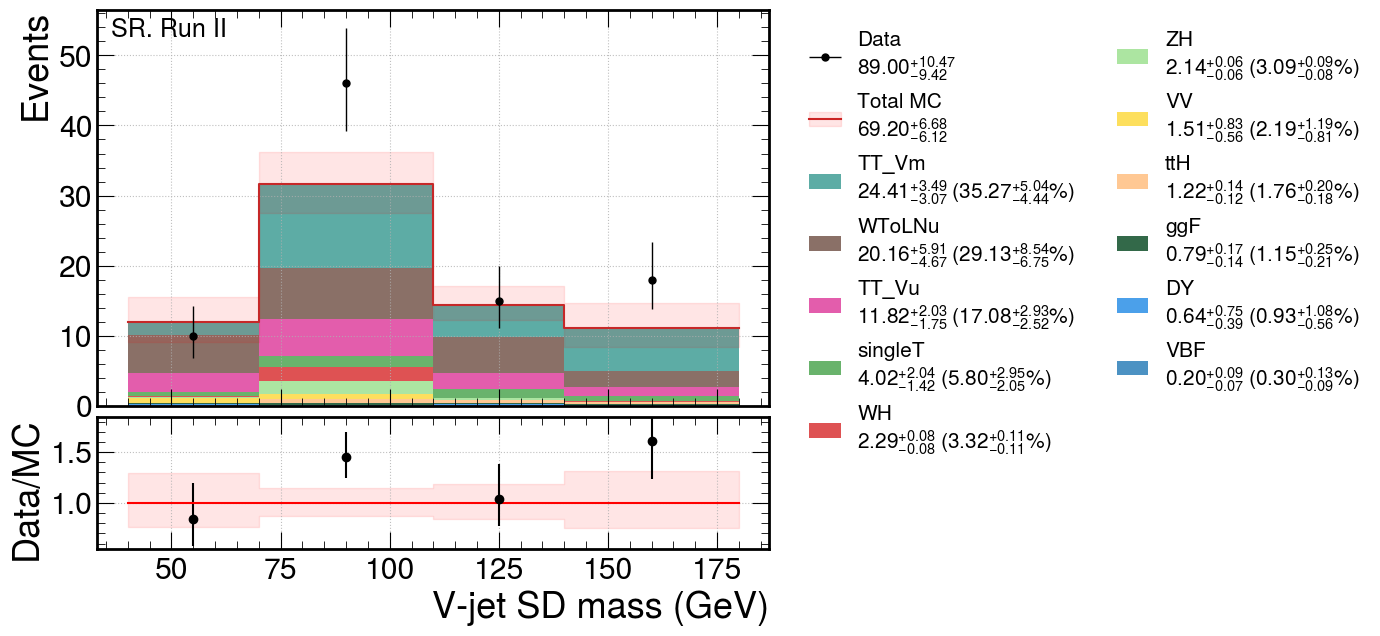

In [8]:
from slugify import slugify

variable_map = {

    "fj_mass": {
        "range": (40,180),
        "bins": np.array([40,70,110,140,180]),
        "x_axis_label": "V-jet SD mass (GeV)"
        
    },
}

for var, cfg in variable_map.items():
    plot_data_mc_histogram(
        era_map,
        channels=["ele", "mu"],
        var=var,
        weight_field="weight_nominal_combined * trig_sf * v_tag_sf * 0.984 * weight_btag",
        bins=cfg.get("bins", 50),
        range=cfg["range"],
        x_axis_label=cfg["x_axis_label"],
        selection="(numberBJets_Medium_OutsideFatJets == 0) & (ReconVCandidateFatJetVScore > 0.9) & "
         "(THWW > 0.905) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250)  & ((mjj < 1000) | (deta < 2.5)) "
         " & (fj_mass > 40.) & (fj_mass < 180.)",
        plot_title="SR. Run II",
        ratio_range=cfg.get("ratio_range", [0.55, 1.85]),
        logy=cfg.get("logy", False),
    )

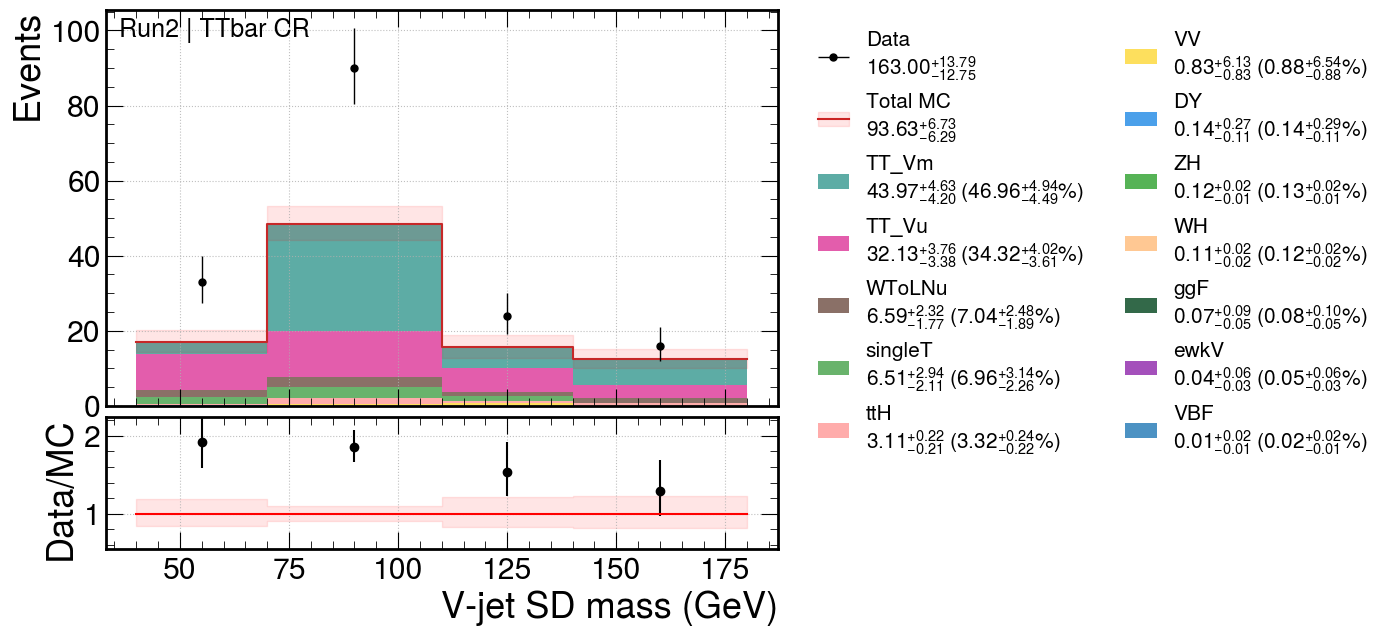

In [9]:
# Define what to plot
era_groups = {
    # "2016": ["2016"],
    # "2016APV": ["2016APV"],
    # "2017": ["2017"],
    # "2018": ["2018"],
    "Run2": ["2016", "2016APV", "2017", "2018"]
}

# Plotting
for era_label, eras_in_group in era_groups.items():
    # Pass full era_map for combined plots; otherwise, single-era slice
    if set(eras_in_group) == set(era_map.keys()):
        era_subset = era_map  # full combined map
    else:
        era_subset = {era: era_map[era] for era in eras_in_group}

    for var, cfg in variable_map.items():
        plot_data_mc_histogram(
            era_map=era_subset,
            channels=["ele", "mu"],
            var=var,
            weight_field="weight_nominal_combined * trig_sf * v_tag_sf * 0.984 * weight_btag",
            bins=cfg.get("bins", 50),
            range=cfg["range"],
            x_axis_label=cfg["x_axis_label"],
            selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.75) & "
                "(fj_mass>40.) & (fj_mass < 180)"
            ),
            plot_title=(
                f"{era_label} | TTbar CR"
            ),
            ratio_range=cfg.get("ratio_range", [0.55, 2.25]),
            logy=cfg.get("logy", False),
        )

    del era_subset


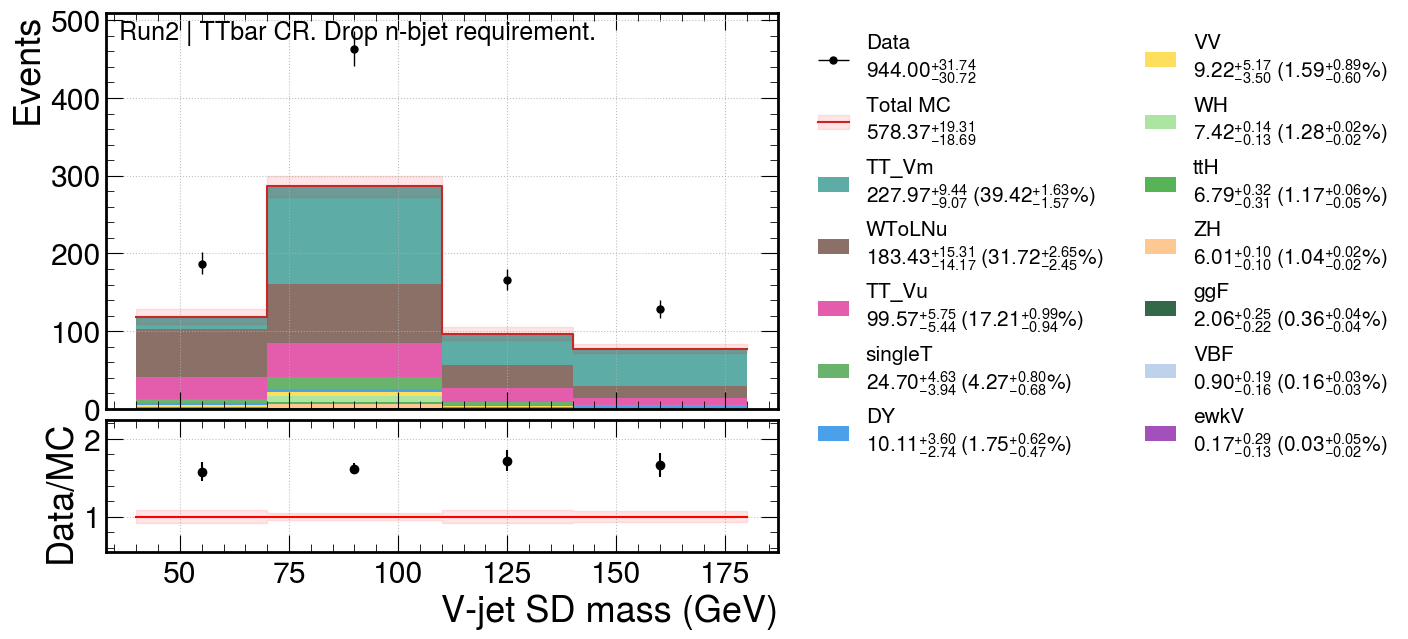

In [12]:
# Define what to plot
era_groups = {
    # "2016": ["2016"],
    # "2016APV": ["2016APV"],
    # "2017": ["2017"],
    # "2018": ["2018"],
    "Run2": ["2016", "2016APV", "2017", "2018"]
}

variable_map = {

    "fj_mass": {
        "range": (40,180),
        "bins": np.array([40,70,110,140,180]),
        "x_axis_label": "V-jet SD mass (GeV)"
        
    },

}

# Plotting
for era_label, eras_in_group in era_groups.items():
    # Pass full era_map for combined plots; otherwise, single-era slice
    if set(eras_in_group) == set(era_map.keys()):
        era_subset = era_map  # full combined map
    else:
        era_subset = {era: era_map[era] for era in eras_in_group}

    for var, cfg in variable_map.items():
        plot_data_mc_histogram(
            era_map=era_subset,
            channels=["ele", "mu"],
            var=var,
            weight_field="weight_nominal_combined * trig_sf * v_tag_sf * 0.984 * weight_btag",
            bins=cfg.get("bins", 50),
            range=cfg["range"],
            x_axis_label=cfg["x_axis_label"],
            selection=(
                "(met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.75) & "
                "(fj_mass>40.) & (fj_mass < 180)"
            ),
            plot_title=(
                f"{era_label} | TTbar CR. Drop n-bjet requirement."
            ),
            ratio_range=cfg.get("ratio_range", [0.55, 2.25]),
            logy=cfg.get("logy", False),
        )

    del era_subset


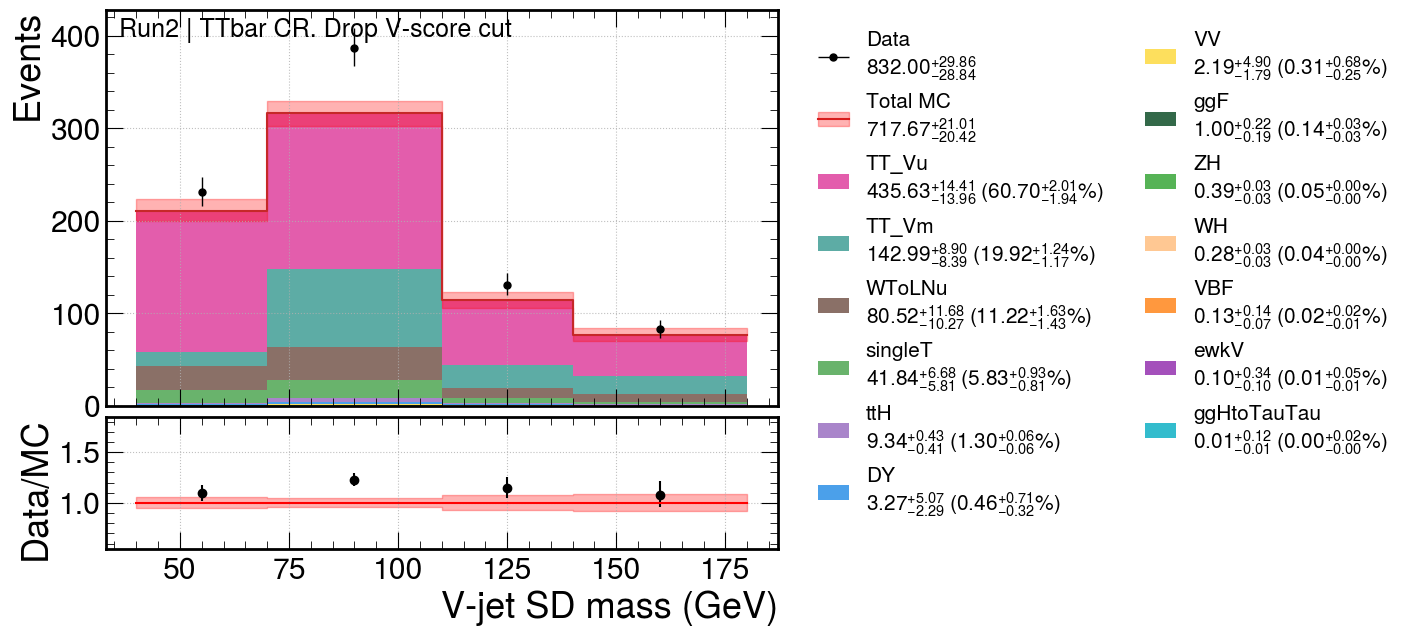

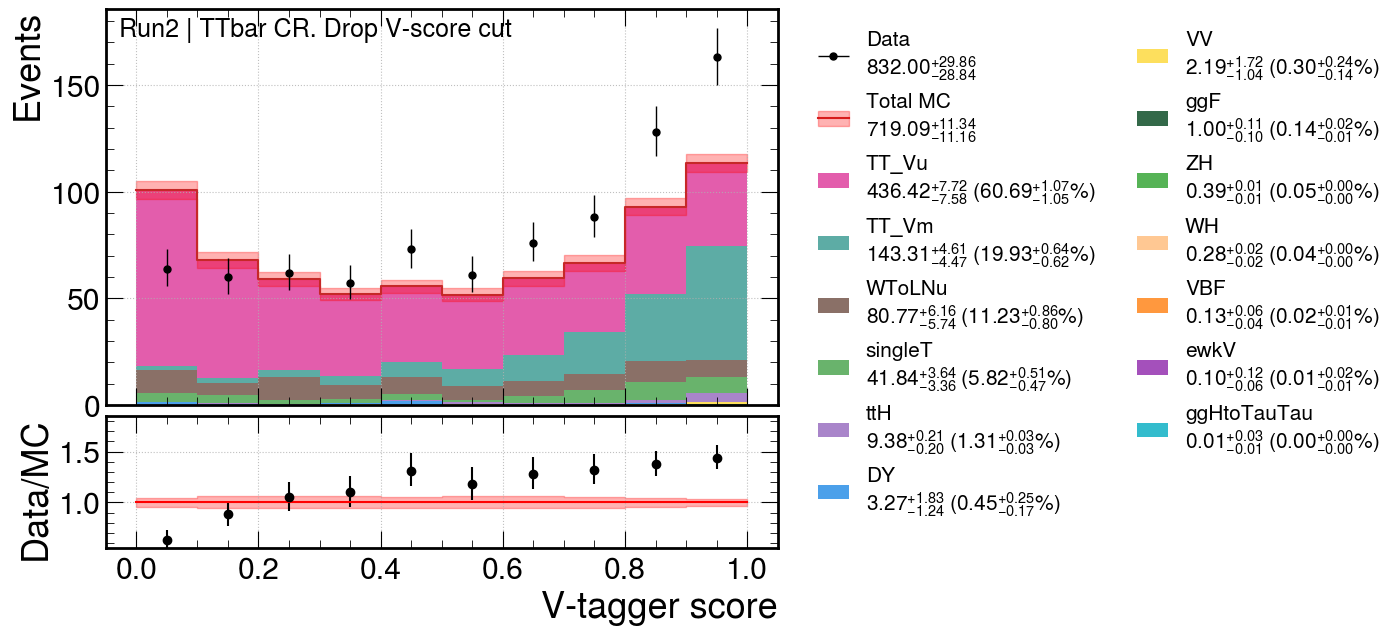

In [14]:
# Define what to plot
era_groups = {
    # "2016": ["2016"],
    # "2016APV": ["2016APV"],
    # "2017": ["2017"],
    # "2018": ["2018"],
    "Run2": ["2016", "2016APV", "2017", "2018"]
}

variable_map = {

    "fj_mass": {
        "range": (40,180),
        "bins": np.array([40,70,110,140,180]),
        "x_axis_label": "V-jet SD mass (GeV)"
        
    },


    "ReconVCandidateFatJetVScore": {
        "range": (0, 1),
        "bins": 10,
        "x_axis_label": "V-tagger score",
        # "logy": True
    },
}

# Plotting
for era_label, eras_in_group in era_groups.items():
    # Pass full era_map for combined plots; otherwise, single-era slice
    if set(eras_in_group) == set(era_map.keys()):
        era_subset = era_map  # full combined map
    else:
        era_subset = {era: era_map[era] for era in eras_in_group}

    for var, cfg in variable_map.items():
        plot_data_mc_histogram(
            era_map=era_subset,
            channels=["ele", "mu"],
            var=var,
            weight_field="weight_nominal_combined * trig_sf * 0.984 * weight_btag",
            bins=cfg.get("bins", 50),
            range=cfg["range"],
            x_axis_label=cfg["x_axis_label"],
            selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (THWW > 0.75) & "
                "(fj_mass>40.) & (fj_mass < 180)"
            ),
            plot_title=(
                f"{era_label} | TTbar CR. Drop V-score cut"
            ),
            ratio_range=cfg.get("ratio_range", [0.55, 1.85]),
            logy=cfg.get("logy", False),
        )

    del era_subset


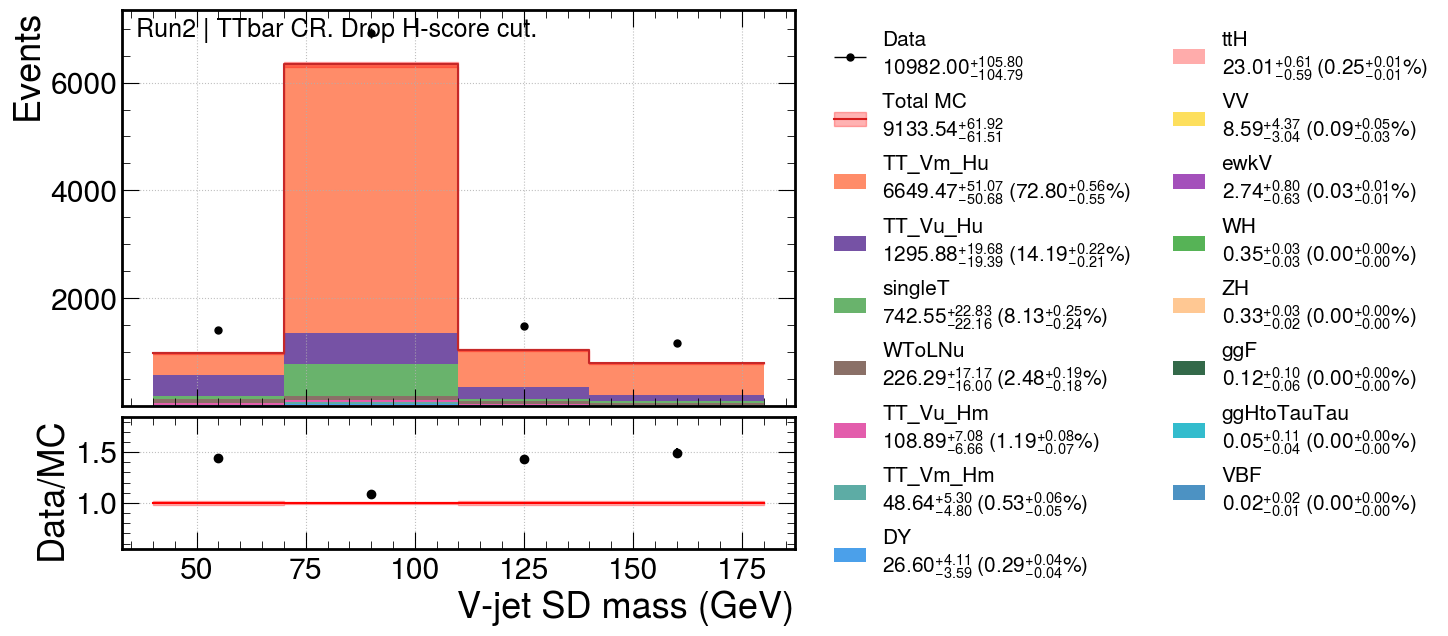

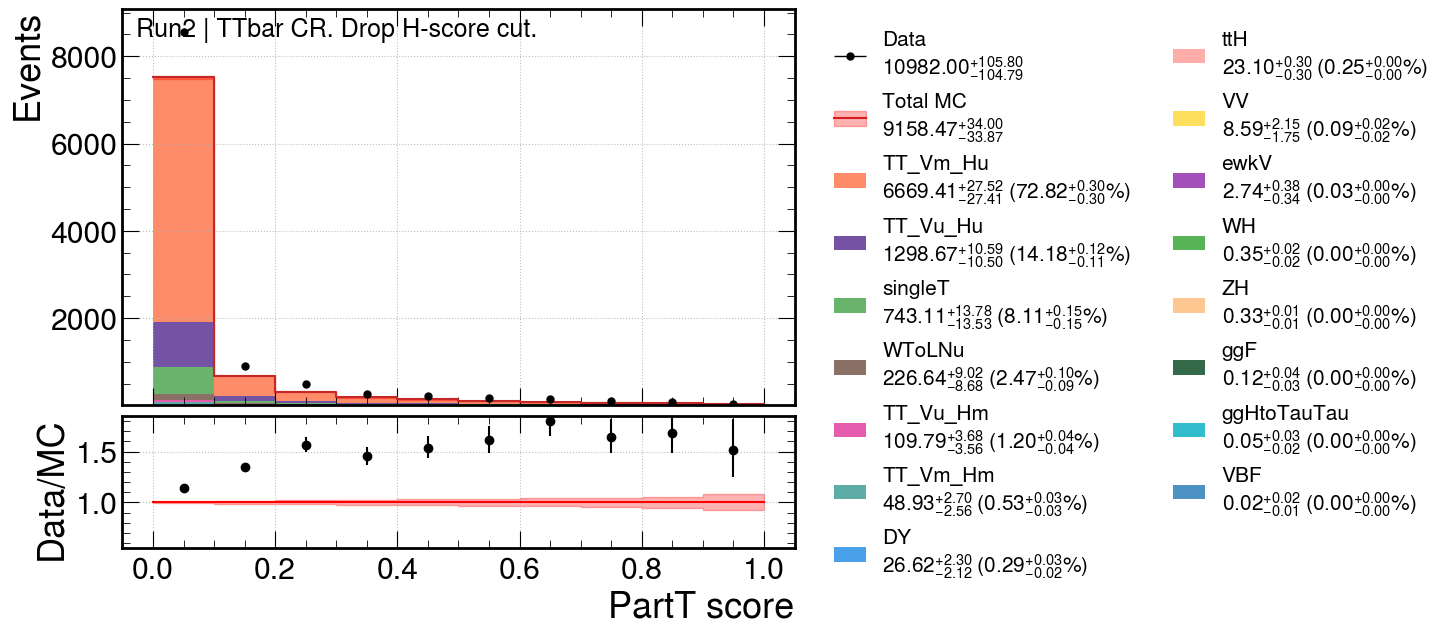

In [13]:
# Define what to plot
era_groups = {
    # "2016": ["2016"],
    # "2016APV": ["2016APV"],
    # "2017": ["2017"],
    # "2018": ["2018"],
    "Run2": ["2016", "2016APV", "2017", "2018"]
}

variable_map = {

    "fj_mass": {
        "range": (40,180),
        "bins": np.array([40,70,110,140,180]),
        "x_axis_label": "V-jet SD mass (GeV)"
        
    },

    "THWW" : {
        "range": (0, 1),
        "bins": 10,
        "x_axis_label": "PartT score",
        # "logy": True
    },

}

# Plotting
for era_label, eras_in_group in era_groups.items():
    # Pass full era_map for combined plots; otherwise, single-era slice
    if set(eras_in_group) == set(era_map.keys()):
        era_subset = era_map  # full combined map
    else:
        era_subset = {era: era_map[era] for era in eras_in_group}

    for var, cfg in variable_map.items():
        plot_data_mc_histogram(
            era_map=era_subset,
            channels=["ele", "mu"],
            var=var,
            weight_field="weight_nominal_combined * trig_sf * v_tag_sf * weight_btag",
            bins=cfg.get("bins", 50),
            range=cfg["range"],
            x_axis_label=cfg["x_axis_label"],
            selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9) & "
                "(fj_mass>40.) & (fj_mass < 180)"
            ),
            plot_title=(
                f"{era_label} | TTbar CR. Drop H-score cut."
            ),
            ratio_range=cfg.get("ratio_range", [0.55, 1.85]),
            logy=cfg.get("logy", False),
        )

    del era_subset


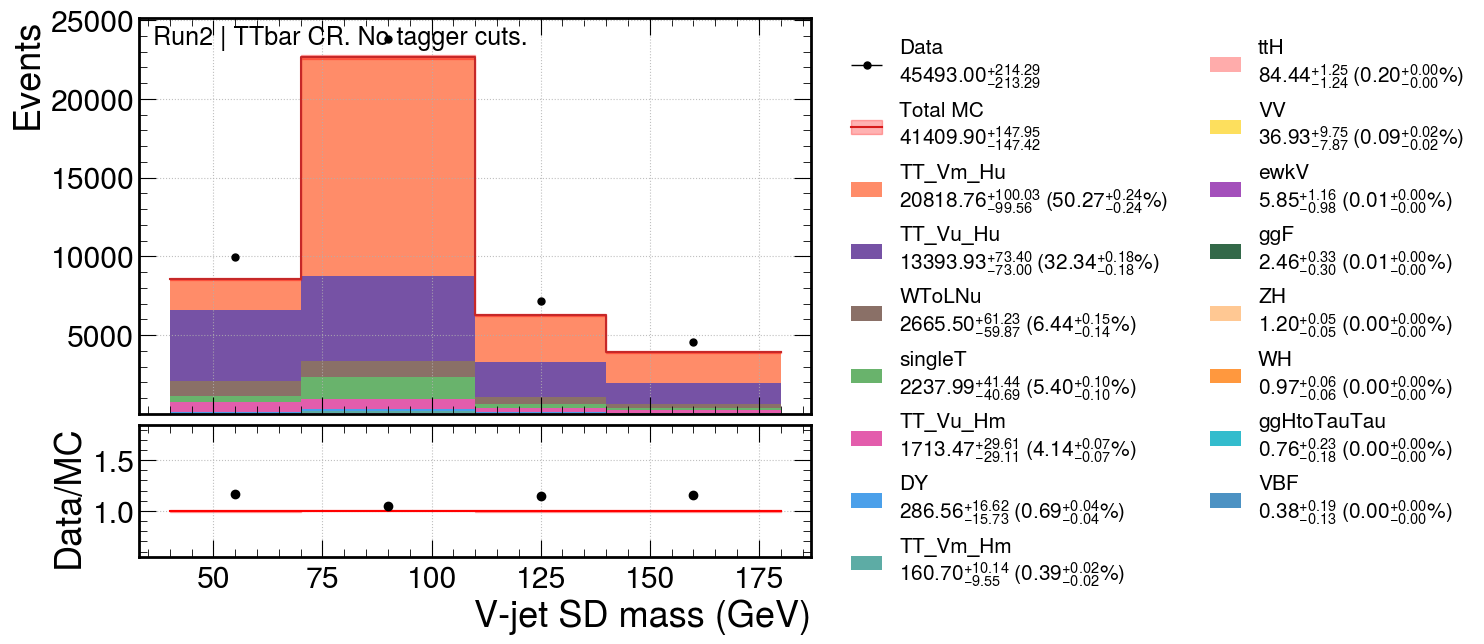

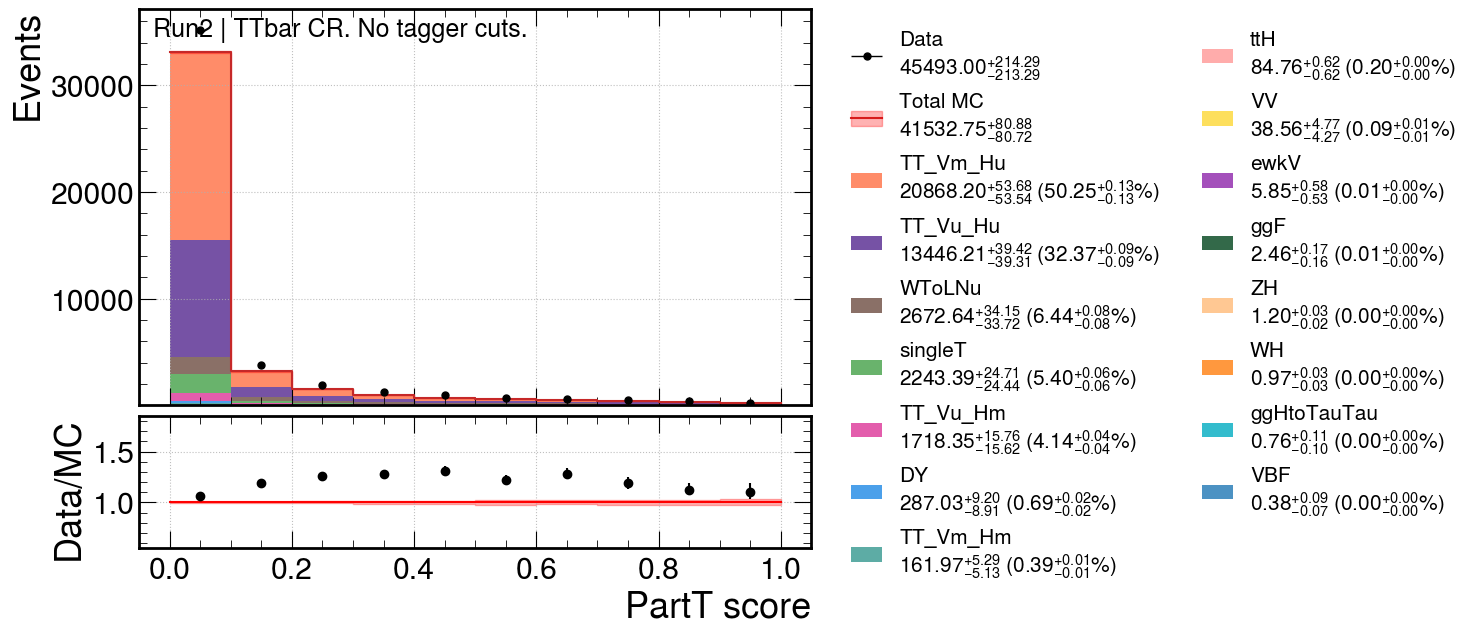

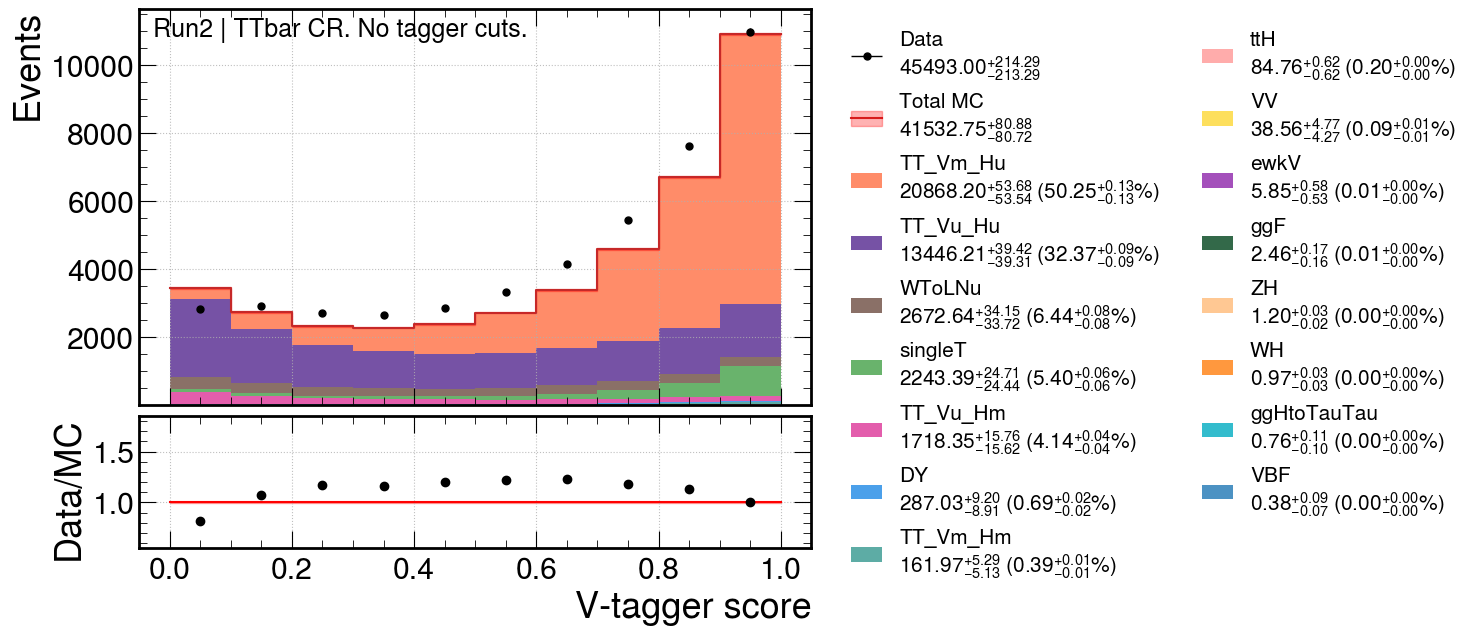

In [14]:
# Define what to plot
era_groups = {
    # "2016": ["2016"],
    # "2016APV": ["2016APV"],
    # "2017": ["2017"],
    # "2018": ["2018"],
    "Run2": ["2016", "2016APV", "2017", "2018"]
}

variable_map = {

    "fj_mass": {
        "range": (40,180),
        "bins": np.array([40,70,110,140,180]),
        "x_axis_label": "V-jet SD mass (GeV)"
        
    },

    "THWW" : {
        "range": (0, 1),
        "bins": 10,
        "x_axis_label": "PartT score",
        # "logy": True
    },

    "ReconVCandidateFatJetVScore": {
        "range": (0, 1),
        "bins": 10,
        "x_axis_label": "V-tagger score",
        # "logy": True
    },

}

# Plotting
for era_label, eras_in_group in era_groups.items():
    # Pass full era_map for combined plots; otherwise, single-era slice
    if set(eras_in_group) == set(era_map.keys()):
        era_subset = era_map  # full combined map
    else:
        era_subset = {era: era_map[era] for era in eras_in_group}

    for var, cfg in variable_map.items():
        plot_data_mc_histogram(
            era_map=era_subset,
            channels=["ele", "mu"],
            var=var,
            weight_field="weight_nominal_combined * trig_sf * weight_btag",
            bins=cfg.get("bins", 50),
            range=cfg["range"],
            x_axis_label=cfg["x_axis_label"],
            selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & "
                "(fj_mass>40.) & (fj_mass < 180)"
            ),
            plot_title=(
                f"{era_label} | TTbar CR. No tagger cuts."
            ),
            ratio_range=cfg.get("ratio_range", [0.55, 1.85]),
            logy=cfg.get("logy", False),
        )

    del era_subset



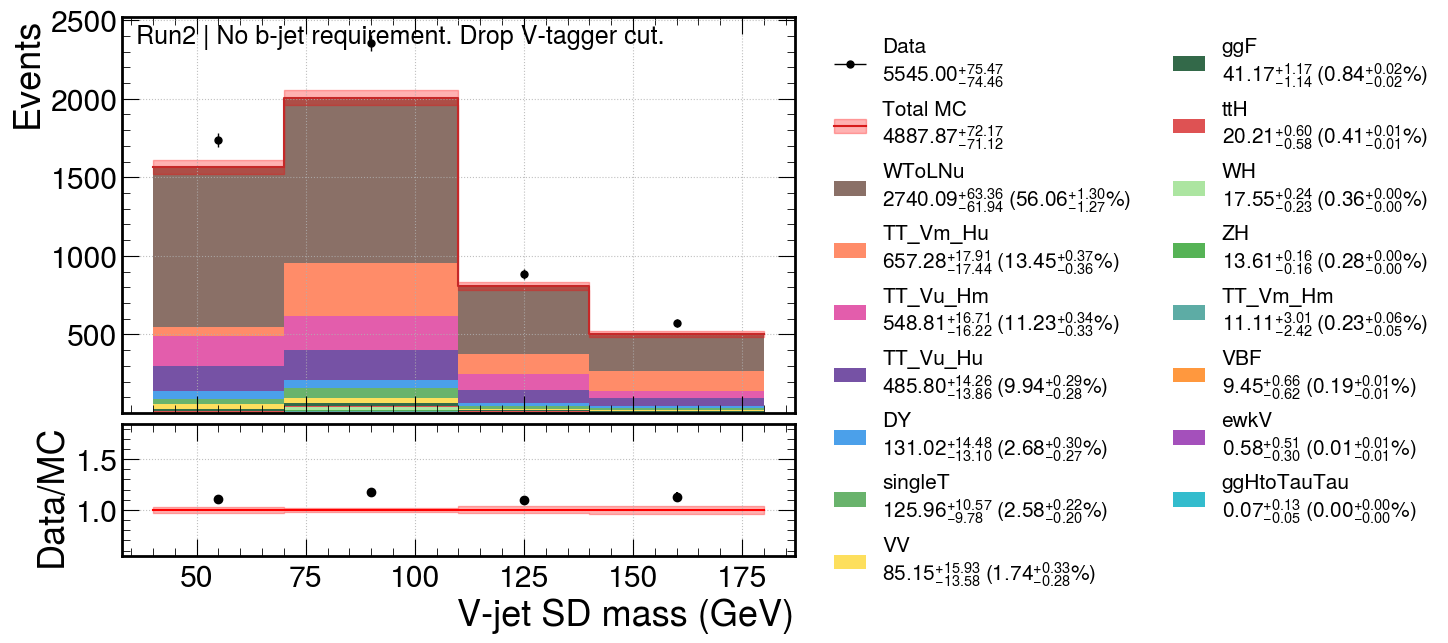

In [15]:
# Define what to plot
era_groups = {
    # "2016": ["2016"],
    # "2016APV": ["2016APV"],
    # "2017": ["2017"],
    # "2018": ["2018"],
    "Run2": ["2016", "2016APV", "2017", "2018"]
}


variable_map = {

    "fj_mass": {
        "range": (40,180),
        "bins": np.array([40,70,110,140,180]),
        "x_axis_label": "V-jet SD mass (GeV)"
        
    },

}

# Plotting
for era_label, eras_in_group in era_groups.items():
    # Pass full era_map for combined plots; otherwise, single-era slice
    if set(eras_in_group) == set(era_map.keys()):
        era_subset = era_map  # full combined map
    else:
        era_subset = {era: era_map[era] for era in eras_in_group}

    for var, cfg in variable_map.items():
        plot_data_mc_histogram(
            era_map=era_subset,
            channels=["ele", "mu"],
            var=var,
            weight_field="weight_nominal_combined * trig_sf",
            bins=cfg.get("bins", 50),
            range=cfg["range"],
            x_axis_label=cfg["x_axis_label"],
            selection=(
                "(met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & "
                "(fj_mass>40.) & (fj_mass < 180) & "
                " (THWW > 0.75)"
            ),
            plot_title=(
                f"{era_label} | No b-jet requirement. Drop V-tagger cut."
            ),
            ratio_range=cfg.get("ratio_range", [0.55, 1.85]),
            logy=cfg.get("logy", False),
        )

    del era_subset

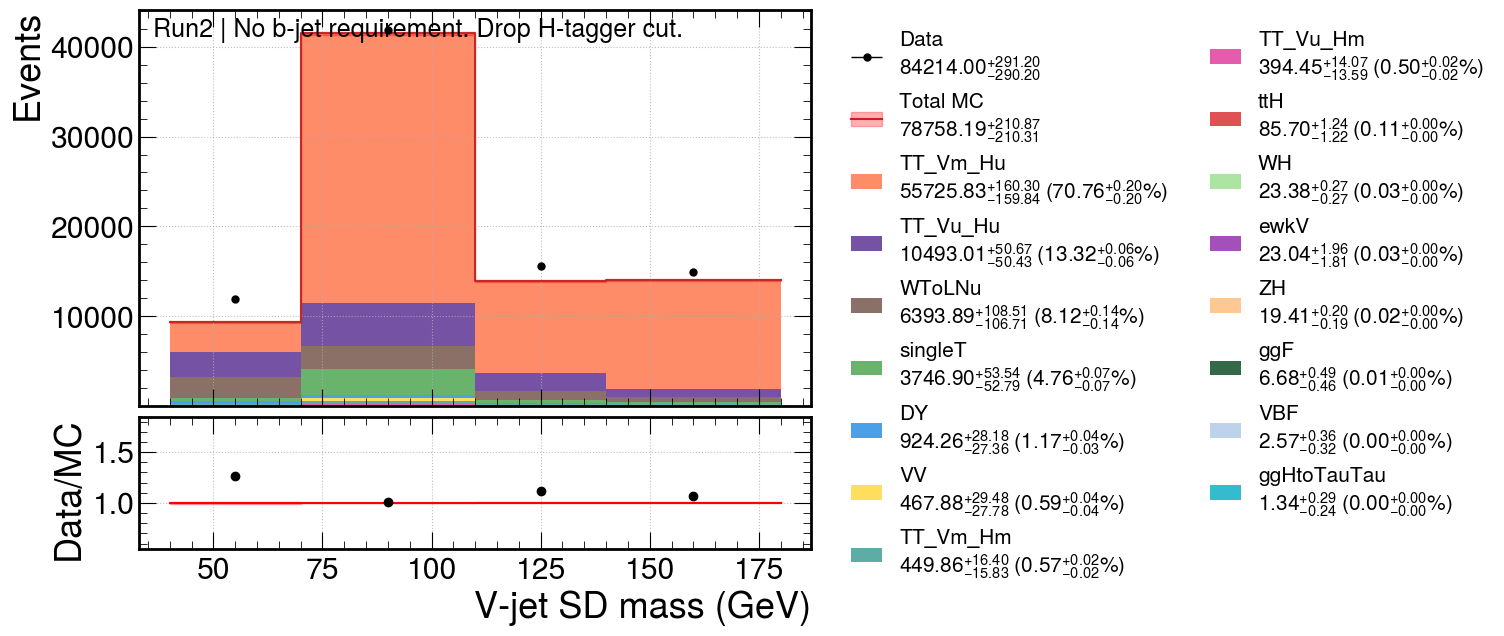

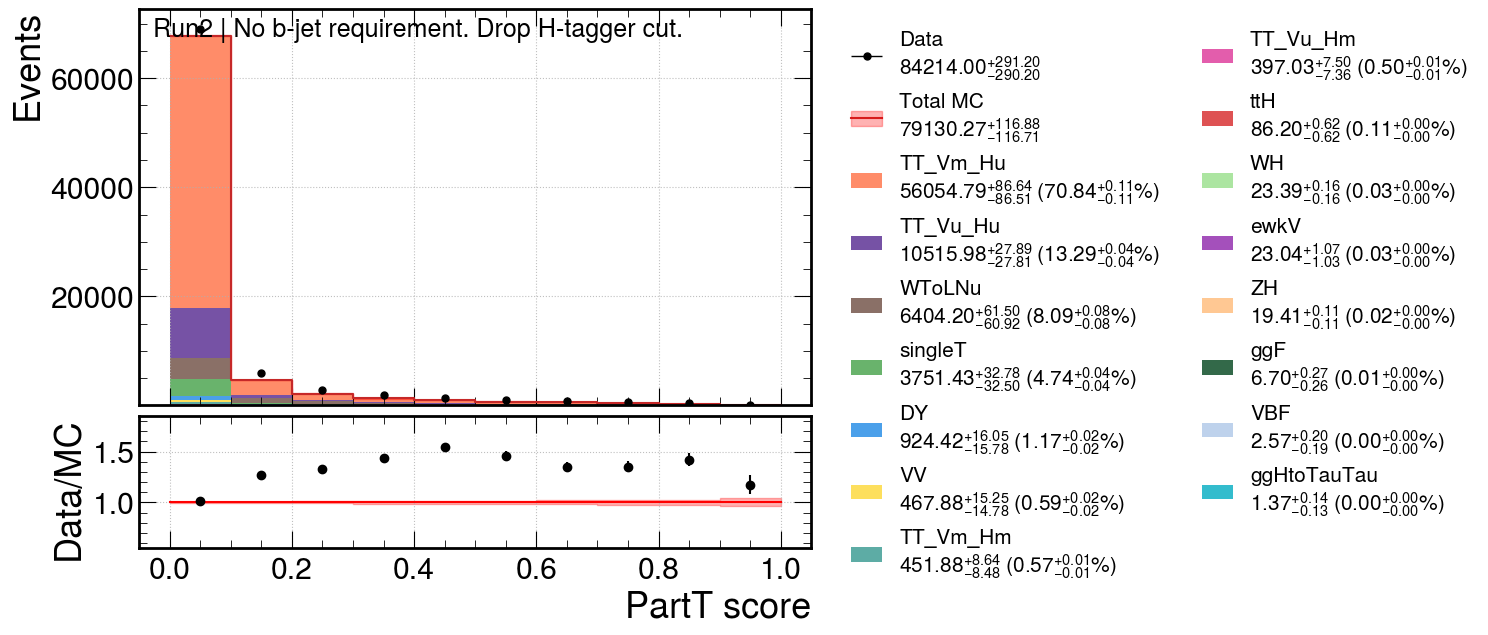

In [16]:
# Define what to plot
era_groups = {
    "Run2": ["2016", "2016APV", "2017", "2018"]
}


variable_map = {

    "fj_mass": {
        "range": (40,180),
        "bins": np.array([40,70,110,140,180]),
        "x_axis_label": "V-jet SD mass (GeV)"
        
    },

    "THWW" : {
        "range": (0, 1),
        "bins": 10,
        "x_axis_label": "PartT score",
        # "logy": True
    },

}

# Plotting
for era_label, eras_in_group in era_groups.items():
    # Pass full era_map for combined plots; otherwise, single-era slice
    if set(eras_in_group) == set(era_map.keys()):
        era_subset = era_map  # full combined map
    else:
        era_subset = {era: era_map[era] for era in eras_in_group}

    for var, cfg in variable_map.items():
        plot_data_mc_histogram(
            era_map=era_subset,
            channels=["ele", "mu"],
            var=var,
            weight_field="weight_nominal_combined * trig_sf",
            bins=cfg.get("bins", 50),
            range=cfg["range"],
            x_axis_label=cfg["x_axis_label"],
            selection=(
                "(met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & "
                "(fj_mass>40.) & (fj_mass < 180) & "
                "(ReconVCandidateFatJetVScore > 0.9)"
            ),
            plot_title=(
                f"{era_label} | No b-jet requirement. Drop H-tagger cut."
            ),
            ratio_range=cfg.get("ratio_range", [0.55, 1.85]),
            logy=cfg.get("logy", False),
        )

    del era_subset


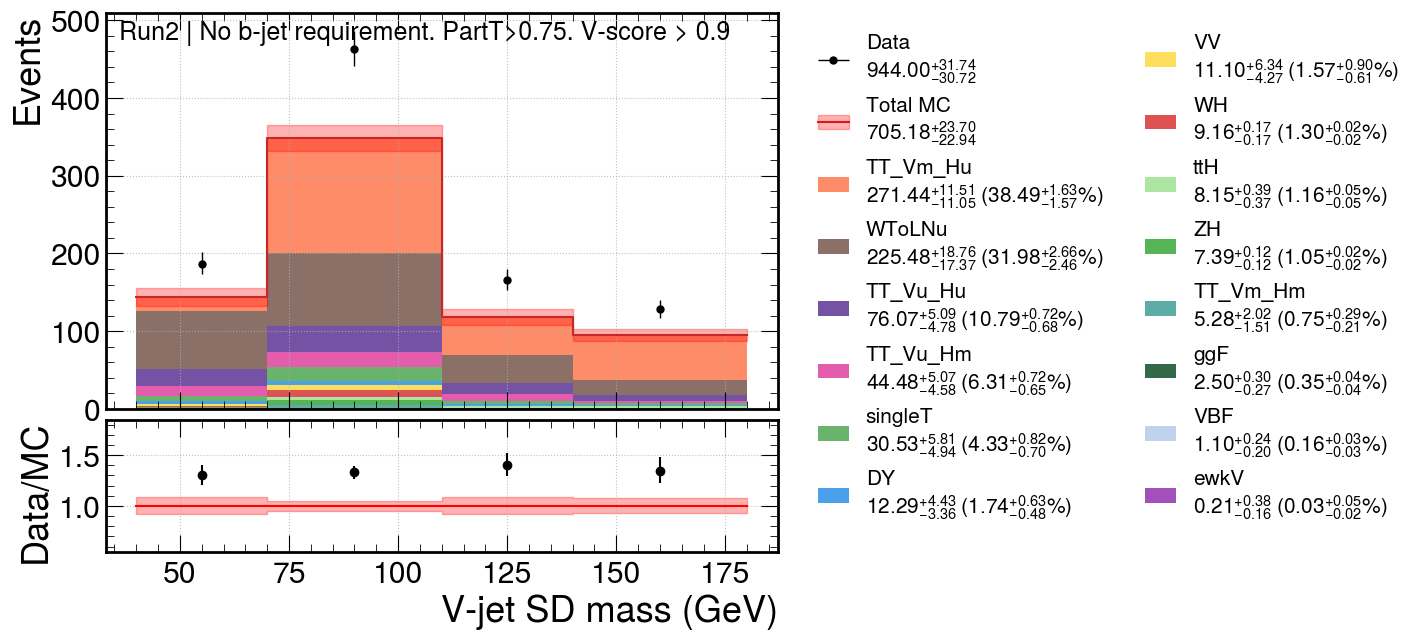

In [18]:
# Define what to plot
era_groups = {
    # "2016": ["2016"],
    # "2016APV": ["2016APV"],
    # "2017": ["2017"],
    # "2018": ["2018"],
    "Run2": ["2016", "2016APV", "2017", "2018"]
}

variable_map = {

    "fj_mass": {
        "range": (40,180),
        "bins": np.array([40,70,110,140,180]),
        "x_axis_label": "V-jet SD mass (GeV)"
        
    },

}

# Plotting
for era_label, eras_in_group in era_groups.items():
    # Pass full era_map for combined plots; otherwise, single-era slice
    if set(eras_in_group) == set(era_map.keys()):
        era_subset = era_map  # full combined map
    else:
        era_subset = {era: era_map[era] for era in eras_in_group}

    for var, cfg in variable_map.items():
        plot_data_mc_histogram(
            era_map=era_subset,
            channels=["ele", "mu"],
            var=var,
            weight_field="weight_nominal_combined * trig_sf",
            bins=cfg.get("bins", 50),
            range=cfg["range"],
            x_axis_label=cfg["x_axis_label"],
            selection=(
                "(met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & "
                "(fj_mass>40.) & (fj_mass < 180) & "
                "(ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.75)"
            ),
            plot_title=(
                f"{era_label} | No b-jet requirement. PartT>0.75. V-score > 0.9"
            ),
            ratio_range=cfg.get("ratio_range", [0.55, 1.85]),
            logy=cfg.get("logy", False),
        )

    del era_subset


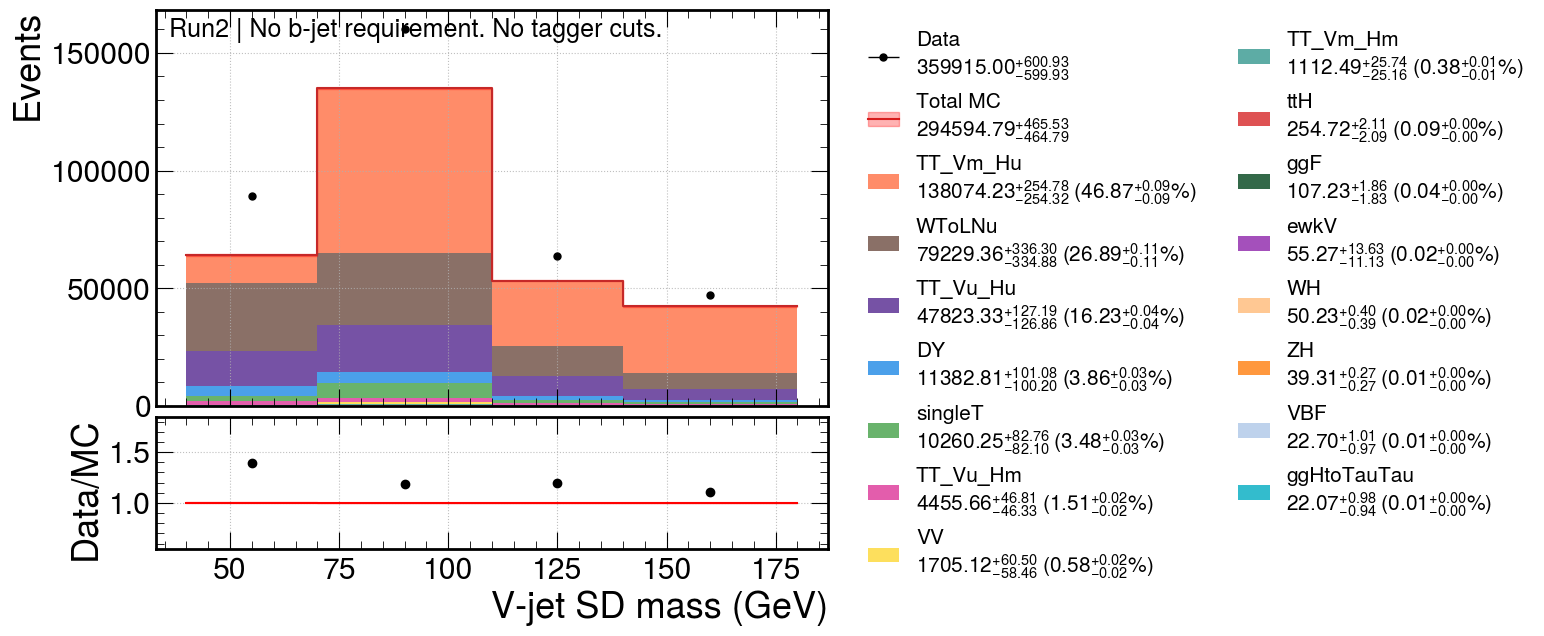

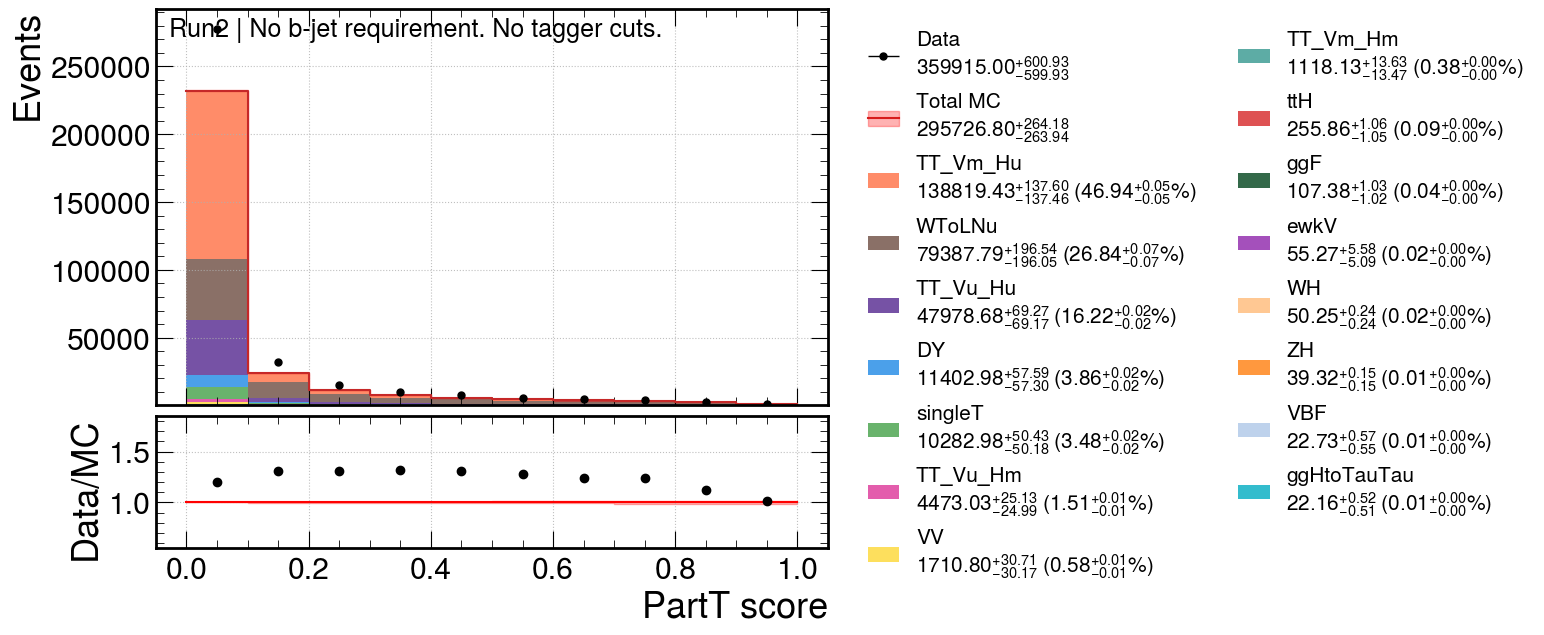

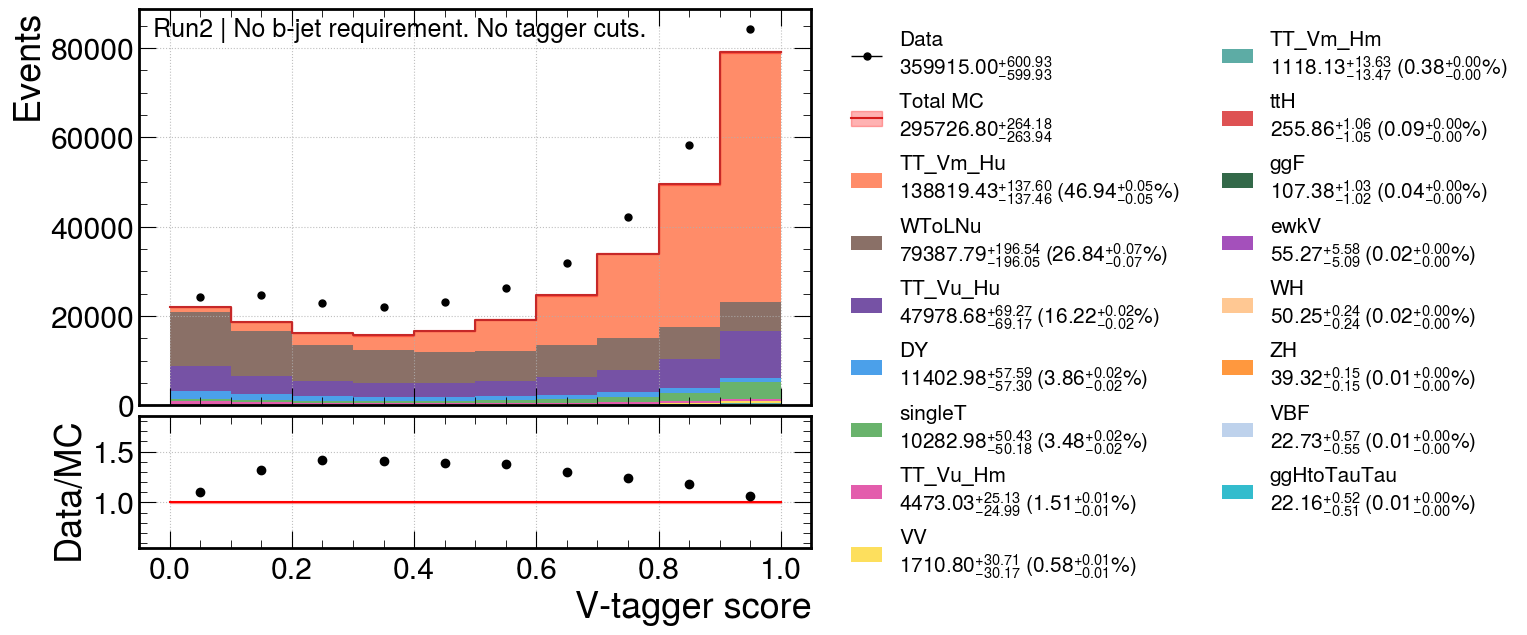

In [19]:
# Define what to plot
era_groups = {
    # "2016": ["2016"],
    # "2016APV": ["2016APV"],
    # "2017": ["2017"],
    # "2018": ["2018"],
    "Run2": ["2016", "2016APV", "2017", "2018"]
}

variable_map = {

    "fj_mass": {
        "range": (40,180),
        "bins": np.array([40,70,110,140,180]),
        "x_axis_label": "V-jet SD mass (GeV)"
        
    },

    "THWW" : {
        "range": (0, 1),
        "bins": 10,
        "x_axis_label": "PartT score",
        # "logy": True
    },

    "ReconVCandidateFatJetVScore": {
        "range": (0, 1),
        "bins": 10,
        "x_axis_label": "V-tagger score",
        # "logy": True
    },

}

# Plotting
for era_label, eras_in_group in era_groups.items():
    # Pass full era_map for combined plots; otherwise, single-era slice
    if set(eras_in_group) == set(era_map.keys()):
        era_subset = era_map  # full combined map
    else:
        era_subset = {era: era_map[era] for era in eras_in_group}

    for var, cfg in variable_map.items():
        plot_data_mc_histogram(
            era_map=era_subset,
            channels=["ele", "mu"],
            var=var,
            weight_field="weight_nominal_combined * trig_sf",
            bins=cfg.get("bins", 50),
            range=cfg["range"],
            x_axis_label=cfg["x_axis_label"],
            selection=(
                "(met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & "
                "(fj_mass>40.) & (fj_mass < 180)"
            ),
            plot_title=(
                f"{era_label} | No b-jet requirement. No tagger cuts."
            ),
            ratio_range=cfg.get("ratio_range", [0.55, 1.85]),
            logy=cfg.get("logy", False),
        )

    del era_subset


In [38]:
def plot_tt_split_histogram(
    era_map,
    channels=["ele"],
    var="fj_mass",
    weight_field="event_weight",
    selection=None,
    bins=50,
    range=(0, 300),
    x_axis_label=None,
    plot_title=None,
    logy=False,
    normalize=False,  # overlay normalized (area=1) step lines instead of stacked bars
):
    import matplotlib.pyplot as plt
    import boost_histogram as bh
    import numpy as np
    import mplhep as hep
    from hist.intervals import poisson_interval
    from collections import defaultdict
    import os
    from matplotlib import gridspec
    from slugify import slugify  # assumes python-slugify (package dir), not legacy single-file

    hep.style.use("CMS")

    # ---- fixed color map for categories
    FIXED_COLORS = {
        "TT_Vm_Hm": "#1f77b4",  # blue
        "TT_Vm_Hu": "#ff7f0e",  # orange
        "TT_Vu_Hm": "#2ca02c",  # green
        "TT_Vu_Hu": "#d62728",  # red
    }

    # ---- axes
    if isinstance(bins, int):
        if range is None:
            raise ValueError("`range` must be specified when `bins` is an integer.")
        axis = bh.axis.Regular(bins, range[0], range[1])
    elif isinstance(bins, (list, np.ndarray)):
        axis = bh.axis.Variable(bins)
    else:
        raise ValueError("`bins` must be either an int or a list/array of bin edges.")

    bin_edges = axis.edges
    bin_centers = axis.centers
    bin_widths = np.diff(bin_edges)
    group_histograms = defaultdict(lambda: bh.Histogram(axis, storage=bh.storage.Weight()))

    # ---- fill histograms
    for era, sample_map in era_map.items():
        for sample_data in sample_map.values():
            if sample_data["groupName"] != "TT":
                continue
            for channel in channels:
                if channel not in sample_data:
                    continue
                df = sample_data[channel]
                if df.empty or var not in df:
                    continue

                if selection:
                    try:
                        df = df.query(selection)
                    except Exception as e:
                        print(f"Selection error on sample '{sample_data.get('sample', '?')}', channel '{channel}': {e}")
                        continue

                if df.empty:
                    continue

                try:
                    xsec = sample_data.get("xsec")
                    sumgen = sample_data.get("sumgenweights")
                    lumi = sample_data.get("lumi", {}).get(channel)
                    if any(v is None for v in [xsec, sumgen, lumi]):
                        continue
                    scale = (xsec * lumi) / sumgen
                    nominal_all = df.eval(weight_field).values * scale

                    vm = (df["fj_V_isMatched"] == 1) & (df["fj_isV_2q"] == 1)
                    hm = (df["h_fj_V_isMatched"] == 1) & (df["h_fj_isV_2q"] == 1)
                    masks = {
                        "TT_Vm_Hm": vm & hm,
                        "TT_Vm_Hu": vm & ~hm,
                        "TT_Vu_Hm": ~vm & hm,
                        "TT_Vu_Hu": ~vm & ~hm,
                    }
                except Exception as e:
                    print(f"Error in TT processing: {e}")
                    continue

                for tag, mask in masks.items():
                    if not np.any(mask):
                        continue
                    df_tag = df[mask]
                    if df_tag.empty:
                        continue
                    nominal_tag = nominal_all[mask]
                    group_histograms[tag].fill(df_tag[var].values, weight=nominal_tag)

    total_tt_yield = float(sum(np.sum(h.view().value) for h in group_histograms.values()))

    # ---- plotting
    fig, ax_main = plt.subplots(figsize=(8, 6))
    ax_main.grid()

    # sort by yield (ascending for stacked bars; order does not affect colors)
    sorted_groups = sorted(
        [(g, h) for g, h in group_histograms.items() if np.sum(h.view().value) > 0],
        key=lambda x: np.sum(x[1].view().value)
    )

    color_cycle = plt.cm.Paired.colors  # fallback if an unexpected group appears
    handles, labels = [], []
    y_max_for_padding = 0.0  # <-- we'll track the top to add 5% headroom

    def _poisson_yield_and_fraction_label(vals: np.ndarray, vars_: np.ndarray, total: float, label: str = "") -> str:
        """Return 'yield ± (asym)  (fraction ± (asym))' using Garwood-like mapping (unnormalized)."""
        y = float(np.sum(vals))
        v = float(np.sum(vars_))
        if y <= 0 or v <= 0:
            f = (y / total) if total > 0 else 0.0
            return f"{label}\n$\\mathrm{{{y:.2f}}}\\;({f*100:.2f}\\%)$"

        eff = y * y / v
        lo, hi = poisson_interval(np.array([eff]))  # 68% by default
        lo, hi = float(lo[0]), float(hi[0])
        err_lo = y * (eff - lo) / eff if eff > 0 else 0.0
        err_hi = y * (hi - eff) / eff if eff > 0 else 0.0
        f = (y / total) if total > 0 else 0.0
        ferr_lo = (err_lo / total) if total > 0 else 0.0
        ferr_hi = (err_hi / total) if total > 0 else 0.0
        return (
            f"{label}\n"
            f"$\\mathrm{{{y:.2f}}}^{{+{err_hi:.2f}}}_{{-{err_lo:.2f}}}"
            f"\\;({f*100:.2f}^{{+{ferr_hi*100:.2f}}}_{{-{ferr_lo*100:.2f}}}\\%)$"
        )

    if normalize:
        # ---- overlay (non-stacked) line/step plots with area=1
        for i, (group, histo) in enumerate(sorted_groups):
            view = histo.view()
            vals = view.value.copy()
            vars_ = view.variance.copy()
            leglabel = _poisson_yield_and_fraction_label(vals, vars_, total_tt_yield, group)

            # Proper density normalization: sum(vals * bin_widths) = 1
            area = float(np.sum(vals * bin_widths))
            if area > 0:
                vals_density = vals / area
            else:
                vals_density = np.zeros_like(vals)

            # track ymax for padding
            if vals_density.size:
                y_max_for_padding = max(y_max_for_padding, float(np.max(vals_density)))

            color = FIXED_COLORS.get(group, color_cycle[i % len(color_cycle)])
            stairs = ax_main.stairs(vals_density, bin_edges,
                                    linewidth=1.8,
                                    alpha=0.95,
                                    color=color,
                                    label=leglabel)
            handles.append(stairs); labels.append(leglabel)

        ax_main.set_ylabel("Density (area = 1)")
    else:
        bottoms = np.zeros_like(bin_centers, dtype=float)
        for i, (group, histo) in enumerate(sorted_groups):
            view = histo.view()
            vals = view.value
            vars_ = view.variance
            leglabel = _poisson_yield_and_fraction_label(vals, vars_, total_tt_yield, group)

            color = FIXED_COLORS.get(group, color_cycle[i % len(color_cycle)])
            bar = ax_main.bar(
                bin_centers, vals, width=bin_widths,
                bottom=bottoms, color=color,
                align="center", alpha=0.8, linewidth=0
            )
            bottoms += vals
            handles.append(bar[0]); labels.append(leglabel)

        ax_main.set_ylabel("Events")
        if bottoms.size:
            y_max_for_padding = float(np.max(bottoms))

    # --- add 5% headroom at the top
    if y_max_for_padding > 0:
        ax_main.set_ylim(top=y_max_for_padding * 1.05)

    ax_main.set_xlabel(x_axis_label or var)
    if logy:
        ax_main.set_yscale("log")

    ax_main.legend(handles, labels, fontsize=12, ncol=1, loc="upper left",
                   frameon=False, handlelength=1.5)
    if plot_title:
        ax_main.set_title(plot_title, fontsize="medium")

    plt.tight_layout()
    plt.show()

    output_dir = os.path.join("plots", slugify(plot_title or var))
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir, f"{var}.png"), dpi=300, bbox_inches="tight")


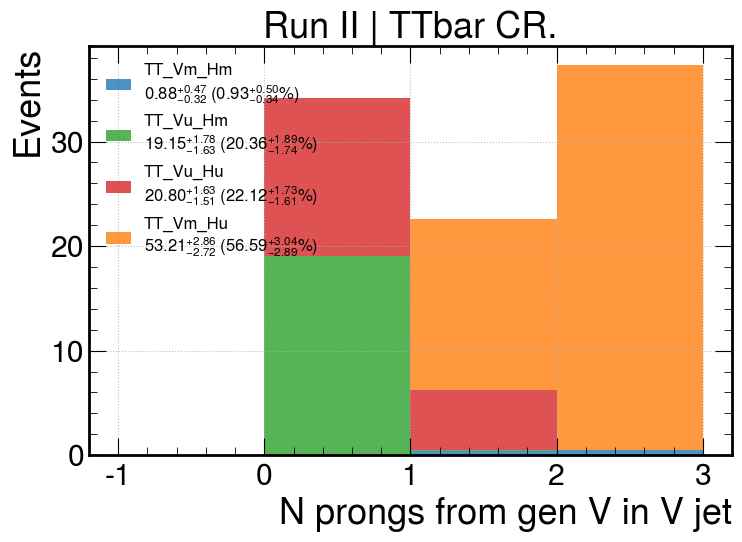

In [39]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="fj_nprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N prongs from gen V in V jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.75) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | TTbar CR."
    ),    logy=False,
)

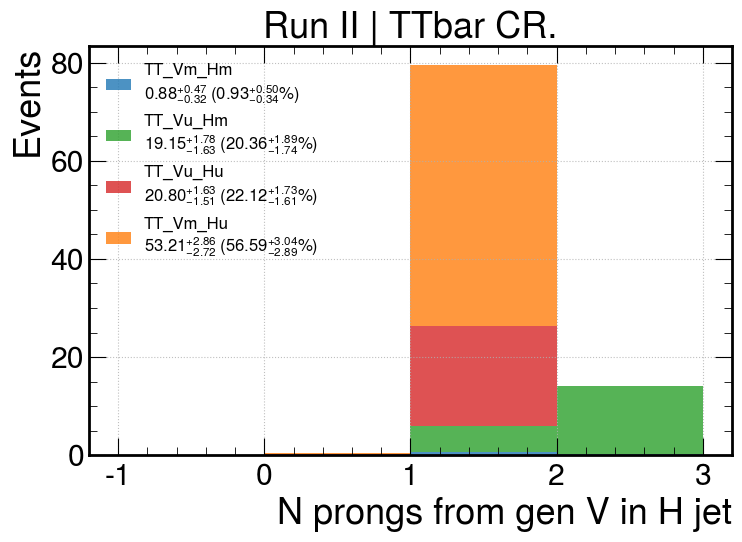

In [40]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="h_fj_nprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N prongs from gen V in H jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.75) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | TTbar CR."
    ),    logy=False,
    
)

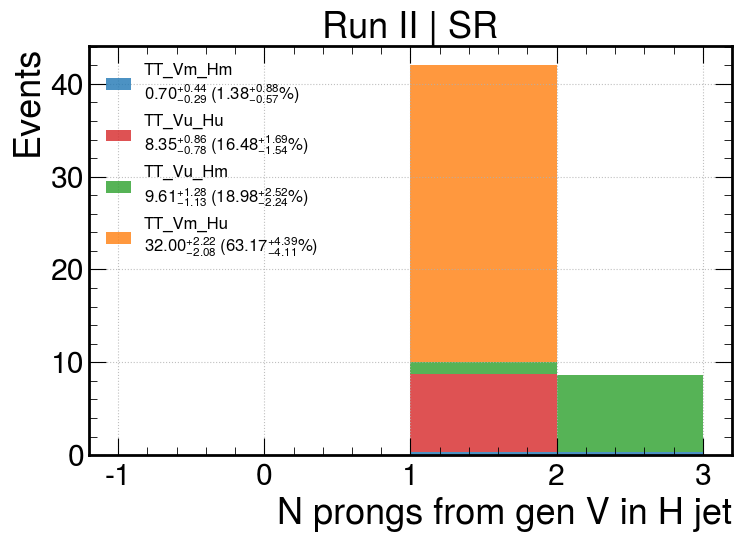

In [41]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="h_fj_nprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N prongs from gen V in H jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.905) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | SR"
    ),    logy=False,
)

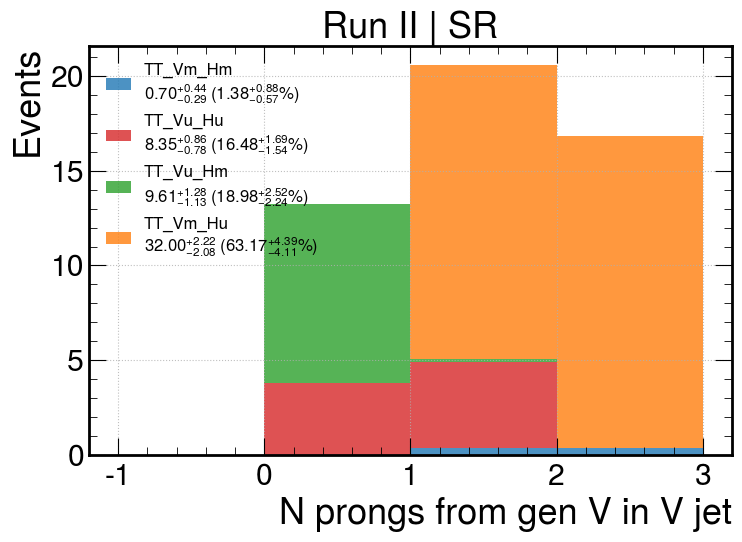

In [42]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="fj_nprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N prongs from gen V in V jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.905) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | SR"
    ),    logy=False,
)

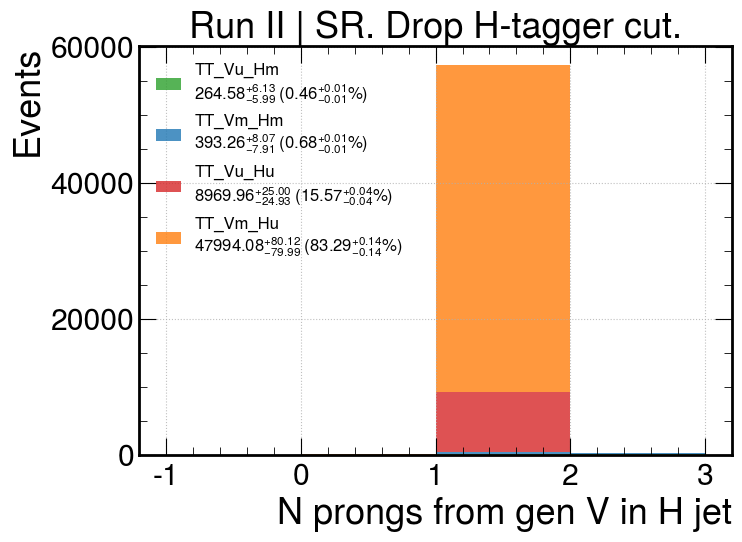

In [43]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="h_fj_nprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N prongs from gen V in H jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | SR. Drop H-tagger cut."
    ),    logy=False,
)

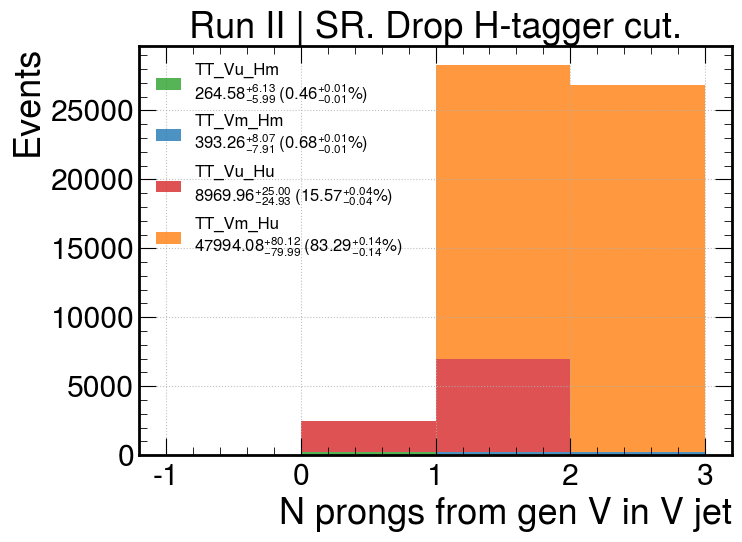

In [44]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="fj_nprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N prongs from gen V in V jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | SR. Drop H-tagger cut."
    ),    logy=False,
)

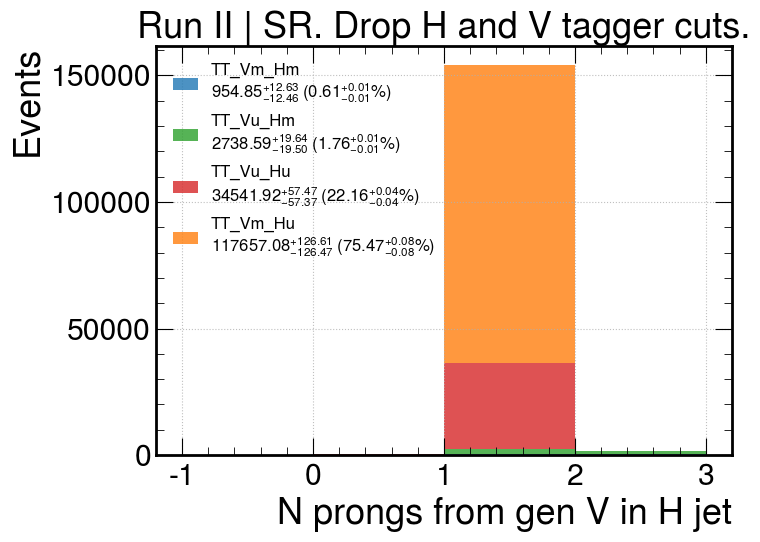

In [45]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="h_fj_nprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N prongs from gen V in H jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | SR. Drop H and V tagger cuts."
    ),    logy=False,
)

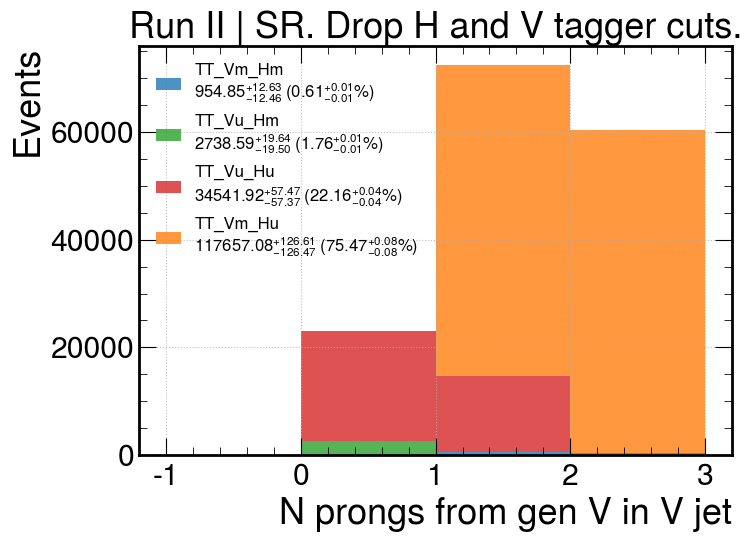

In [46]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="fj_nprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N prongs from gen V in V jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | SR. Drop H and V tagger cuts."
    ),    logy=False,
)

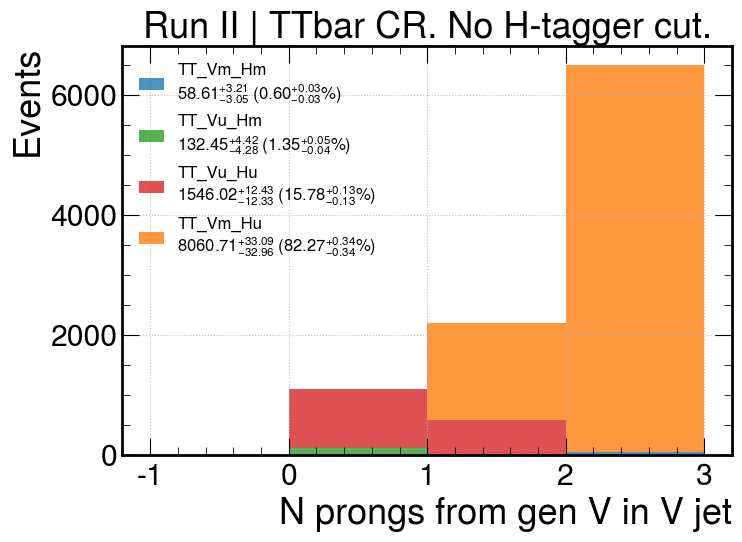

In [47]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="fj_nprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N prongs from gen V in V jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | TTbar CR. No H-tagger cut."
    ),    logy=False,
)

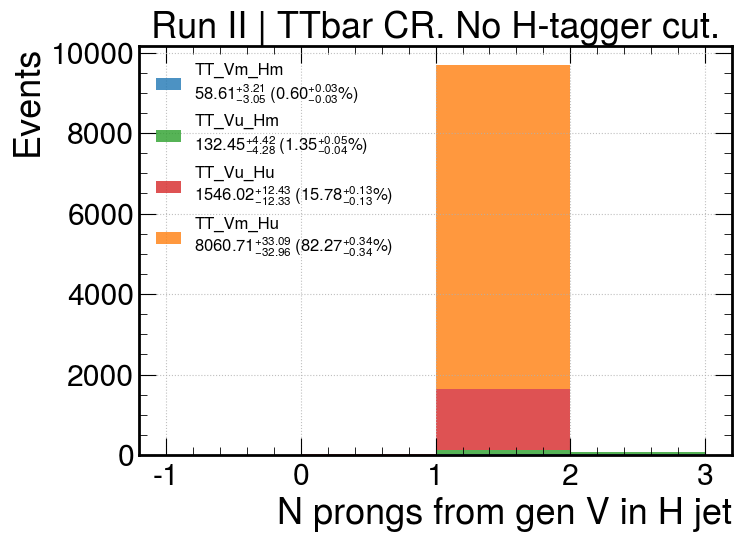

In [48]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="h_fj_nprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N prongs from gen V in H jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | TTbar CR. No H-tagger cut."
    ),    logy=False,
)

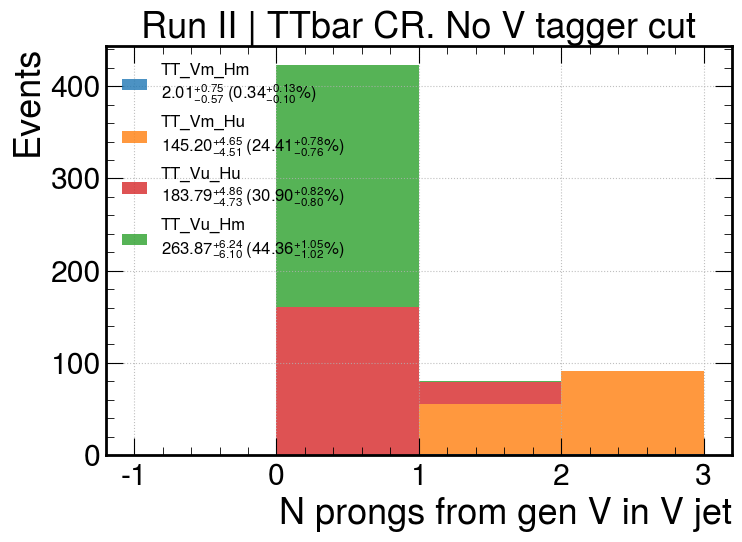

In [49]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="fj_nprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N prongs from gen V in V jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (THWW > 0.75) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | TTbar CR. No V tagger cut"
    ),    logy=False,
)

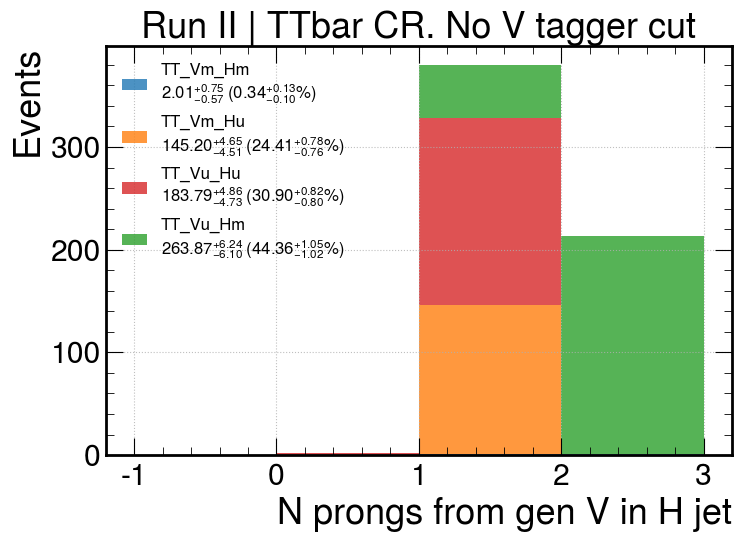

In [50]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="h_fj_nprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N prongs from gen V in H jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (THWW > 0.75) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | TTbar CR. No V tagger cut"
    ),    logy=False,
)

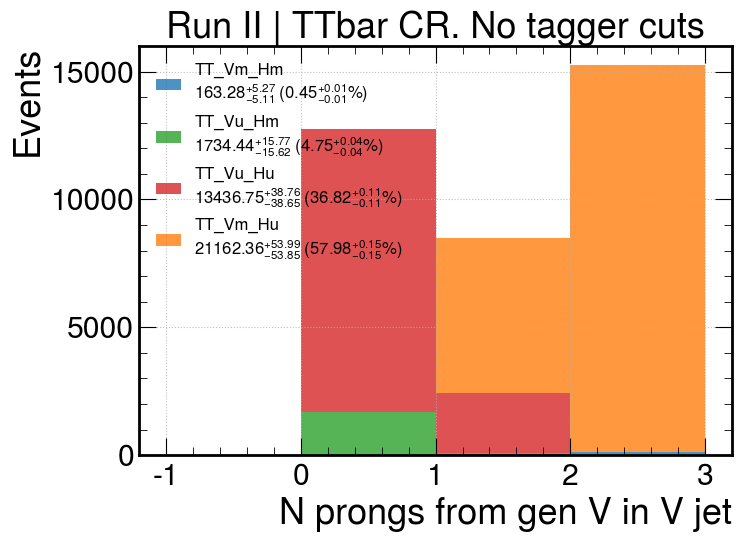

In [51]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="fj_nprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N prongs from gen V in V jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | TTbar CR. No tagger cuts"
    ),    logy=False,
)

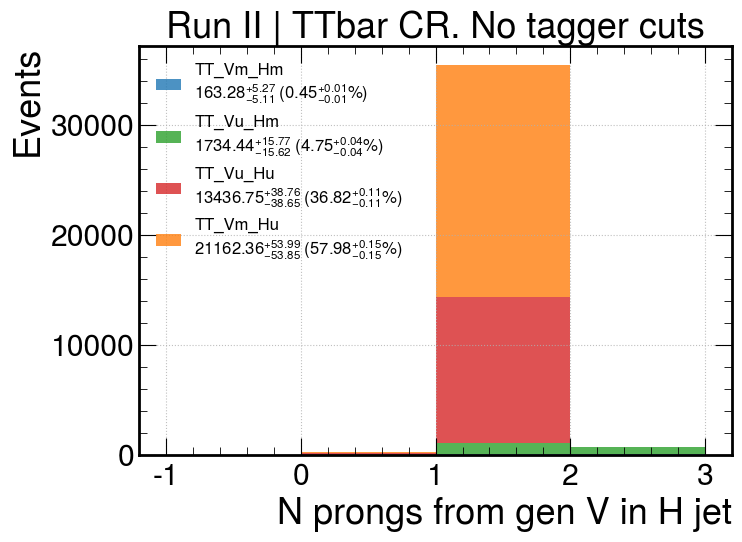

In [52]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="h_fj_nprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N prongs from gen V in H jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | TTbar CR. No tagger cuts"
    ),    logy=False,
)

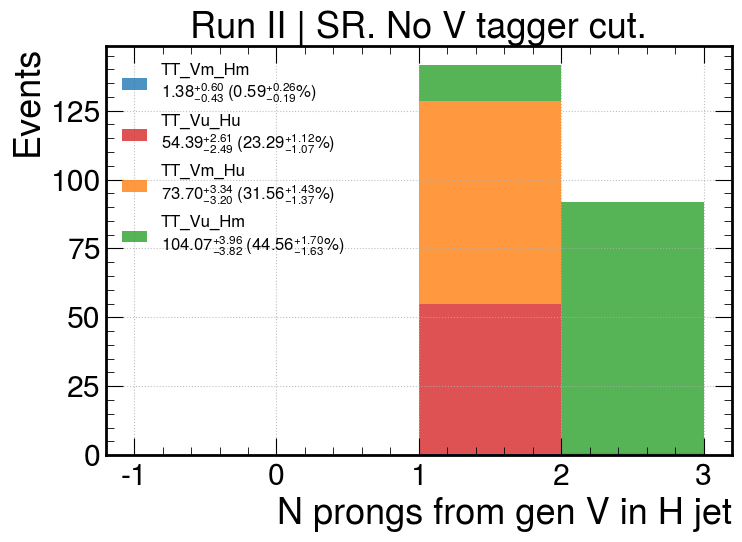

In [53]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="h_fj_nprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N prongs from gen V in H jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (THWW > 0.905) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | SR. No V tagger cut."
    ),    logy=False,
)

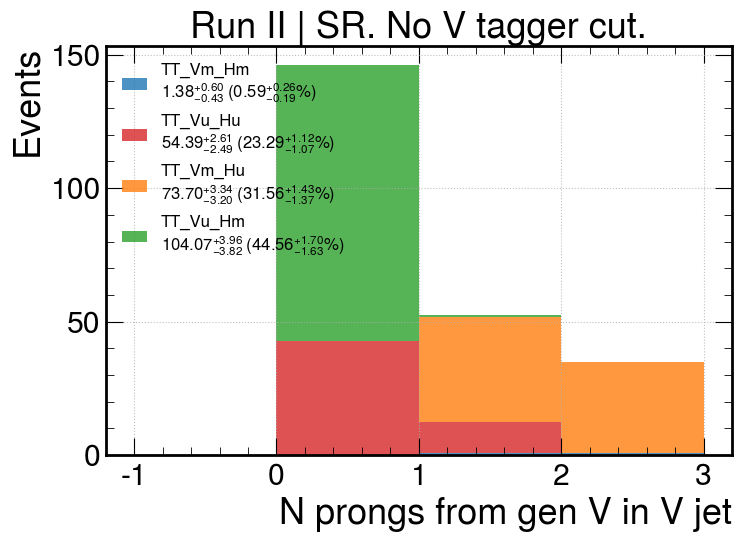

In [54]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="fj_nprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N prongs from gen V in V jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (THWW > 0.905) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | SR. No V tagger cut."
    ),    logy=False,
)

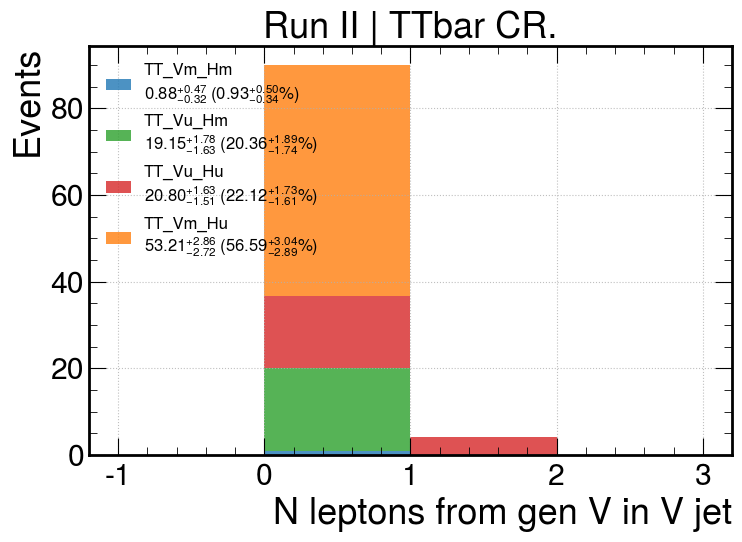

In [55]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="fj_lepinprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N leptons from gen V in V jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.75) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | TTbar CR."
    ),    logy=False,
)

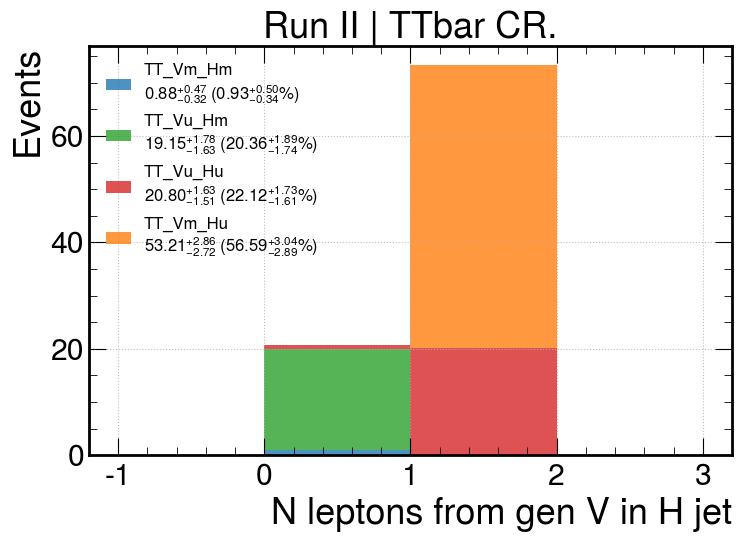

In [56]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="h_fj_lepinprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N leptons from gen V in H jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.75) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | TTbar CR."
    ),    logy=False,
)

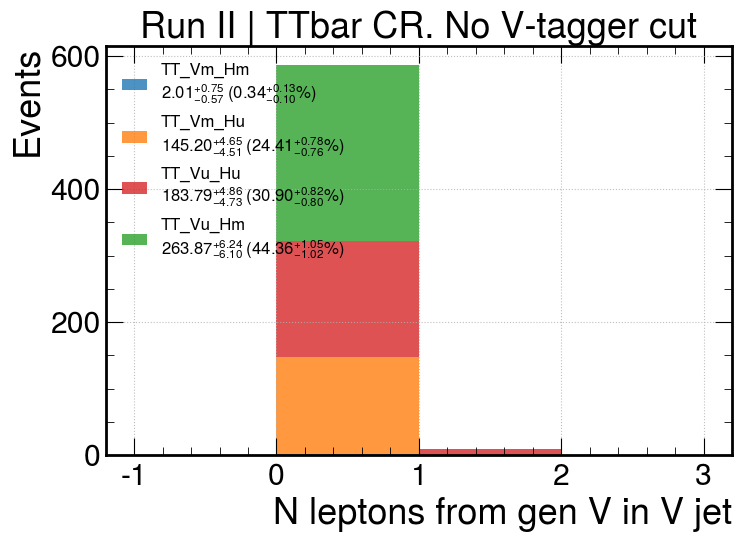

In [57]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="fj_lepinprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N leptons from gen V in V jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (THWW > 0.75) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | TTbar CR. No V-tagger cut"
    ),    logy=False,
)

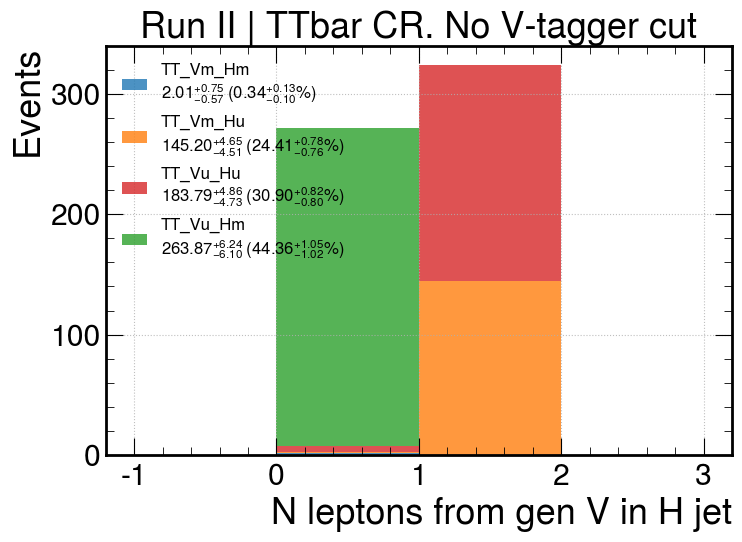

In [58]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="h_fj_lepinprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N leptons from gen V in H jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (THWW > 0.75) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | TTbar CR. No V-tagger cut"
    ),    logy=False,
)

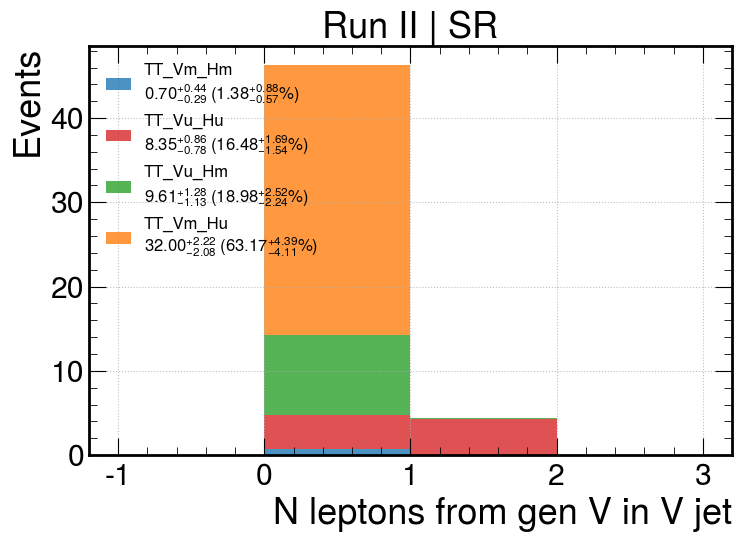

In [59]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="fj_lepinprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N leptons from gen V in V jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.905) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | SR"
    ),    logy=False,
)

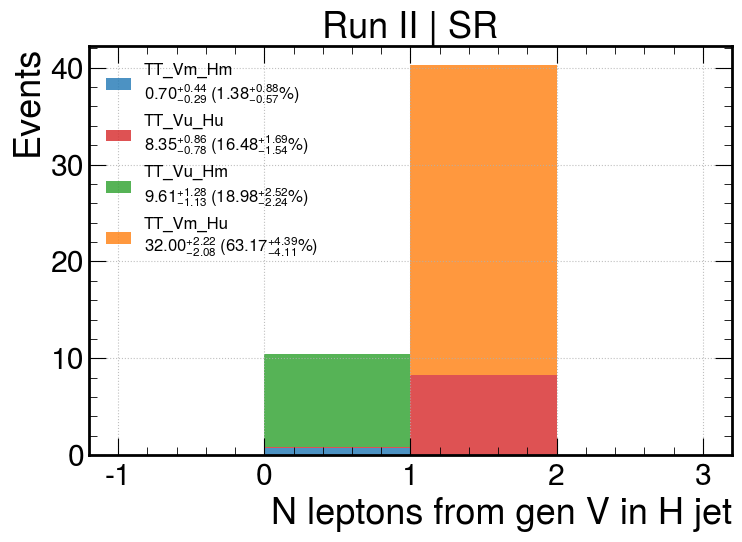

In [60]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="h_fj_lepinprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N leptons from gen V in H jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.905) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | SR"
    ),    logy=False,
)

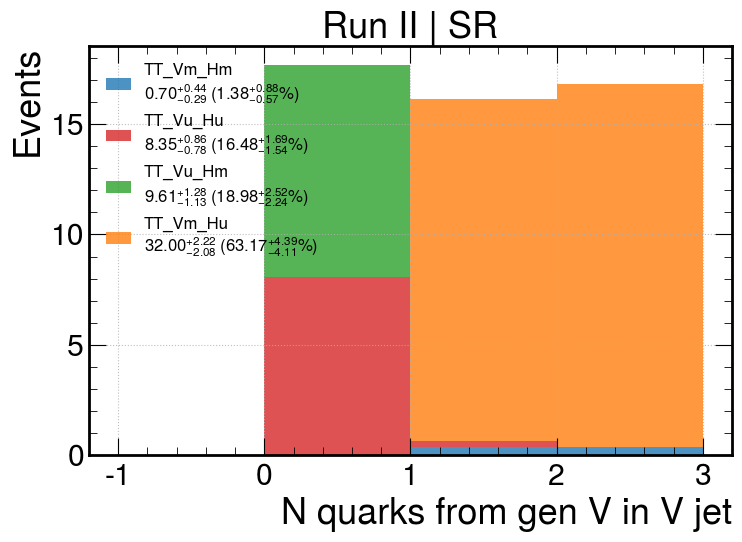

In [61]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="fj_qsinprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N quarks from gen V in V jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.905) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | SR"
    ),    logy=False,
)

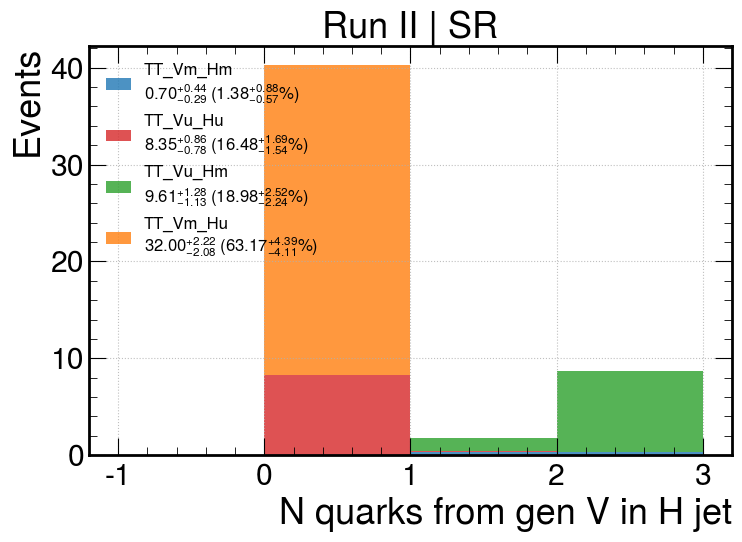

In [62]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="h_fj_qsinprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N quarks from gen V in H jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.905) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | SR"
    ),    logy=False,
)

<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_251018/3922118147.py:8: SyntaxWarning: invalid escape sequence '\D'
  x_axis_label="N quarks from gen V within $\Delta R < 0.8$ of V jet",


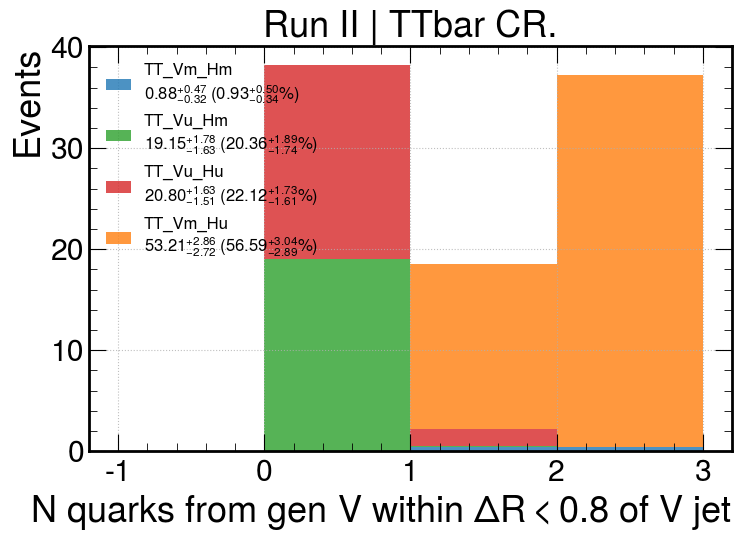

In [63]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="fj_qsinprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N quarks from gen V within $\Delta R < 0.8$ of V jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.75) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | TTbar CR."
    ),    logy=False,
)

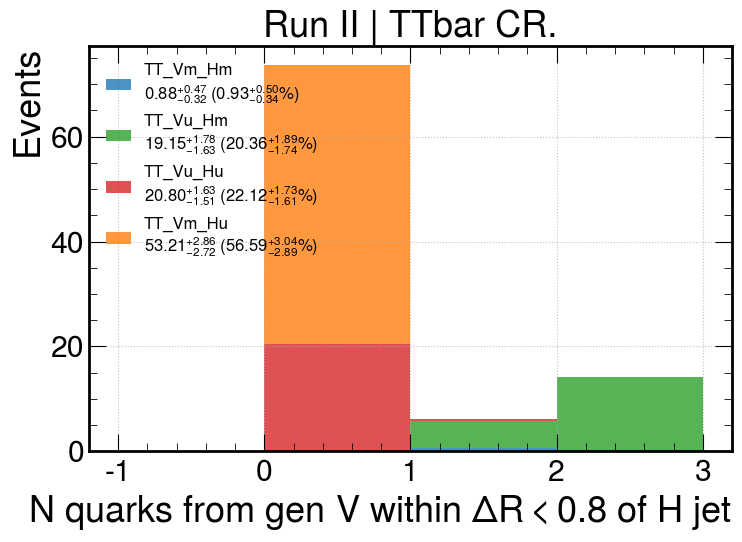

In [64]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="h_fj_qsinprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label=rf"N quarks from gen V within $\Delta R < 0.8$ of H jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.75) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | TTbar CR."
    ),    logy=False,
)

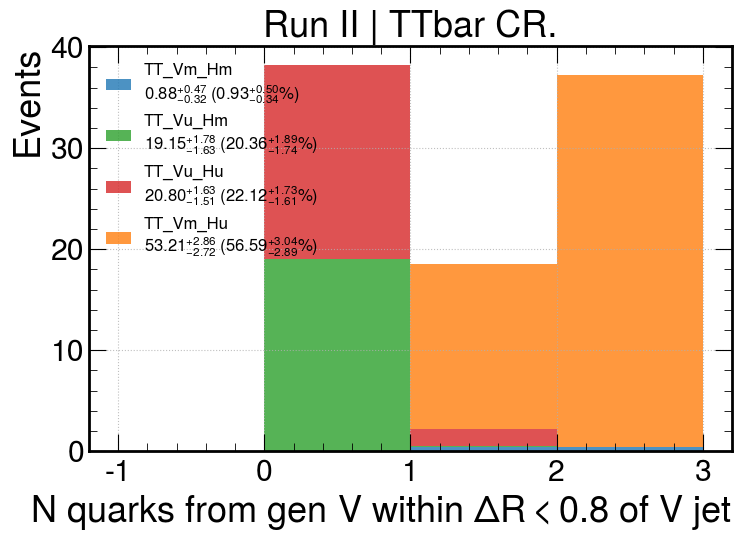

In [65]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="fj_qsinprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label=rf"N quarks from gen V within $\Delta R < 0.8$ of V jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets > 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.75) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | TTbar CR."
    ),    logy=False,
)

<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_251018/2494881751.py:8: SyntaxWarning: invalid escape sequence '\D'
  x_axis_label="N quarks from gen V within $\Delta R < 0.8$ of V jet",


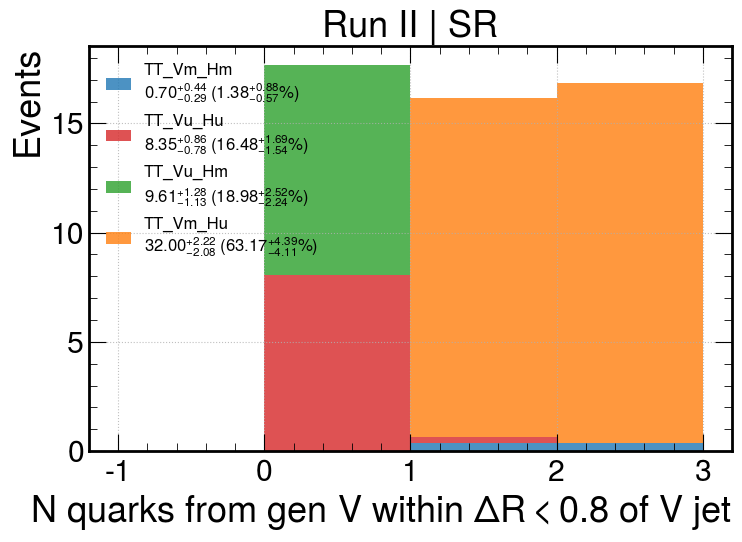

In [66]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="fj_qsinprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N quarks from gen V within $\Delta R < 0.8$ of V jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.905) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | SR"
    ),    logy=False,
)

<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_251018/2358053912.py:8: SyntaxWarning: invalid escape sequence '\D'
  x_axis_label="N quarks from gen V within $\Delta R < 0.8$ of H jet",


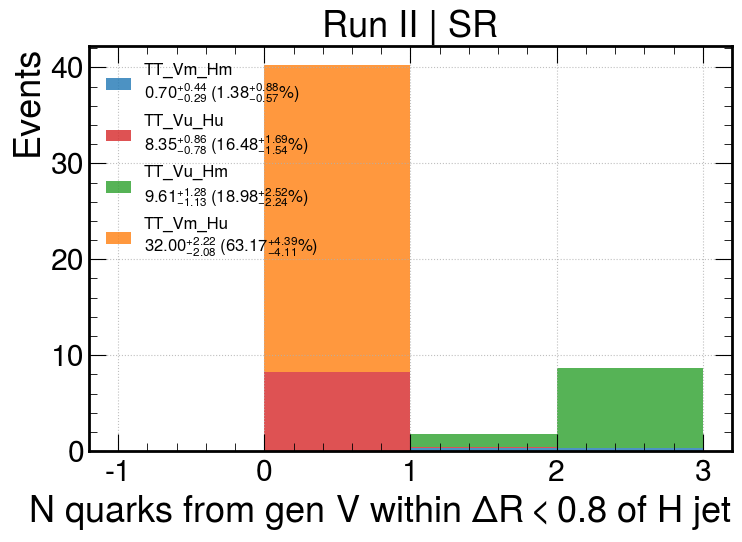

In [67]:
plot_tt_split_histogram(
    era_map=era_map,
    channels=["ele", "mu"],
    var="h_fj_qsinprongs",
    weight_field="weight_nominal_combined * trig_sf",
    bins=4,
    range=(-1,3),
    x_axis_label="N quarks from gen V within $\Delta R < 0.8$ of H jet",
    selection=(
                "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9)  & (THWW > 0.905) & "
                "(fj_mass>40.) & (fj_mass < 180)"
    ),
    plot_title=(
        f"Run II | SR"
    ),    logy=False,
)

In [21]:
def plot_tt_components_lines(
    era_map,
    channels=("ele", "mu"),
    var="fj_mass",
    weight_field="event_weight",
    selection=None,
    bins=50,
    range=(0, 300),
    x_axis_label=None,
    plot_title=None,
    logy=False,
):
    import boost_histogram as bh
    import numpy as np
    import matplotlib.pyplot as plt
    import mplhep as hep
    from hist.intervals import poisson_interval
    from collections import defaultdict

    hep.style.use("CMS")

    # --- fixed TTbar split colors
    COLORS = {
        "TT_Vm_Hm": "#1f77b4",  # blue
        "TT_Vm_Hu": "#ff7f0e",  # orange
        "TT_Vu_Hm": "#2ca02c",  # green
        "TT_Vu_Hu": "#d62728",  # red
    }

    # --- Axis
    if isinstance(bins, int):
        if range is None:
            raise ValueError("`range` must be specified when `bins` is an integer.")
        axis = bh.axis.Regular(bins, range[0], range[1])
    elif isinstance(bins, (list, np.ndarray)):
        axis = bh.axis.Variable(bins)
    else:
        raise ValueError("`bins` must be either an int or a list/array of bin edges.")
    bin_edges = axis.edges
    bin_centers = axis.centers
    bin_widths = np.diff(bin_edges)

    # --- Hist containers (weighted)
    hists = defaultdict(lambda: bh.Histogram(axis, storage=bh.storage.Weight()))

    # --- Fill only TT, split into 4 components
    for era, sample_map in era_map.items():
        for sample in sample_map.values():
            if sample.get("groupName") != "TT":
                continue
            for ch in channels:
                if ch not in sample:
                    continue
                df = sample[ch]
                if df is None or df.empty or (var not in df):
                    continue

                if selection:
                    try:
                        df = df.query(selection)
                    except Exception:
                        continue
                    if df.empty:
                        continue

                xsec = sample.get("xsec")
                sumgen = sample.get("sumgenweights")
                lumi = sample.get("lumi", {}).get(ch)
                if any(v is None for v in (xsec, sumgen, lumi)):
                    continue
                scale = (xsec * lumi) / sumgen

                try:
                    w_all = df.eval(weight_field).to_numpy() * scale
                except Exception:
                    continue

                # tag definitions (vectorized)
                vm = (df["fj_V_isMatched"] == 1) & (df.get("fj_isV_2q", 0) == 1)
                hm = (df["h_fj_V_isMatched"] == 1) & (df.get("h_fj_isV_2q", 0) == 1)
                masks = {
                    "TT_Vm_Hm": vm & hm,
                    "TT_Vm_Hu": vm & ~hm,
                    "TT_Vu_Hm": ~vm & hm,
                    "TT_Vu_Hu": ~vm & ~hm,
                }

                # If fj_mass has subcomponents with weights, use them; else just fill var
                use_mass_combo = (
                    var == "fj_mass"
                    and all(c in df for c in ("fj_mass_m1_nom", "fj_mass_m2_nom", "fj_mass_m3_nom",
                                              "fj_mass_w1_nom", "fj_mass_w2_nom", "fj_mass_w3_nom"))
                )

                for tag, m in masks.items():
                    if not np.any(m):
                        continue
                    if use_mass_combo:
                        # mixture with signed factors (as in your original)
                        for m_col, w_col, fac in [
                            ("fj_mass_m1_nom", "fj_mass_w1_nom", 1.0),
                            ("fj_mass_m2_nom", "fj_mass_w2_nom", 2.0),
                            ("fj_mass_m3_nom", "fj_mass_w3_nom", -1.0),
                        ]:
                            vals = df.loc[m, m_col].to_numpy()
                            ww = w_all[m] * df.loc[m, w_col].to_numpy() * fac
                            if vals.size:
                                hists[tag].fill(vals, weight=ww)
                    else:
                        vals = df.loc[m, var].to_numpy()
                        ww = w_all[m]
                        if vals.size:
                            hists[tag].fill(vals, weight=ww)

    # --- Totals for legend fractions (unnormalized TT total)
    total_tt_yield = float(sum(np.sum(h.view().value) for h in hists.values()))
    # Keep only non-empty components and in stable order
    ordered_tags = [k for k in ("TT_Vu_Hm", "TT_Vu_Hu", "TT_Vm_Hm", "TT_Vm_Hu") if np.sum(hists[k].view().value) > 0]

    # --- Helper: per-bin Garwood errors mapped from weighted counts
    def per_bin_asym_errors(vals, vars_):
        # eff_i = vals_i^2 / vars_i -> Garwood interval -> map back
        eff = np.divide(vals * vals, vars_, out=np.zeros_like(vals), where=vars_ > 0)
        lo, hi = poisson_interval(eff)  # arrays
        # map to yield scale
        err_lo = np.divide(vals * (eff - lo), eff, out=np.zeros_like(vals), where=eff > 0)
        err_hi = np.divide(vals * (hi - eff), eff, out=np.zeros_like(vals), where=eff > 0)
        return err_lo, err_hi

    # --- Helper: legend text with yield ± and fraction of TT
    def legend_label(vals, vars_, tag):
        ysum = float(np.sum(vals))
        vsum = float(np.sum(vars_))
        if ysum <= 0 or vsum <= 0:
            frac = (ysum / total_tt_yield) * 100.0 if total_tt_yield > 0 else 0.0
            return f"{tag}\n$\\mathrm{{{ysum:.2f}}}\\;({frac:.2f}\\%)$"
        eff = (ysum * ysum) / vsum
        lo, hi = poisson_interval(np.array([eff]))
        lo, hi = float(lo[0]), float(hi[0])
        err_lo = ysum * (eff - lo) / eff if eff > 0 else 0.0
        err_hi = ysum * (hi - eff) / eff if eff > 0 else 0.0
        frac = (ysum / total_tt_yield) * 100.0 if total_tt_yield > 0 else 0.0
        # show only yield ± and (fraction%)
        return (
            f"{tag}\n"
            f"$\\mathrm{{{ysum:.2f}}}^{{+{err_hi:.2f}}}_{{-{err_lo:.2f}}}"
            f"\\;({frac:.2f}\\%)$"
        )

    # --- Build normalized shapes (unit area, i.e., sum_i y_i * Δx_i = 1)
    norm_payload = {}
    for tag in ordered_tags:
        v = hists[tag].view().value
        s2 = hists[tag].view().variance
        area = float(np.sum(v * bin_widths))
        if area > 0:
            y = v / area
            e_lo, e_hi = per_bin_asym_errors(v, s2)
            e_lo /= area
            e_hi /= area
        else:
            y = np.zeros_like(v)
            e_lo = np.zeros_like(v)
            e_hi = np.zeros_like(v)
        norm_payload[tag] = (y, e_lo, e_hi, v, s2)  # keep original (v,s2) for legend stats

    # --- Plot
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.grid()

    ymax = 0.0
    handles, labels = [], []
    for tag in ordered_tags:
        y, elo, ehi, v, s2 = norm_payload[tag]
        color = COLORS.get(tag, None)
        # step line
        stairs = ax.stairs(y, bin_edges, color=color, linewidth=1.8, label=None)
        # error bars at bin centers (asymmetric)
        ax.errorbar(
            bin_centers, y, yerr=[elo, ehi],
            fmt="none", ecolor=color, elinewidth=1.0, capsize=0
        )
        handles.append(stairs)
        labels.append(legend_label(v, s2, tag))
        if y.size:
            ymax = max(ymax, float(np.max(y + ehi)))

    # headroom
    if ymax > 0 and not logy:
        ax.set_ylim(top=ymax * 1.05)

    ax.set_ylabel("Normalized events (unit area)")
    ax.set_xlabel(x_axis_label or var)
    if logy:
        ax.set_yscale("log")

    ax.legend(handles, labels, fontsize=12, ncol=1, loc="upper left", frameon=False, handlelength=1.6)
    if plot_title:
        ax.set_title(plot_title, fontsize="medium")

    plt.tight_layout()
    plt.show()


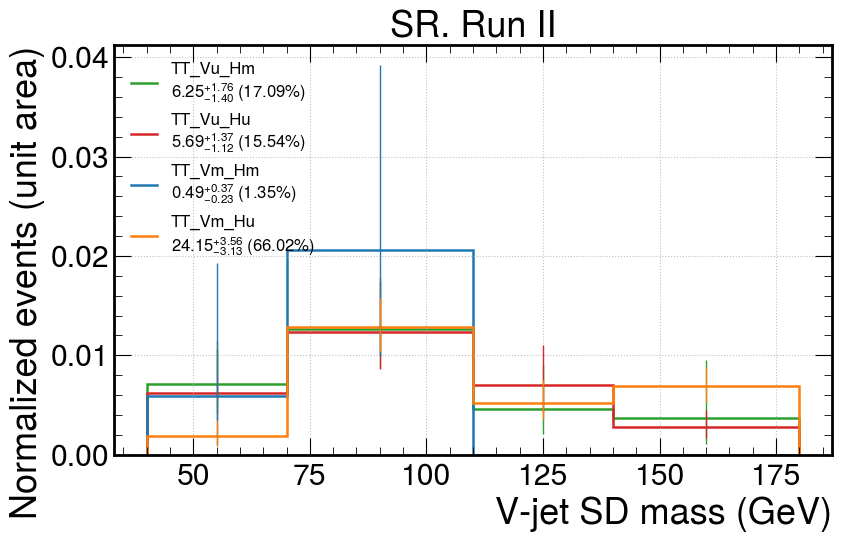

In [22]:
from slugify import slugify

variable_map = {

    "fj_mass": {
        "range": (40,180),
        "bins": np.array([40,70,110,140,180]),
        "x_axis_label": "V-jet SD mass (GeV)"
        
    },
}

for var, cfg in variable_map.items():
    plot_tt_components_lines(
        era_map,
        channels=["ele", "mu"],
        var=var,
        weight_field="weight_nominal_combined * trig_sf * v_tag_sf * 0.984 * weight_btag",
        bins=cfg.get("bins", 50),
        range=cfg["range"],
        x_axis_label=cfg["x_axis_label"],
        selection="(numberBJets_Medium_OutsideFatJets == 0) & (ReconVCandidateFatJetVScore > 0.9) & "
         "(THWW > 0.905) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250)  & ((mjj < 1000) | (deta < 2.5)) "
         " & (fj_mass > 40.) & (fj_mass < 180.)",
        plot_title="SR. Run II",
        logy=cfg.get("logy", False),
    )

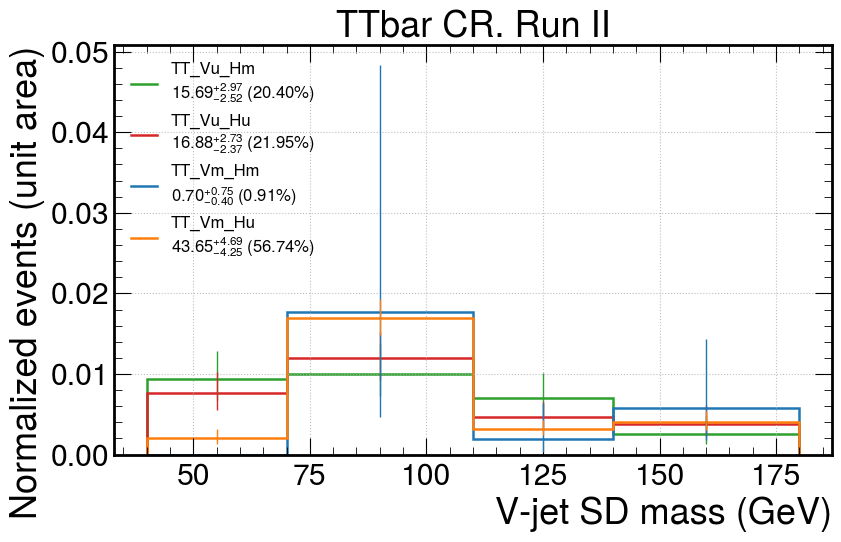

In [23]:
for var, cfg in variable_map.items():
    plot_tt_components_lines(
        era_map,
        channels=["ele", "mu"],
        var=var,
        weight_field="weight_nominal_combined * trig_sf * v_tag_sf * 0.984 * weight_btag",
        bins=cfg.get("bins", 50),
        range=cfg["range"],
        x_axis_label=cfg["x_axis_label"],
        selection="(numberBJets_Medium_OutsideFatJets > 0) & (ReconVCandidateFatJetVScore > 0.9) & "
         "(THWW > 0.75) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) "
         " & (fj_mass > 40.) & (fj_mass < 180.)",
        plot_title="TTbar CR. Run II",
        logy=cfg.get("logy", False),
    )

In [20]:
def plot_tt_components_lines(
    era_map,
    channels=("ele", "mu"),
    var="fj_mass",
    weight_field="event_weight",
    selection=None,
    bins=50,
    range=(0, 300),
    x_axis_label=None,
    plot_title=None,
    logy=False,
):
    import boost_histogram as bh
    import numpy as np
    import matplotlib.pyplot as plt
    import mplhep as hep
    from hist.intervals import poisson_interval
    from collections import defaultdict

    hep.style.use("CMS")

    # --- fixed TTbar split colors
    COLORS = {
        "TT_Vm": "#1f77b4",  # blue
        "TT_Vu": "#d62728",  # red
    }

    # --- Axis
    if isinstance(bins, int):
        if range is None:
            raise ValueError("`range` must be specified when `bins` is an integer.")
        axis = bh.axis.Regular(bins, range[0], range[1])
    elif isinstance(bins, (list, np.ndarray)):
        axis = bh.axis.Variable(bins)
    else:
        raise ValueError("`bins` must be either an int or a list/array of bin edges.")
    bin_edges = axis.edges
    bin_centers = axis.centers
    bin_widths = np.diff(bin_edges)

    # --- Hist containers (weighted)
    hists = defaultdict(lambda: bh.Histogram(axis, storage=bh.storage.Weight()))

    # --- Fill only TT, split into Vm/Vu; apply 3× JMR/JMS scheme consistently
    for era, sample_map in era_map.items():
        for sample in sample_map.values():
            if sample.get("groupName") != "TT":
                continue
            for ch in channels:
                if ch not in sample:
                    continue
                df = sample[ch]
                if df is None or df.empty or (var not in df):
                    continue

                if selection:
                    try:
                        df = df.query(selection)
                    except Exception:
                        continue
                    if df.empty:
                        continue

                xsec = sample.get("xsec")
                sumgen = sample.get("sumgenweights")
                lumi = sample.get("lumi", {}).get(ch)
                if any(v is None for v in (xsec, sumgen, lumi)):
                    continue
                scale = (xsec * lumi) / sumgen

                try:
                    w_all = df.eval(weight_field).to_numpy() * scale
                except Exception:
                    continue

                # tags
                vm = (df["fj_V_isMatched"] == 1) & (df.get("fj_isV_2q", 0) == 1)
                masks = {"TT_Vm": vm, "TT_Vu": ~vm}

                # Availability flags for JMR/JMS decomposition
                has_mass_combo = all(
                    c in df
                    for c in (
                        "fj_mass_m1_nom", "fj_mass_m2_nom", "fj_mass_m3_nom",
                        "fj_mass_w1_nom", "fj_mass_w2_nom", "fj_mass_w3_nom",
                    )
                )
                has_weight_combo_only = all(
                    c in df for c in ("fj_mass_w1_nom", "fj_mass_w2_nom", "fj_mass_w3_nom")
                )
                components = [
                    (1.0, "fj_mass_m1_nom", "fj_mass_w1_nom"),
                    (2.0, "fj_mass_m2_nom", "fj_mass_w2_nom"),
                    (-1.0, "fj_mass_m3_nom", "fj_mass_w3_nom"),
                ]

                for tag, m in masks.items():
                    if not np.any(m):
                        continue

                    if var == "fj_mass" and has_mass_combo:
                        # Use component-specific mass values AND weights (classic 3× fill)
                        for fac, m_col, w_col in components:
                            vals = df.loc[m, m_col].to_numpy()
                            ww = w_all[m] * df.loc[m, w_col].to_numpy() * fac
                            if vals.size:
                                hists[tag].fill(vals, weight=ww)
                    else:
                        # For any other variable, still apply the SAME 3× weight mixture,
                        # but use the single var values; this preserves integrals/correspondence.
                        vals = df.loc[m, var].to_numpy()
                        if not vals.size:
                            continue
                        if has_weight_combo_only:
                            w1 = w_all[m] * df.loc[m, "fj_mass_w1_nom"].to_numpy() * 1.0
                            w2 = w_all[m] * df.loc[m, "fj_mass_w2_nom"].to_numpy() * 2.0
                            w3 = w_all[m] * df.loc[m, "fj_mass_w3_nom"].to_numpy() * (-1.0)
                            # three fills on the SAME variable values
                            hists[tag].fill(vals, weight=w1)
                            hists[tag].fill(vals, weight=w2)
                            hists[tag].fill(vals, weight=w3)
                        else:
                            # Fallback if no JMR/JMS weights present
                            ww = w_all[m]
                            hists[tag].fill(vals, weight=ww)

    # --- Totals for legend fractions (unnormalized TT total)
    total_tt_yield = float(sum(np.sum(h.view().value) for h in hists.values()))
    ordered_tags = [k for k in ("TT_Vm", "TT_Vu") if np.sum(hists[k].view().value) > 0]

    # --- Per-bin weighted Garwood errors mapped back
    def per_bin_asym_errors(vals, vars_):
        eff = np.divide(vals * vals, vars_, out=np.zeros_like(vals), where=vars_ > 0)
        lo, hi = poisson_interval(eff)
        err_lo = np.divide(vals * (eff - lo), eff, out=np.zeros_like(vals), where=eff > 0)
        err_hi = np.divide(vals * (hi - eff), eff, out=np.zeros_like(vals), where=eff > 0)
        return err_lo, err_hi

    # --- Legend label (yield ±; fraction of total TT)
    def legend_label(vals, vars_, tag):
        ysum = float(np.sum(vals))
        vsum = float(np.sum(vars_))
        if ysum <= 0 or vsum <= 0:
            frac = (ysum / total_tt_yield) * 100.0 if total_tt_yield > 0 else 0.0
            return f"{tag}\n$\\mathrm{{{ysum:.2f}}}\\;({frac:.2f}\\%)$"
        eff = (ysum * ysum) / vsum
        lo, hi = poisson_interval(np.array([eff]))
        lo, hi = float(lo[0]), float(hi[0])
        err_lo = ysum * (eff - lo) / eff if eff > 0 else 0.0
        err_hi = ysum * (hi - eff) / eff if eff > 0 else 0.0
        frac = (ysum / total_tt_yield) * 100.0 if total_tt_yield > 0 else 0.0
        return (
            f"{tag}\n"
            f"$\\mathrm{{{ysum:.2f}}}^{{+{err_hi:.2f}}}_{{-{err_lo:.2f}}}"
            f"\\;({frac:.2f}\\%)$"
        )

    # --- Build normalized shapes (unit area: sum_i y_i * Δx_i = 1)
    norm_payload = {}
    for tag in ordered_tags:
        v = hists[tag].view().value
        s2 = hists[tag].view().variance
        area = float(np.sum(v * bin_widths))
        if area > 0:
            y = v / area
            e_lo, e_hi = per_bin_asym_errors(v, s2)
            e_lo /= area
            e_hi /= area
        else:
            y = np.zeros_like(v)
            e_lo = np.zeros_like(v)
            e_hi = np.zeros_like(v)
        norm_payload[tag] = (y, e_lo, e_hi, v, s2)

    # --- Plot
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.grid()

    ymax = 0.0
    handles, labels = [], []
    for tag in ordered_tags:
        y, elo, ehi, v, s2 = norm_payload[tag]
        color = COLORS.get(tag, None)
        stairs = ax.stairs(y, bin_edges, color=color, linewidth=1.8, label=None)
        ax.errorbar(bin_centers, y, yerr=[elo, ehi], fmt="none", ecolor=color, elinewidth=1.0, capsize=0)
        handles.append(stairs)
        labels.append(legend_label(v, s2, tag))
        if y.size:
            ymax = max(ymax, float(np.max(y + ehi)))

    if ymax > 0 and not logy:
        ax.set_ylim(top=ymax * 1.05)

    ax.set_ylabel("Normalized events (unit area)")
    ax.set_xlabel(x_axis_label or var)
    if logy:
        ax.set_yscale("log")

    ax.legend(handles, labels, fontsize=12, ncol=1, loc="upper right", frameon=False, handlelength=1.6)
    if plot_title:
        ax.set_title(plot_title, fontsize="medium")

    plt.tight_layout()
    plt.show()


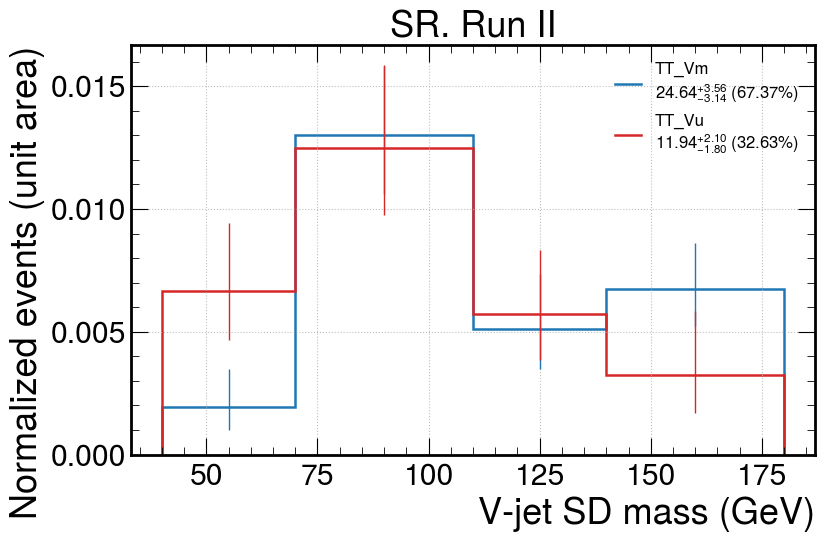

In [31]:
from slugify import slugify

variable_map = {

    "fj_mass": {
        "range": (40,180),
        "bins": np.array([40,70,110,140,180]),
        "x_axis_label": "V-jet SD mass (GeV)"
        
    },
}

for var, cfg in variable_map.items():
    plot_tt_components_lines(
        era_map,
        channels=["ele", "mu"],
        var=var,
        weight_field="weight_nominal_combined * trig_sf * v_tag_sf * 0.984 * weight_btag",
        bins=cfg.get("bins", 50),
        range=cfg["range"],
        x_axis_label=cfg["x_axis_label"],
        selection="(numberBJets_Medium_OutsideFatJets == 0) & (ReconVCandidateFatJetVScore > 0.9) & "
         "(THWW > 0.905) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250)  & ((mjj < 1000) | (deta < 2.5)) "
         " & (fj_mass > 40.) & (fj_mass < 180.)",
        plot_title="SR. Run II",
        logy=cfg.get("logy", False),
    )

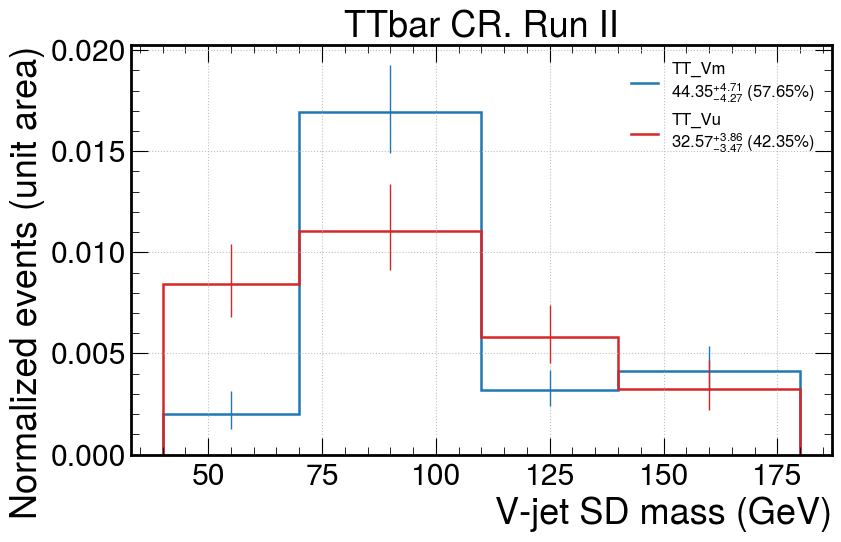

In [32]:
for var, cfg in variable_map.items():
    plot_tt_components_lines(
        era_map,
        channels=["ele", "mu"],
        var=var,
        weight_field="weight_nominal_combined * trig_sf * v_tag_sf * 0.984 * weight_btag",
        bins=cfg.get("bins", 50),
        range=cfg["range"],
        x_axis_label=cfg["x_axis_label"],
        selection="(numberBJets_Medium_OutsideFatJets > 0) & (ReconVCandidateFatJetVScore > 0.9) & "
         "(THWW > 0.75) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) "
         " & (fj_mass > 40.) & (fj_mass < 180.)",
        plot_title="TTbar CR. Run II",
        logy=cfg.get("logy", False),
    )

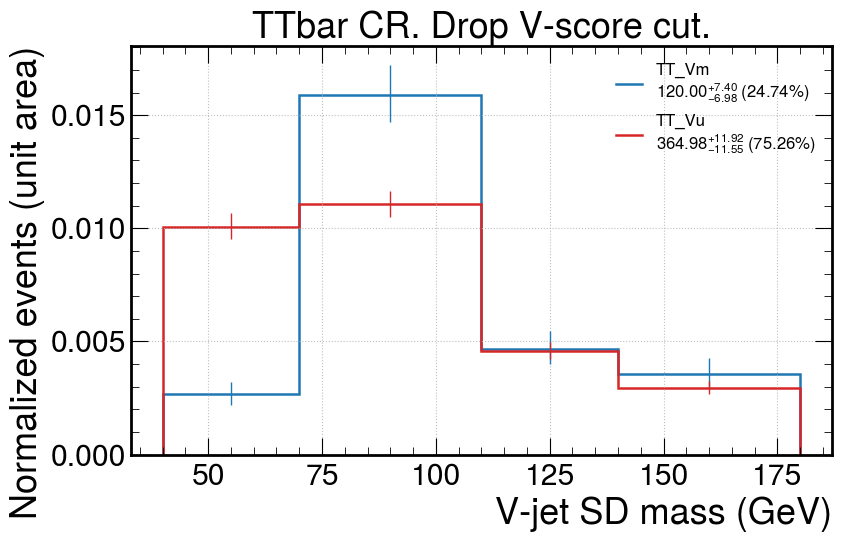

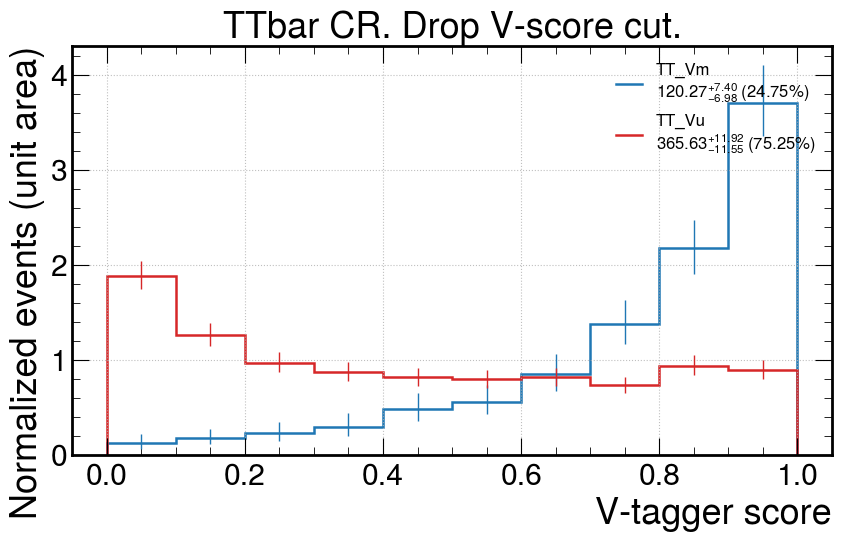

In [22]:
variable_map = {

    "fj_mass": {
        "range": (40,180),
        "bins": np.array([40,70,110,140,180]),
        "x_axis_label": "V-jet SD mass (GeV)"
        
    },

    "ReconVCandidateFatJetVScore": {
        "range": (0, 1),
        "bins": 10,
        "x_axis_label": "V-tagger score",
        # "logy": True
    },

}


for var, cfg in variable_map.items():
    plot_tt_components_lines(
        era_map,
        channels=["ele", "mu"],
        var=var,
        weight_field="weight_nominal_combined * trig_sf * v_tag_sf * 0.984 * weight_btag",
        bins=cfg.get("bins", 50),
        range=cfg["range"],
        x_axis_label=cfg["x_axis_label"],
        selection="(numberBJets_Medium_OutsideFatJets > 0) & "
         "(THWW > 0.75) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) "
         " & (fj_mass > 40.) & (fj_mass < 180.)",
        plot_title="TTbar CR. Drop V-score cut.",
        logy=cfg.get("logy", False),
    )

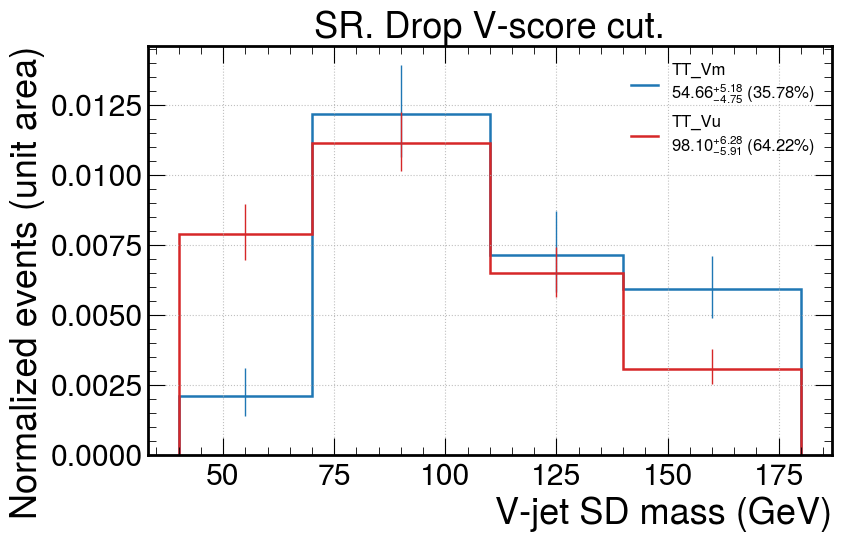

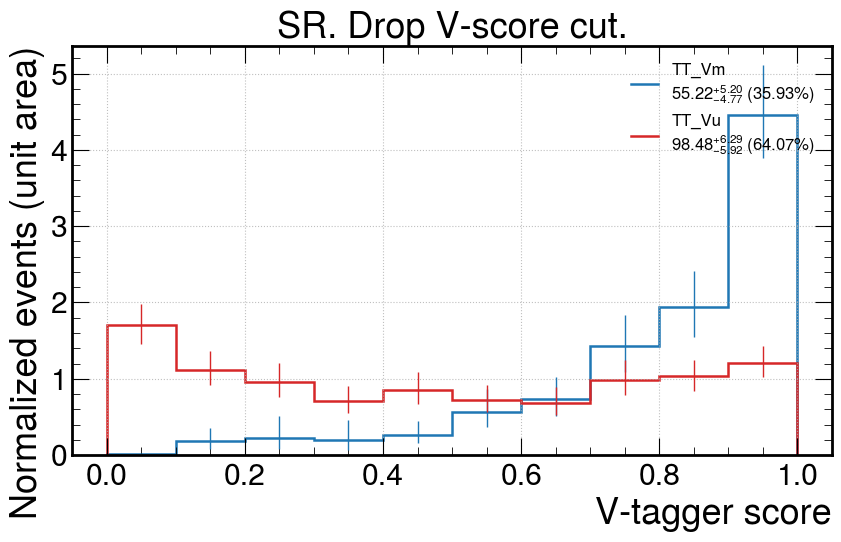

In [23]:
variable_map = {

    "fj_mass": {
        "range": (40,180),
        "bins": np.array([40,70,110,140,180]),
        "x_axis_label": "V-jet SD mass (GeV)"
        
    },

    "ReconVCandidateFatJetVScore": {
        "range": (0, 1),
        "bins": 10,
        "x_axis_label": "V-tagger score",
        # "logy": True
    },

}

for var, cfg in variable_map.items():
    plot_tt_components_lines(
        era_map,
        channels=["ele", "mu"],
        var=var,
        weight_field="weight_nominal_combined * trig_sf * v_tag_sf * 0.984 * weight_btag",
        bins=cfg.get("bins", 50),
        range=cfg["range"],
        x_axis_label=cfg["x_axis_label"],
        selection="(numberBJets_Medium_OutsideFatJets == 0) & "
         "(THWW > 0.905) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250)  & ((mjj < 1000) | (deta < 2.5)) "
         " & (fj_mass > 40.) & (fj_mass < 180.)",
        plot_title="SR. Drop V-score cut.",
        logy=cfg.get("logy", False),
    )

In [10]:
variable_map = {

    "fj_mass": {
        "range": (40,180),
        "bins": np.array([40,70,110,140,180]),
        "x_axis_label": "V-jet SD mass (GeV)"
        
    },

    "THWW" : {
        "range": (0, 1),
        "bins": 10,
        "x_axis_label": "PartT score",
        # "logy": True
    },

    "ReconVCandidateFatJetVScore": {
        "range": (0, 1),
        "bins": 10,
        "x_axis_label": "V-tagger score",
        # "logy": True
    },

}

for var, cfg in variable_map.items():
    plot_tt_components_lines(
        era_map,
        channels=["ele", "mu"],
        var=var,
        weight_field="weight_nominal_combined * trig_sf * v_tag_sf * 0.984 * weight_btag",
        bins=cfg.get("bins", 50),
        range=cfg["range"],
        x_axis_label=cfg["x_axis_label"],
        selection="(numberBJets_Medium_OutsideFatJets > 0) & (ReconVCandidateFatJetVScore > 0.9) & "
         "(met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) "
         " & (fj_mass > 40.) & (fj_mass < 180.)",
        plot_title="TTbar CR. Drop H-score cut",
        logy=cfg.get("logy", False),
    )

NameError: name 'plot_tt_components_lines' is not defined

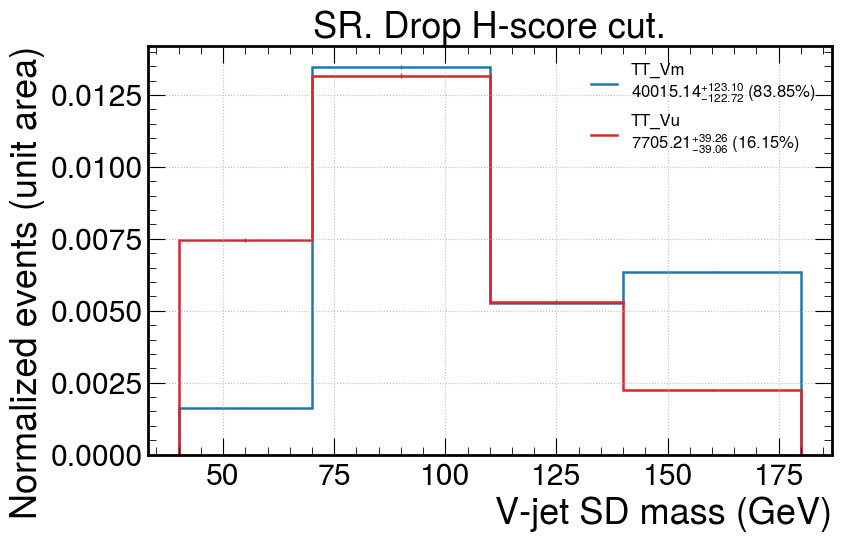

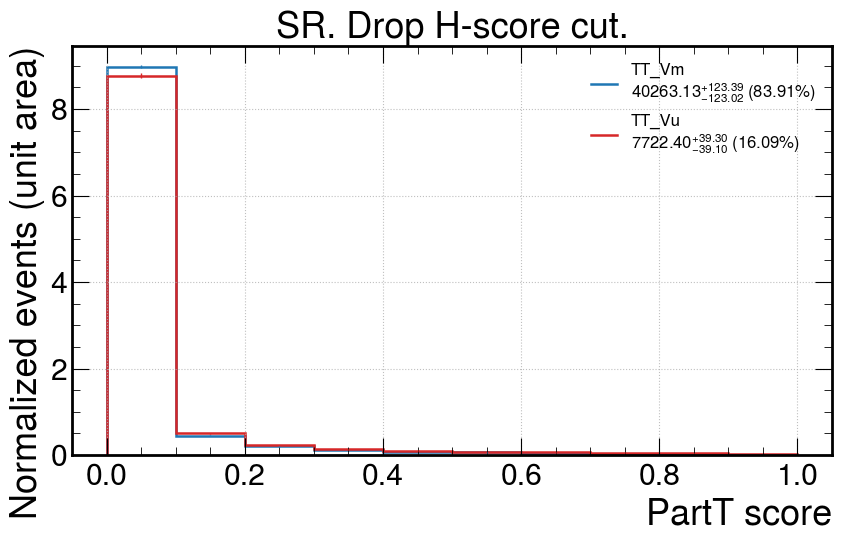

In [25]:
for var, cfg in variable_map.items():
    plot_tt_components_lines(
        era_map,
        channels=["ele", "mu"],
        var=var,
        weight_field="weight_nominal_combined * trig_sf * v_tag_sf * 0.984 * weight_btag",
        bins=cfg.get("bins", 50),
        range=cfg["range"],
        x_axis_label=cfg["x_axis_label"],
        selection=(
                    "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250) & (ReconVCandidateFatJetVScore > 0.9) &"
                    "(fj_mass>40.) & (fj_mass < 180)"
        ),
        plot_title="SR. Drop H-score cut.",
        logy=cfg.get("logy", False),
    )

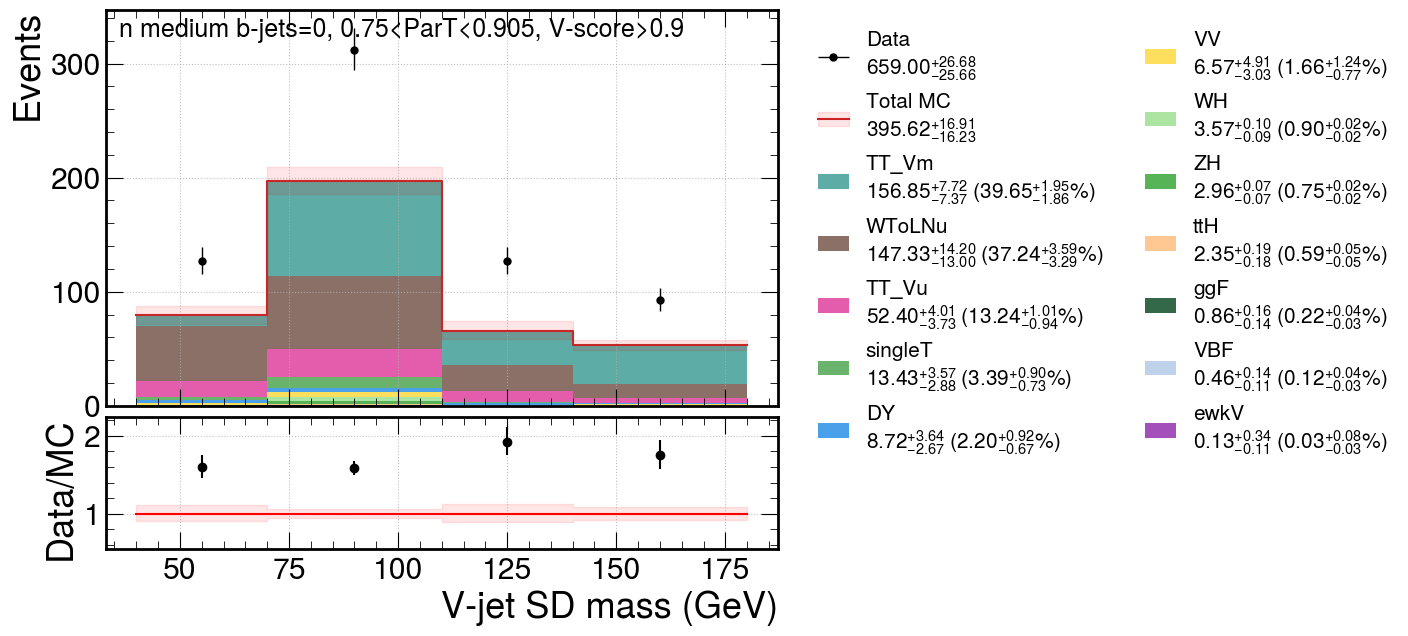

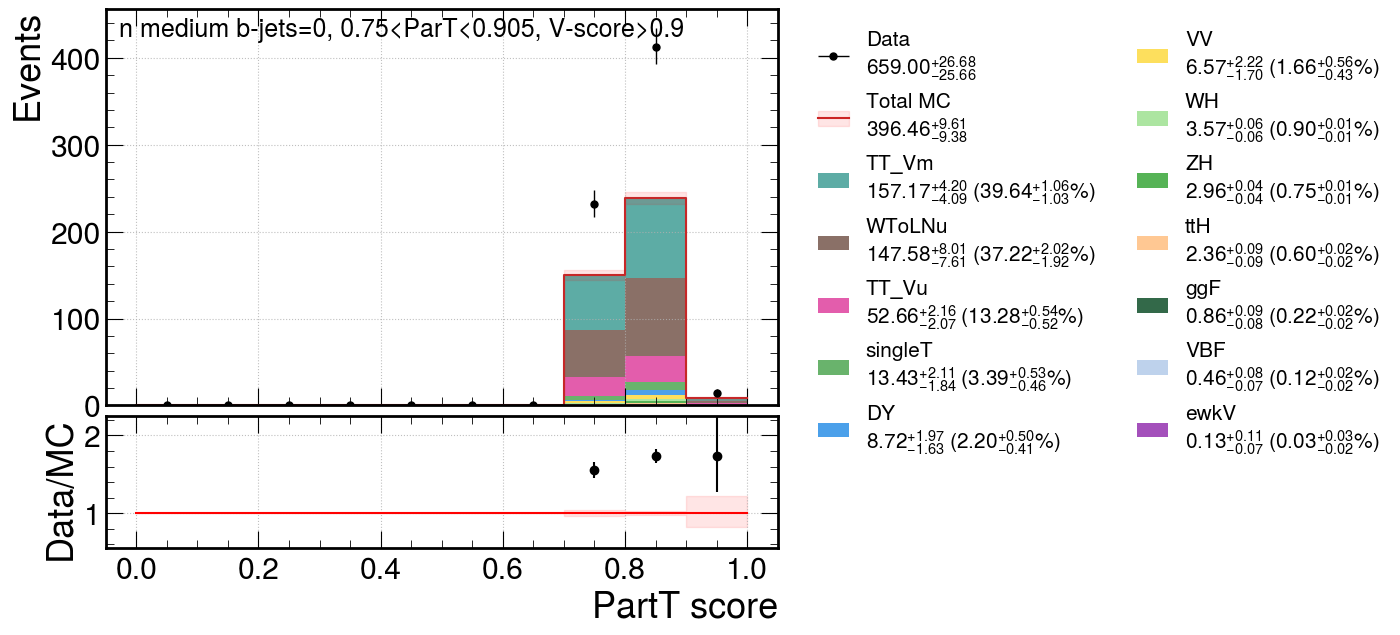

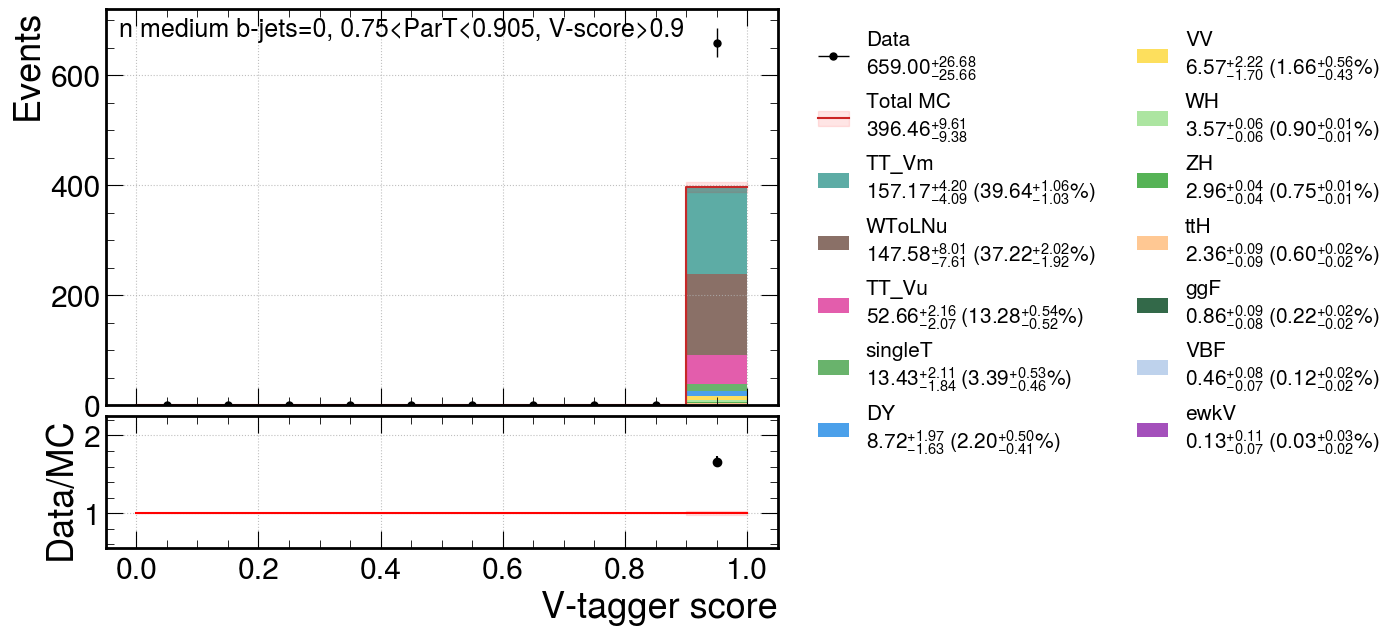

In [11]:
# Define what to plot
era_groups = {
    # "2016": ["2016"],
    # "2016APV": ["2016APV"],
    # "2017": ["2017"],
    # "2018": ["2018"],
    "Run2": ["2016", "2016APV", "2017", "2018"]
}

# Plotting
for era_label, eras_in_group in era_groups.items():
    # Pass full era_map for combined plots; otherwise, single-era slice
    if set(eras_in_group) == set(era_map.keys()):
        era_subset = era_map  # full combined map
    else:
        era_subset = {era: era_map[era] for era in eras_in_group}

    for var, cfg in variable_map.items():
        plot_data_mc_histogram(
            era_map=era_subset,
            channels=["ele", "mu"],
            var=var,
            weight_field="weight_nominal_combined * trig_sf * v_tag_sf * 0.984 * weight_btag",
            bins=cfg.get("bins", 50),
            range=cfg["range"],
            x_axis_label=cfg["x_axis_label"],
            selection=(
                "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250)  & (THWW > 0.75) & (THWW < 0.905) & "
                "(fj_mass>40.) & (fj_mass < 180)"
                "& (ReconVCandidateFatJetVScore > 0.9)  "
                #  
            ),
            plot_title=(
                f"n medium b-jets=0, 0.75<ParT<0.905, V-score>0.9"
            ),
            ratio_range=cfg.get("ratio_range", [0.55, 2.25]),
            logy=cfg.get("logy", False),
        )

    del era_subset


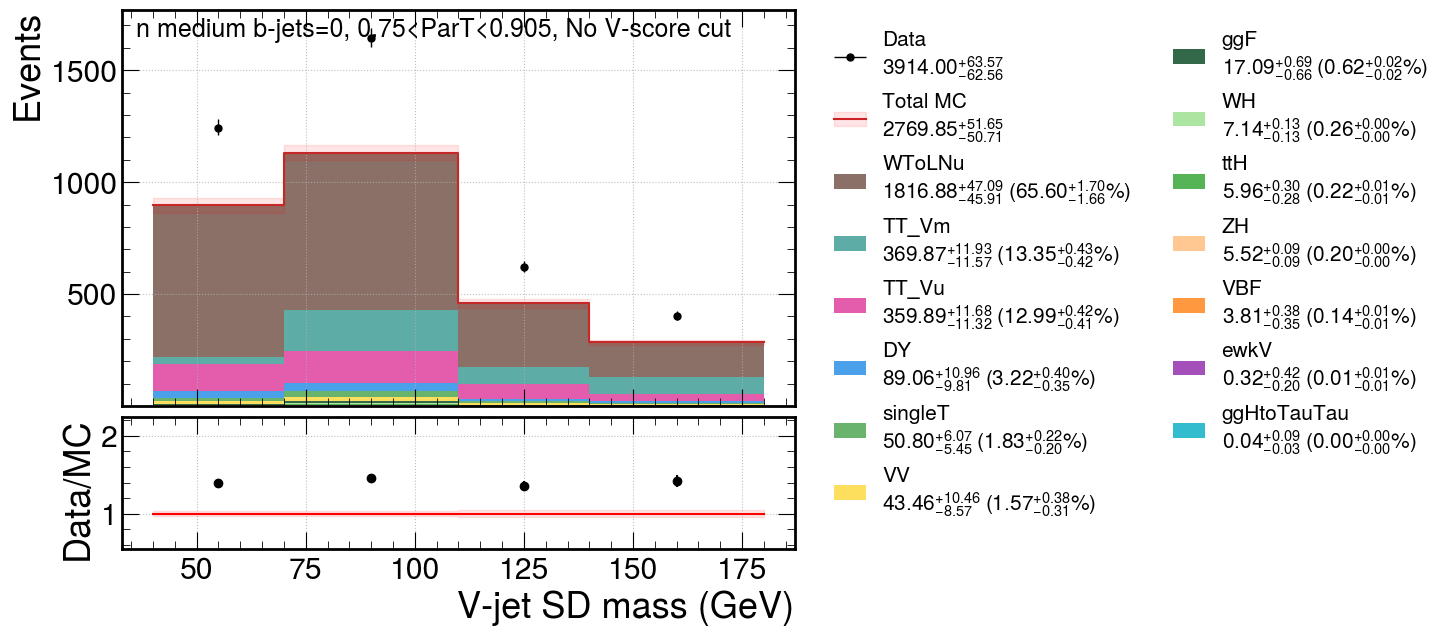

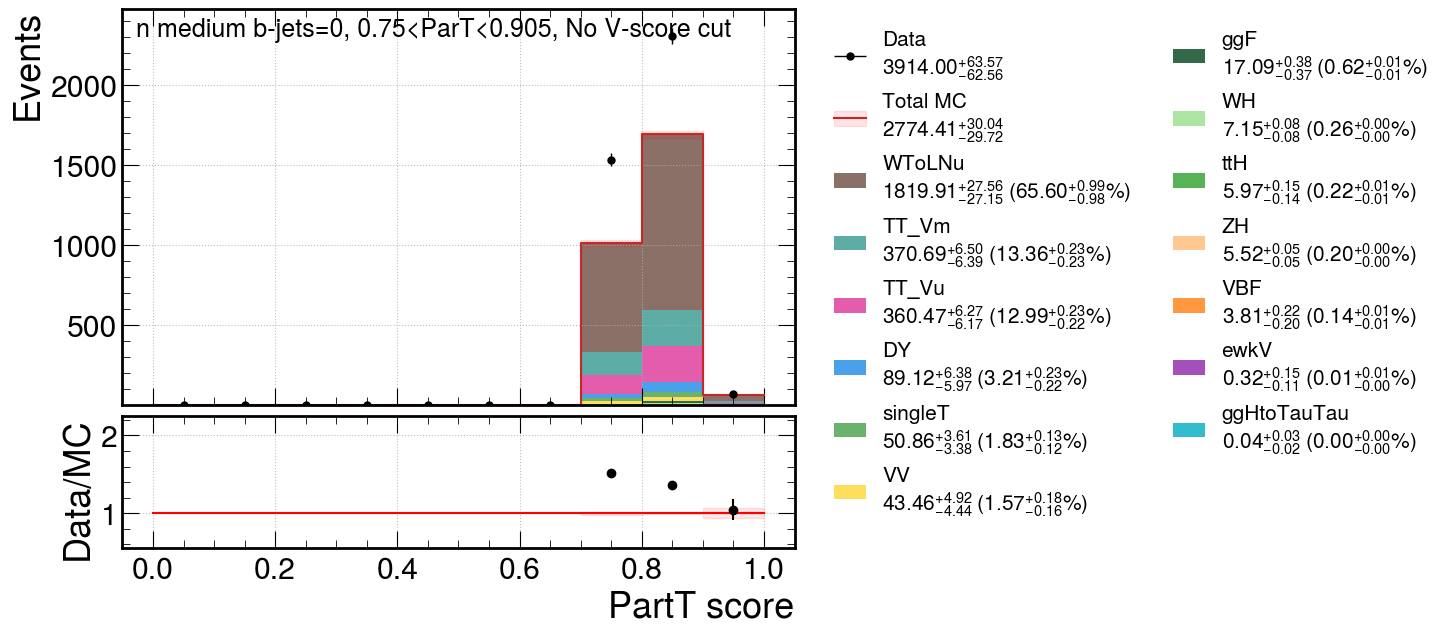

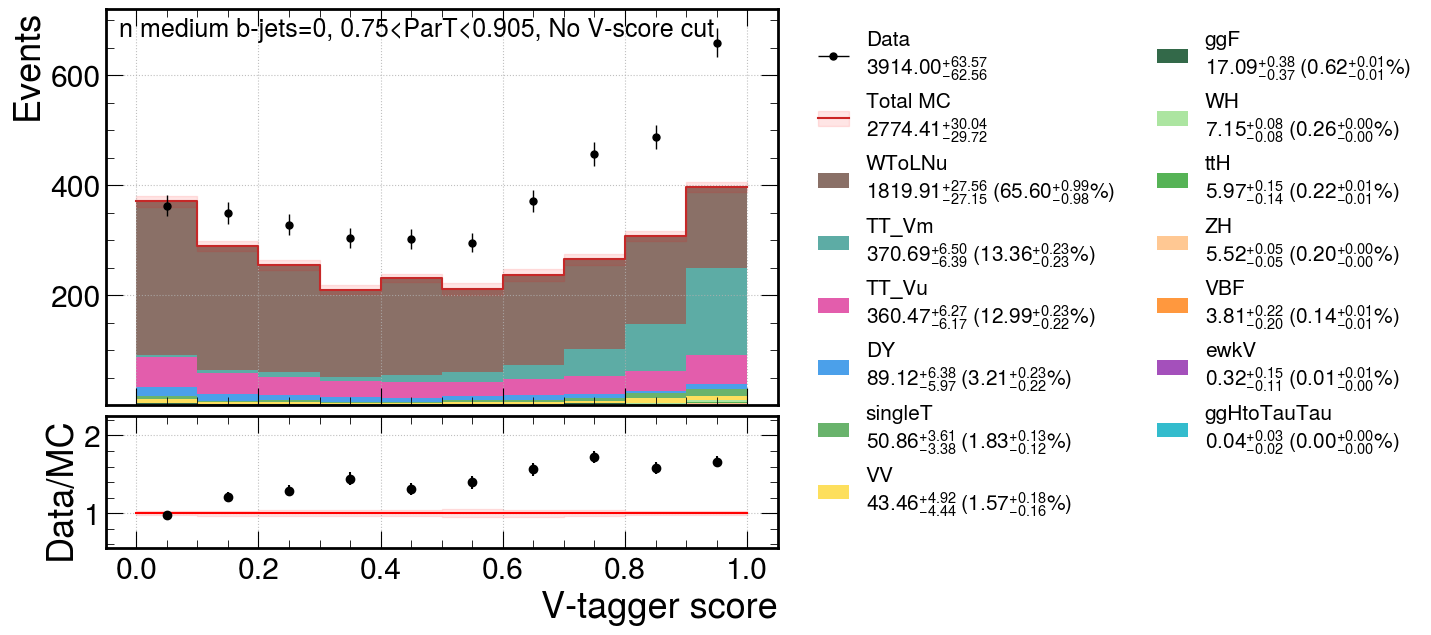

In [13]:
# Define what to plot
era_groups = {
    # "2016": ["2016"],
    # "2016APV": ["2016APV"],
    # "2017": ["2017"],
    # "2018": ["2018"],
    "Run2": ["2016", "2016APV", "2017", "2018"]
}

# Plotting
for era_label, eras_in_group in era_groups.items():
    # Pass full era_map for combined plots; otherwise, single-era slice
    if set(eras_in_group) == set(era_map.keys()):
        era_subset = era_map  # full combined map
    else:
        era_subset = {era: era_map[era] for era in eras_in_group}

    for var, cfg in variable_map.items():
        plot_data_mc_histogram(
            era_map=era_subset,
            channels=["ele", "mu"],
            var=var,
            weight_field="weight_nominal_combined * trig_sf * v_tag_sf * 0.984 * weight_btag",
            bins=cfg.get("bins", 50),
            range=cfg["range"],
            x_axis_label=cfg["x_axis_label"],
            selection=(
                "(numberBJets_Medium_OutsideFatJets == 0) & (met_pt > 30) & (fj_pt > 250) & (h_fj_pt > 250)  & (THWW > 0.75) & (THWW < 0.905) & "
                "(fj_mass>40.) & (fj_mass < 180)"
                # "& (ReconVCandidateFatJetVScore > 0.9)  "
                #  
            ),
            plot_title=(
                f"n medium b-jets=0, 0.75<ParT<0.905, No V-score cut"
            ),
            ratio_range=cfg.get("ratio_range", [0.55, 2.25]),
            logy=cfg.get("logy", False),
        )

    del era_subset
